In [3]:
import os
import pickle
import random
import inspect
import numpy as np

import matplotlib.pyplot as plt
import multiprocessing

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

from multiprocessing import Process, Queue
from concurrent.futures import ProcessPoolExecutor, TimeoutError
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

np.seterr(over='ignore', under='ignore', invalid='ignore');

In [2]:
LOG_MIN, LOG_MAX = -5, 5
SIM_T_MAX = 100.0
TRAIN_SAMPLE_POINTS = 21
TEST_SAMPLE_POINTS = 7

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

N_MECH = 20
N_TOTAL_THETA = 108208
THETA_TRAIN_VAL = int(N_TOTAL_THETA * 0.9)
THETA_TEST = N_TOTAL_THETA - THETA_TRAIN_VAL

N_TRAIN = 4_950_000
N_VAL = 50_000
N_TEST = 100_000

MECHANISMS = [f"M{i}" for i in range(1, 21)]

STANDARD_Y0 = {
    "M1": [1.0, 0.0, 0.05, 0.0],
    "M2": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M3": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M4": [1.0, 0.0, 0.05, 0.0, 1.0],
    "M5": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M6": [1.0, 0.0, 0.03, 0.0, 0.0],
    "M7": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M8": [1.0, 0.0, 0.05, 0.0, 0.0, 1.0],
    "M9": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M10": [1.0, 0.0, 0.03, 0.0, 1.0, 0.0],
    "M11": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M12": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M13": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M14": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M15": [1.0, 0.0, 0.05, 0.0, 1.0, 0.0],
    "M16": [1.0, 0.0, 0.03, 0.0, 0.0],
    "M17": [1.0, 0.0, 0.05, 0.0, 0.0],
    "M18": [1.0, 0.0, 0.03, 0.0, 0.0],
    "M19": [1.0, 0.0, 0.03, 0.0, 0.0],
    "M20": [1.0, 0.0, 0.05, 0.0, 0.0, 0.0],
}

MECH_REQUIRE_YIELD = {f"M{i}": True for i in range(1, 21)}

def round_sig(x, sig=3):
    x = np.asarray(x, dtype=float)
    mags = np.abs(x)
    p = np.where(mags > 0,
                 sig - np.floor(np.log10(mags)) - 1,
                 0).astype(int)
    factor = np.power(10.0, p)
    return np.round(x * factor) / factor

def sample_theta_pool(n, dim, seed=None):
    rng = np.random.default_rng(seed)
    arr = round_sig(10 ** rng.uniform(LOG_MIN, LOG_MAX, size=(n, dim)))
    return arr

def maximum_yield_criterion(ode_func, theta, y0=None, y_low=0.5, y_high=1.0, t_max=SIM_T_MAX):
    theta = theta.tolist() if isinstance(theta, np.ndarray) else theta
    try:
        if y0 is None:
            S0, cat0 = 1.0, 0.05
            n_states = len(ode_func(0., [S0]*4, theta))
            y0 = [0.0]*n_states
            y0[0] = S0
            y0[2] = cat0
        t = np.linspace(0, t_max, 300)
        sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                        [0, t_max], y0, t_eval=t,
                        method="LSODA", rtol=1e-6, atol=1e-9)
        if (not sol.success) or np.isnan(sol.y).any():
            return False
        S = sol.y[0]
        conv = (S[0] - S[-1]) / (S[0] + 1e-8)
        if not (y_low <= conv <= y_high):
            return False
        if S[-1] < 1e-3 or S[-1] > 1-1e-3:
            return False
        if np.allclose(S, S[0], atol=1e-3):
            return False
        P = sol.y[1]
        if np.allclose(P, P[-1], atol=1e-3):
            return False
        return True
    except Exception:
        return False

seen_theta = set()

def filter_theta_pool(n_required, filter_func, ode_func, dim, y0_func=None, max_round=500, batch_factor=200, verbose=False):
    global BIASED_SAMPLE_FUNCS, MECH_REQUIRE_YIELD, STANDARD_Y0, seen_theta

    passed = []
    rounds = 0
    mech_name = ode_func.__name__.replace("ode_", "")

    def infer_standard_y0(ode_func):
        if mech_name in STANDARD_Y0:
            return STANDARD_Y0[mech_name]
        else:
            try:
                test_theta = [1.0] * dim
                test_result = ode_func(0.0, [1.0] * 10, test_theta)
                state_dim = len(test_result)
            except:
                state_dim = dim + 2
            y0 = [0.0] * state_dim
            y0[0] = 1.0
            if state_dim > 2:
                y0[2] = 0.05
            return y0

    while len(passed) < n_required and rounds < max_round:
        batch_size = min(max(batch_factor * (n_required - len(passed)), 40), 200)

        if mech_name in globals().get('BIASED_SAMPLE_FUNCS', {}):
            thetas = BIASED_SAMPLE_FUNCS[mech_name](batch_size)
        else:
            thetas = sample_theta_pool(batch_size, dim)

        thetas = np.array(thetas)
        if thetas.ndim == 1:
            thetas = thetas.reshape(-1, dim)

        for theta in thetas:
            theta = np.array(theta, dtype=float).flatten().tolist()
            theta_tuple = tuple(np.round(theta, 6))
            if theta_tuple in seen_theta:
                continue
            seen_theta.add(theta_tuple)
            try:
                y0 = y0_func() if y0_func else infer_standard_y0(ode_func)
                if filter_func is not None and not filter_func(theta, ode_func):
                    continue
                if MECH_REQUIRE_YIELD.get(mech_name, True):
                    if not maximum_yield_criterion(ode_func, theta, y0):
                        continue
                passed.append(theta)
                if len(passed) >= n_required:
                    break
            except Exception:
                continue
        rounds += 1

    if len(passed) < n_required:
        raise RuntimeError(f"Only {len(passed)} samples found after {rounds} rounds (need {n_required}) for {ode_func.__name__}.")

    return np.array([list(theta) for theta in passed[:n_required]])

def simulate_trajectory(ode_func, theta, y0, n_points=5000, timeout=10):
    theta = theta.tolist() if isinstance(theta, np.ndarray) else theta
    try:
        t_eval = np.linspace(0, SIM_T_MAX, n_points)
        sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                        [0, SIM_T_MAX], y0, t_eval=t_eval,
                        method="LSODA", rtol=1e-6, atol=1e-9, max_step=1.0)
        if sol.success and np.all(np.isfinite(sol.y)):
            return sol.t, sol.y
    except Exception:
        return None
    return None

def subsample_points(arr, t_full, n_points):
    idx_all = np.arange(arr.shape[1])
    idx_rest = idx_all[1:]
    if n_points == 1:
        idx = np.array([0])
    else:
        if n_points > arr.shape[1]:
            raise ValueError(f"Cannot sample {n_points} points from array with {arr.shape[1]} time points")
        idx = np.array([0] + sorted(np.random.choice(idx_rest, n_points - 1, replace=False)))
    return arr[:, idx], t_full[idx]

def extract_SPcat(traj):
    return traj[[0, 1], :]

def format_x2_blocks(x2_array, t_list, n_points=21):
    x2_reformat = []
    for i in range(len(x2_array)):
        profiles = []
        for j in range(4):
            start = j * n_points
            stop = (j + 1) * n_points
            time = t_list[i][start:stop].reshape(-1, 1)
            SP = x2_array[i][start:stop, :2]
            t_norm = (time - time.min()) / (time.max() - time.min() + 1e-12)
            block = np.hstack([t_norm, SP])
            profiles.append(block)
        block_cat = np.hstack(profiles)
        x2_reformat.append(block_cat)
    return np.stack(x2_reformat)

def format_test_blocks(x2_array, t_list, n_points=7):
    x2_reformat = []
    for i in range(len(x2_array)):
        profiles = []
        for j in range(4):
            start = j * n_points
            stop = (j + 1) * n_points
            time = t_list[i][start:stop].reshape(-1, 1)
            SP = x2_array[i][start:stop, :2]
            t_norm = (time - time.min()) / (time.max() - time.min() + 1e-12)
            block = np.hstack([t_norm, SP])
            profiles.append(block)
        block_cat = np.hstack(profiles)
        x2_reformat.append(block_cat)
    return np.stack(x2_reformat)

def sample_30_initials(train=True, dim=4):
    profiles = []
    cat0s = np.sort(np.random.uniform(0.01, 0.10, size=30))   
    if train:
        S0, P0 = 1.0, 0.0
        for cat0 in cat0s:
            y0 = [S0, P0, cat0] + [0.0] * (dim - 3)
            profiles.append(y0)
    else:
        for cat0 in cat0s:
            S0 = np.round(np.random.uniform(0.4, 0.8), 4)
            P0 = 1.0 - S0
            y0 = [S0, P0, cat0] + [0.0] * (dim - 3)
            profiles.append(y0)
    return profiles

def sample_from_30(profiles_30, n=4, dim=4):
    indices = sorted(random.sample(range(30), 3))
    pick4 = random.choice(indices)
    cat0_4 = profiles_30[pick4][2]
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    y0_4 = [S0_4, P0_4, cat0_4] + [0.0] * (dim - 3)
    inits = [profiles_30[i] for i in indices]
    inits.append(y0_4)
    x1_row = [inits[0][2], inits[1][2], inits[2][2], inits[3][2]]
    return inits, x1_row

def generate_sample_from_theta(theta, ode_func, n_points=21, train=True, dim=4):
    profiles_30 = sample_30_initials(train=train, dim=dim)
    inits, x1_row = sample_from_30(profiles_30, n=4, dim=dim)
    profiles = []
    t_all = []
    for y0 in inits:
        res = simulate_trajectory(ode_func, theta, y0)
        if res is None:
            return None, None, None
        t_full, traj = res
        sub, t_sub = subsample_points(traj, t_full, n_points)
        profiles.append(extract_SPcat(sub).T)
        t_all.append(t_sub)
    sample_matrix = np.vstack(profiles)
    t_concat = np.concatenate(t_all)
    return np.array(x1_row), sample_matrix, t_concat

if "ODE_FUNCS" not in globals():
    ODE_FUNCS = {}
    TRAIN_INIT_FUNCS = {}
    TEST_INIT_FUNCS = {}
    MECH_DIM = {}
    THETA_DIM = {}
    POST_FILTER_FUNCS = {}
    BIASED_SAMPLE_FUNCS = {}

In [3]:
def ode_M1(t, y, theta):
    S, P, cat, catS = y
    k1, k_1, k2, k_2 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt]

def train_inits_M1():
    cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0])
    return inits

def test_inits_M1():
    cat0s = [np.random.uniform(0.01, 0.02), np.random.uniform(0.045, 0.055), np.random.uniform(0.09, 0.10)]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M1_biased(n=1):
    thetas = []
    for _ in range(n):
        k1  = np.random.uniform(0.3, 1.0)
        k_1 = np.random.uniform(0.02, 0.08)
        k2  = np.random.uniform(1.0, 3.0)
        k_2 = np.random.uniform(0.02, 0.08)
        thetas.append(round_sig([k1, k_1, k2, k_2], sig=3))
    return thetas

def M1_profile_post_filter(theta, ode_func):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0]
    
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 200)
    
    sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
    if (not sol.success) or np.any(np.isnan(sol.y)):
        return False
    
    S = sol.y[0]
    P = sol.y[1]
    
    if np.any(np.isnan(S)) or np.any(np.isnan(P)):
        return False
    if np.any(S < -1e-4) or np.any(P < -1e-4):
        return False
    if np.max(S) - np.min(S) < 0.05 or np.max(P) - np.min(P) < 0.05:
        return False
    if np.any(np.abs(np.diff(S, 2)) > 0.2) or np.any(np.abs(np.diff(P, 2)) > 0.2):
        return False
    if np.max(np.abs(np.diff(S))) > 0.7 or np.max(np.abs(np.diff(P))) > 0.7:
        return False
    if np.max(S) > 1.5 or np.max(P) > 1.5:
        return False
    return (np.abs(S[-1] - S[0]) > 0.2) or (np.abs(P[-1] - P[0]) > 0.2)

ODE_FUNCS["M1"] = ode_M1
TRAIN_INIT_FUNCS["M1"] = train_inits_M1
TEST_INIT_FUNCS["M1"] = test_inits_M1
MECH_DIM["M1"] = 4
THETA_DIM["M1"] = 4
POST_FILTER_FUNCS["M1"] = M1_profile_post_filter
BIASED_SAMPLE_FUNCS["M1"] = sample_theta_M1_biased

In [4]:
def test_mechanism_M1(): 
    mechanism = "M1"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M1...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M1.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M1...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M1:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M1 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M1()

Identifying valid kinetic parameter sets for mechanism M1...
Successfully identified 5 valid kinetic parameter sets for mechanism M1.
  Parameter set 1: [0.562, 0.077, 2.46, 0.0559]
  Parameter set 2: [0.409, 0.0294, 1.12, 0.072]
  Parameter set 3: [0.721, 0.0625, 1.04, 0.0782]
  Parameter set 4: [0.883, 0.0327, 1.36, 0.031]
  Parameter set 5: [0.513, 0.0515, 1.86, 0.0375]

Generating training, validation, and test datasets for mechanism M1...

Summary of data generation for mechanism M1:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M1 completed successfully.


In [5]:
def ode_M2(t, y, theta):
    S, P, cat, catS, cat2 = y
    k1, k_1, k2, k_2, k3, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS + 2 * k3 * cat2 - (k1 * S + k_2 * P + 2 * k_3 * cat) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dcat2_dt = k_3 * cat * cat - k3 * cat2
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dcat2_dt]

def train_inits_M2():
    cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M2():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M2_biased(n=1):
    thetas = []
    for _ in range(n):
        k1    = np.random.uniform(0.9, 1.8)
        k_1   = np.random.uniform(0.9, 1.8)
        k2    = np.random.uniform(3.2, 5.0)
        k_2   = np.random.uniform(0.018, 0.043)
        k3    = np.random.uniform(0.022, 0.13)
        k_3   = np.random.uniform(0.17, 1.5)
        theta = [round(x, 4) for x in [k1, k_1, k2, k_2, k3, k_3]]
        thetas.append(theta)
    return thetas

def M2_cat2_post_filter(theta, ode_func):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 0.0]
    
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 200)
    
    sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
    if (not sol.success) or np.any(np.isnan(sol.y)):
        return False

    S = sol.y[0]
    cat = sol.y[2]
    catS = sol.y[3]
    cat2 = sol.y[4]
    S_start = S[0]
    S_end = S[-1]
    S_conv = (S_start - S) / (S_start - S_end + 1e-8)
    window = np.where((S_conv >= 0.2) & (S_conv <= 0.5))[0]
    if len(window) == 0:
        return False
    cat_total = cat[window] + catS[window] + 2 * cat2[window]
    cat2_ratio = cat2[window] / (cat_total + 1e-8)
    if np.any(cat2_ratio > 0.1):
        return True
    return False

ODE_FUNCS["M2"] = ode_M2
TRAIN_INIT_FUNCS["M2"] = train_inits_M2
TEST_INIT_FUNCS["M2"] = test_inits_M2
MECH_DIM["M2"] = 5
THETA_DIM["M2"] = 6
POST_FILTER_FUNCS["M2"] = M2_cat2_post_filter
BIASED_SAMPLE_FUNCS["M2"] = sample_theta_M2_biased

In [6]:
def test_mechanism_M2():
    mechanism = "M2"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M2...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M2.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M2...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M2:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M2 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M2()

Identifying valid kinetic parameter sets for mechanism M2...
Successfully identified 5 valid kinetic parameter sets for mechanism M2.
  Parameter set 1: [1.536, 1.467, 4.521, 0.0309, 0.0847, 1.105]
  Parameter set 2: [1.499, 1.557, 3.476, 0.0299, 0.0916, 0.7849]
  Parameter set 3: [1.315, 1.612, 4.528, 0.0401, 0.0223, 1.305]
  Parameter set 4: [1.708, 1.497, 3.409, 0.0379, 0.079, 1.318]
  Parameter set 5: [1.24, 1.179, 3.77, 0.0183, 0.1282, 0.857]

Generating training, validation, and test datasets for mechanism M2...

Summary of data generation for mechanism M2:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M2 completed successfully.


Testing M2 with k3 = 0.0500, k_3 = 0.2150
Initial cat = 0.050, Max P = 0.583, Time window = [12.47, 37.36], Max cat₂ ratio in window = 0.104


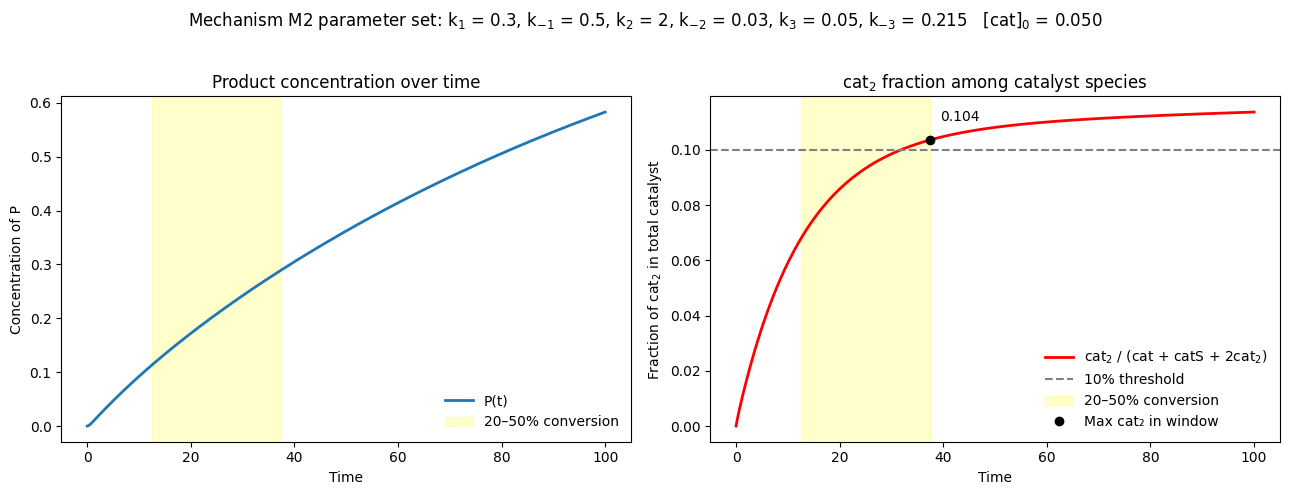

Filter result: Pass (cat₂ fraction exceeded 10% within the conversion window.)

Testing M2 with k3 = 0.0500, k_3 = 0.2200
Initial cat = 0.050, Max P = 0.582, Time window = [12.47, 37.42], Max cat₂ ratio in window = 0.105


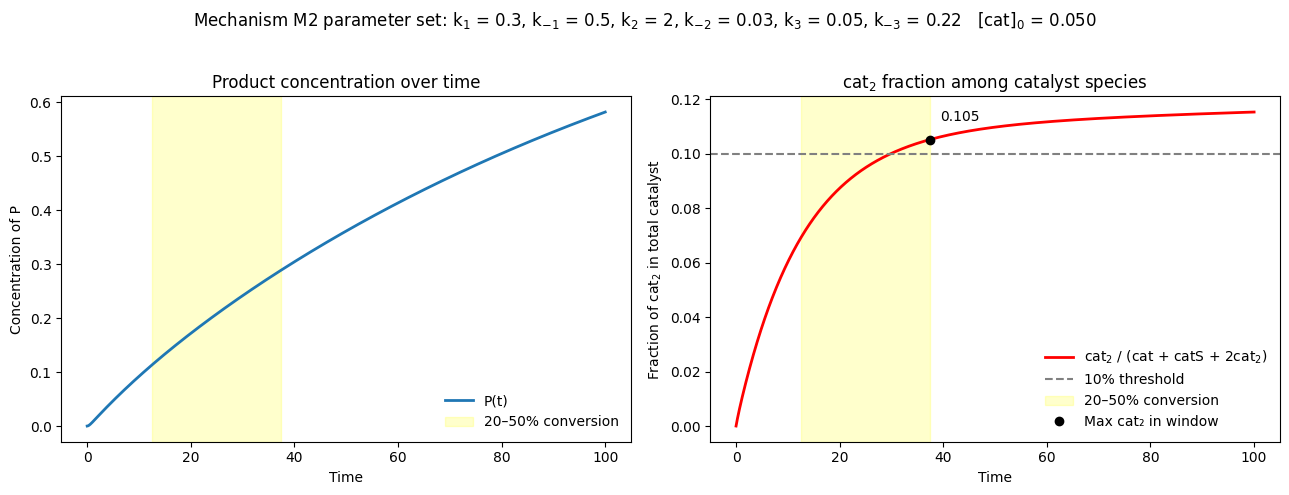

Filter result: Pass (cat₂ fraction exceeded 10% within the conversion window.)

Testing M2 with k3 = 0.0500, k_3 = 0.2250
Initial cat = 0.050, Max P = 0.580, Time window = [12.47, 37.42], Max cat₂ ratio in window = 0.107


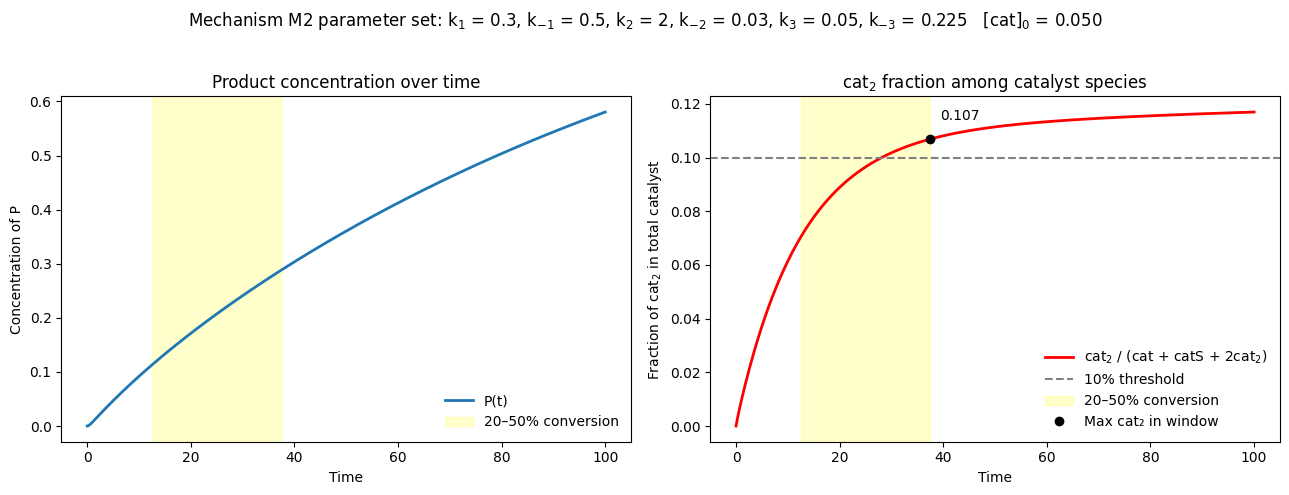

Filter result: Pass (cat₂ fraction exceeded 10% within the conversion window.)

Testing M2 with k3 = 0.0500, k_3 = 0.2300
Initial cat = 0.050, Max P = 0.579, Time window = [12.47, 37.42], Max cat₂ ratio in window = 0.108


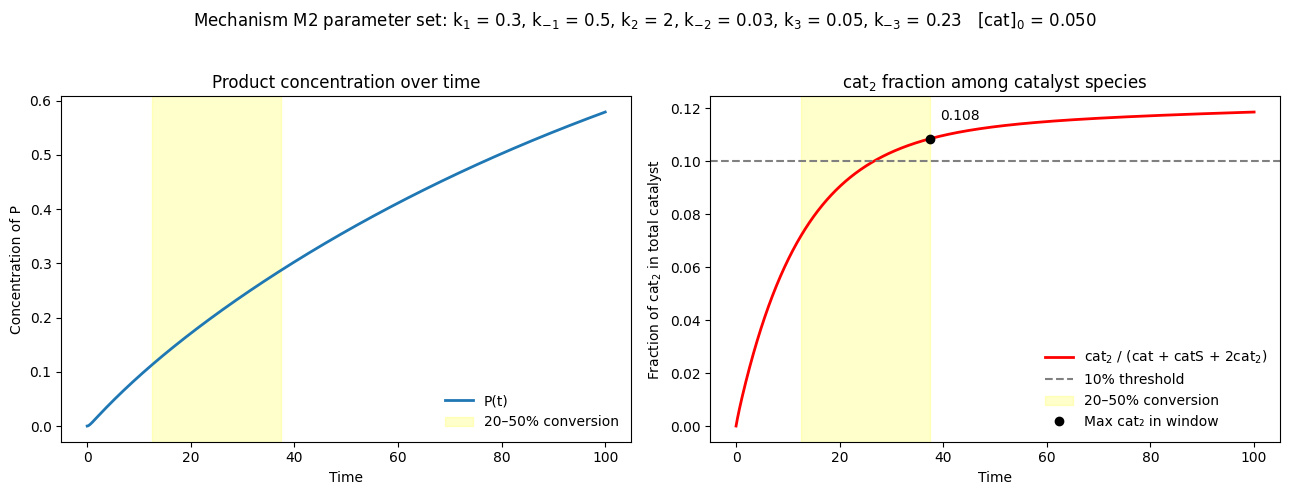

Filter result: Pass (cat₂ fraction exceeded 10% within the conversion window.)



In [7]:
def M2_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 0.0]

    try:
        sol = solve_ivp(lambda t, y: ode_M2(t, y, theta),
                        t_span=(0, 100),
                        y0=y0,
                        method='LSODA',
                        t_eval=np.linspace(0, 100, 1500),
                        rtol=1e-6,
                        atol=1e-9)
    except Exception as e:
        if verbose:
            print(f"ODE integration failed: {e}")
        return

    if not sol.success:
        if verbose:
            print("ODE integration was unsuccessful.")
        return

    t = sol.t
    y = sol.y
    S, P, cat, catS, cat2 = y

    P_max = np.max(P)

    if P_max < 0.5 * S0:
        if verbose:
            print(f"Filter result: Fail (maximum yield = {P_max:.3f} < 50% of S0)")
        return

    S_conv = (S0 - S) / (S0 - S[-1] + 1e-8)
    window = np.where((S_conv >= 0.2) & (S_conv <= 0.5))[0]

    if len(window) == 0:
        if verbose:
            print("No time points in the conversion window [20%, 50%].")
        return

    t_window = t[window]
    cat_total = cat + catS + 2 * cat2
    cat2_ratio = cat2 / (cat_total + 1e-10)
    ratio_window = cat2_ratio[window]
    max_ratio = np.max(ratio_window)
    passed = np.any(ratio_window > 0.1)

    if verbose:
        print(
            f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
            f"Time window = [{t_window[0]:.2f}, {t_window[-1]:.2f}], "
            f"Max cat₂ ratio in window = {max_ratio:.3f}"
        )

    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    axs[0].plot(t, P, label='P(t)', linewidth=2)
    axs[0].axvspan(t_window[0], t_window[-1], color='yellow', alpha=0.2, label='20–50% conversion')
    axs[0].set_title("Product concentration over time")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Concentration of P")
    axs[0].legend(frameon=False)

    axs[1].plot(t, cat2_ratio, label='cat$_2$ / (cat + catS + 2cat$_2$)', linewidth=2, color='red')
    axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold')
    axs[1].axvspan(t_window[0], t_window[-1], color='yellow', alpha=0.2, label='20–50% conversion')
    
    t_max = t[window[np.argmax(ratio_window)]]
    y_max = max_ratio
    axs[1].plot(t_max, y_max, 'ko', label='Max cat₂ in window')
    axs[1].text(t_max + 2, y_max + 0.007, f'{y_max:.3f}', color='black')

    axs[1].set_title("cat$_2$ fraction among catalyst species")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Fraction of cat$_2$ in total catalyst")
    axs[1].legend(frameon=False)

    param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_3$', 'k$_{-3}$']
    param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
    plt.suptitle(f"Mechanism M2 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    if verbose:
        if not passed:
            print("Filter result: Fail (cat₂ fraction did not exceed 10% within the conversion window.)\n")
        else:
            print("Filter result: Pass (cat₂ fraction exceeded 10% within the conversion window.)\n")

base_theta = [0.3, 0.5, 2.0, 0.03]

tested_k3_k3r_pairs = [
    (0.05, 0.215),
    (0.05, 0.22),
    (0.05, 0.225),  
    (0.05, 0.23),
]

for k3, k_3 in tested_k3_k3r_pairs:
    theta = np.array(base_theta + [k3, k_3])
    print(f"Testing M2 with k3 = {k3:.4f}, k_3 = {k_3:.4f}")
    M2_dimerization_criterion(theta)

In [8]:
def ode_M3(t, y, theta):
    S, P, cat, cat2, cat2S = y
    k1, k_1, k2, k_2, k3, k_3 = theta
    
    dS_dt = k_1 * cat2S - k1 * S * cat2
    dP_dt = k2 * cat2S - k_2 * cat2 * P
    dcat2_dt = (k_1 + k2) * cat2S + k3 * cat * cat - (k1 * S + k_2 * P + k_3) * cat2
    dcat2S_dt = (k1 * S + k_2 * P) * cat2 - (k_1 + k2) * cat2S
    dcat_dt = 2 * k_3 * cat2 - 2 * k3 * cat * cat
    return [dS_dt, dP_dt, dcat_dt, dcat2_dt, dcat2S_dt]

def train_inits_M3():
    cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M3():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row
    
def sample_theta_M3_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(-0.5, 1.0)
        k_1 = 10**np.random.uniform(-0.5, 1.0)
        k2 = 10**np.random.uniform(-0.5, 1.0)
        k_2 = 10**np.random.uniform(-0.5, 1.0)
        k3 = 10**np.random.uniform(-0.5, 0.5)
        k_3 = 10**np.random.uniform(-3.0, -1.3)
        thetas.append(round_sig([k1, k_1, k2, k_2, k3, k_3], sig=3))
    return np.array(thetas)

def M3_cat_post_filter(theta, ode_func):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 0.0]  
    
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 200)
    
    sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
    if (not sol.success) or np.any(np.isnan(sol.y)):
        return False

    for arr in sol.y:
        if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
            return False
        if np.max(arr) > 1.5 or np.min(arr) < -0.1:
            return False
        if np.max(np.abs(np.diff(arr))) > 0.7:    
            return False
        if np.any(np.abs(np.diff(arr, 2)) > 0.2): 
            return False

    S_traj = sol.y[0]
    cat_traj = sol.y[2]
    cat2_traj = sol.y[3]
    cat2S_traj = sol.y[4]
    S_start = S_traj[0]
    S_end = S_traj[-1]
    S_conv = (S_start - S_traj) / (S_start - S_end + 1e-10)

    window = np.where(S_conv < 0.1)[0]
    if len(window) == 0:
        return False

    cat_total = cat_traj[window] + 2 * cat2_traj[window] + cat2S_traj[window]
    cat_frac = cat_traj[window] / (cat_total + 1e-12)
    if np.any(cat_frac > 0.05):
        return True
    return False

ODE_FUNCS["M3"] = ode_M3
TRAIN_INIT_FUNCS["M3"] = train_inits_M3
TEST_INIT_FUNCS["M3"] = test_inits_M3
MECH_DIM["M3"] = 5
THETA_DIM["M3"] = 6
POST_FILTER_FUNCS["M3"] = M3_cat_post_filter
BIASED_SAMPLE_FUNCS["M3"] = sample_theta_M3_biased

In [9]:
def test_mechanism_M3():
    mechanism = "M3"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M3...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M3.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M3...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M3:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M3 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M3()

Identifying valid kinetic parameter sets for mechanism M3...
Successfully identified 5 valid kinetic parameter sets for mechanism M3.
  Parameter set 1: [7.79, 1.02, 1.07, 0.421, 2.15, 0.00541]
  Parameter set 2: [2.56, 4.51, 2.56, 0.405, 0.349, 0.00377]
  Parameter set 3: [1.19, 0.503, 5.54, 1.03, 1.05, 0.0119]
  Parameter set 4: [7.43, 0.585, 0.747, 3.75, 0.412, 0.0116]
  Parameter set 5: [3.83, 1.34, 6.5, 0.911, 0.408, 0.0347]

Generating training, validation, and test datasets for mechanism M3...

Summary of data generation for mechanism M3:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M3 completed successfully.


Testing M3 with k3 = 3.000, k_3 = 0.010
Initial cat = 0.050, Max P = 0.687, Time window = [0.00, 10.34], Max cat fraction in window = 1.000


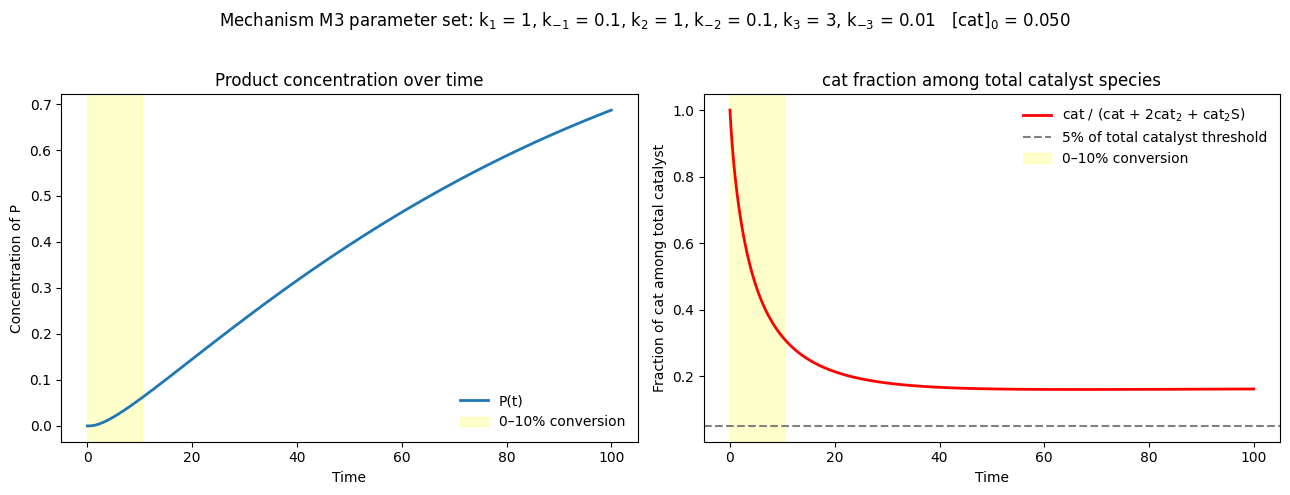

Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)

Testing M3 with k3 = 3.000, k_3 = 0.010
Initial cat = 0.050, Max P = 0.687, Time window = [0.00, 10.34], Max cat fraction in window = 1.000


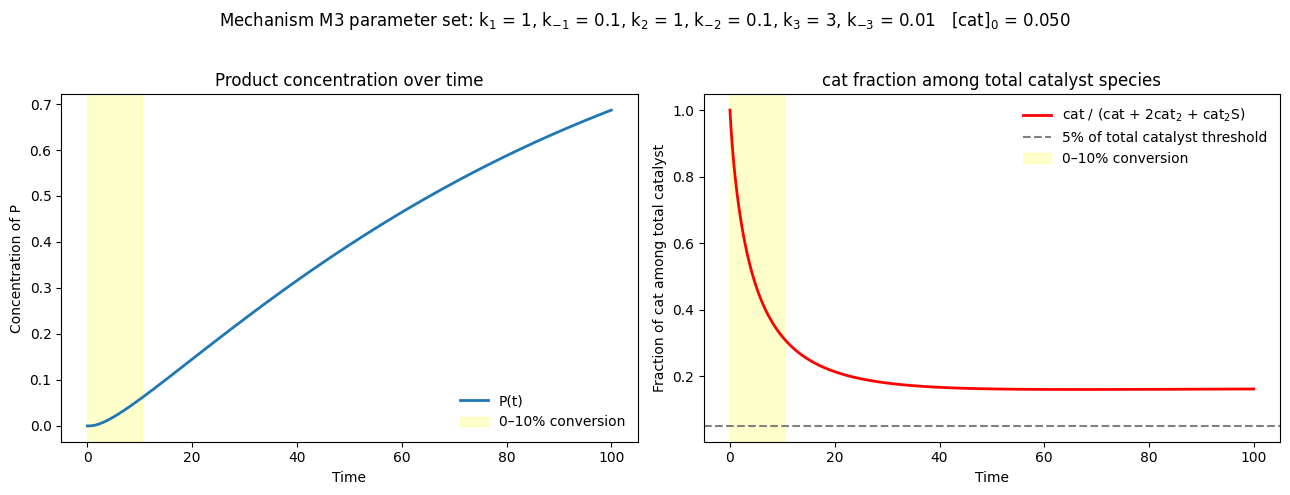

Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)

Testing M3 with k3 = 0.300, k_3 = 0.001
Initial cat = 0.050, Max P = 0.508, Time window = [0.00, 19.61], Max cat fraction in window = 1.000


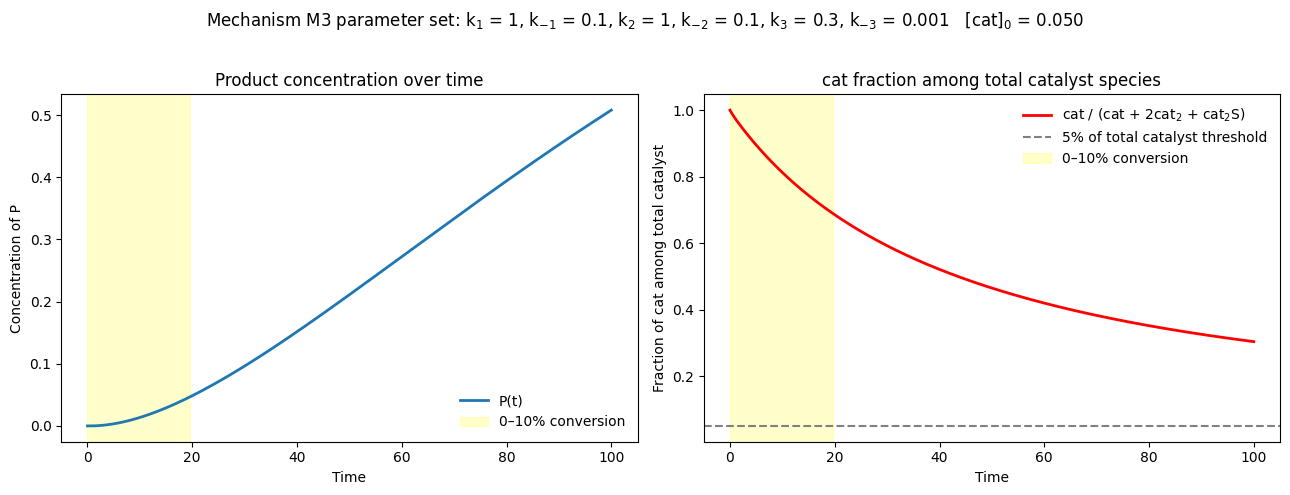

Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)

Testing M3 with k3 = 0.500, k_3 = 0.010
Initial cat = 0.050, Max P = 0.538, Time window = [0.00, 16.61], Max cat fraction in window = 1.000


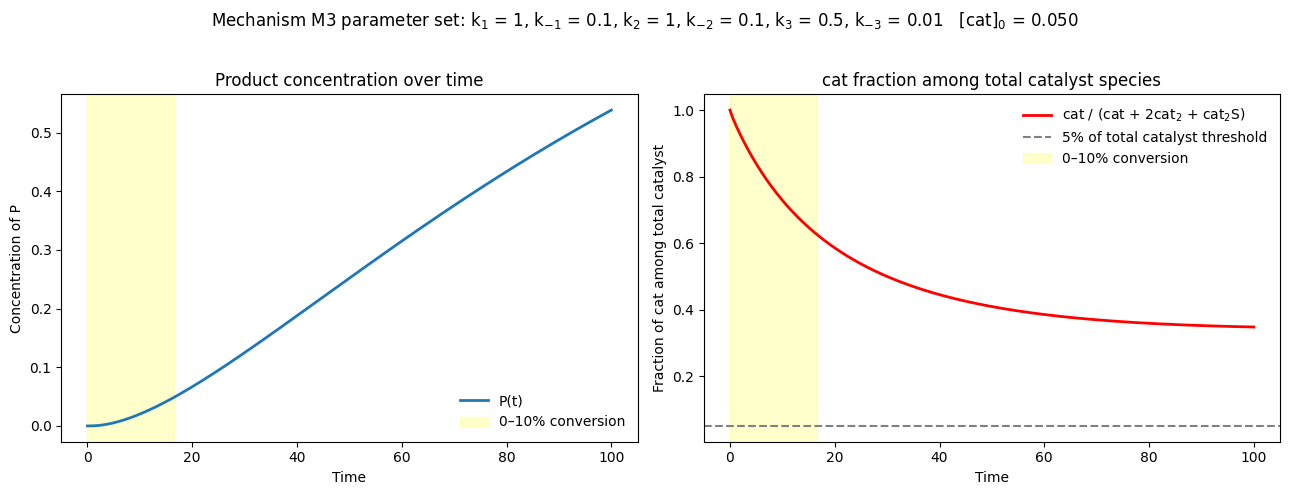

Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)

Testing M3 with k3 = 1.000, k_3 = 0.030
Initial cat = 0.050, Max P = 0.557, Time window = [0.00, 13.21], Max cat fraction in window = 1.000


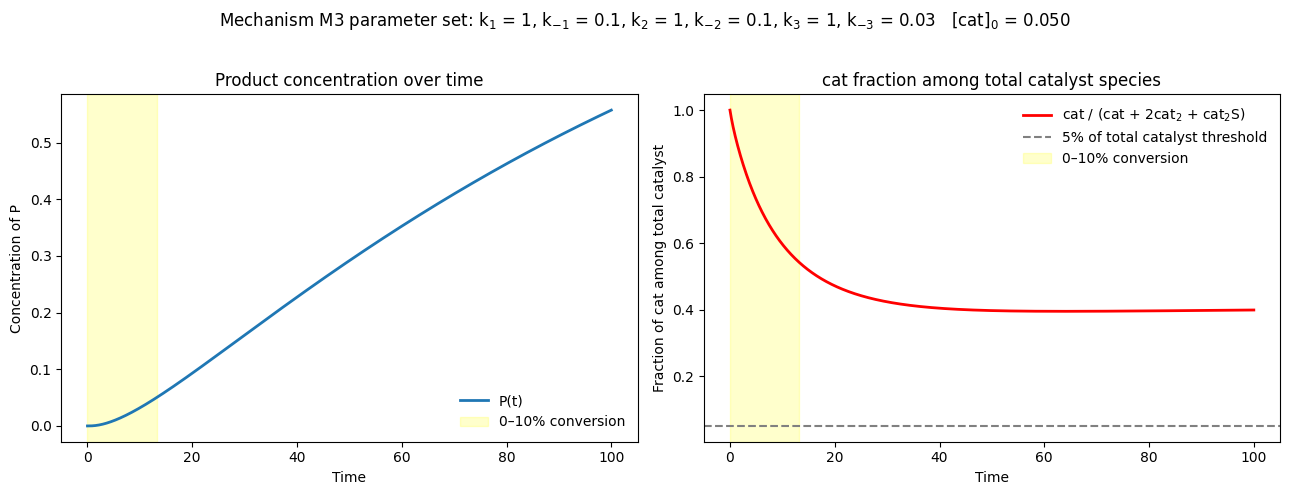

Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)



In [10]:
def M3_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 0.0]

    try:
        sol = solve_ivp(lambda t, y: ode_M3(t, y, theta),
                        t_span=(0, 100),
                        y0=y0,
                        method='LSODA',
                        t_eval=np.linspace(0, 100, 1500),
                        rtol=1e-6,
                        atol=1e-9)
    except Exception as e:
        if verbose:
            print(f"ODE integration failed: {e}")
        return

    if not sol.success:
        if verbose:
            print("ODE integration was unsuccessful.")
        return

    t = sol.t
    S, P, cat, cat2, cat2S = sol.y

    P_max = np.max(P)
    if P_max < 0.5 * S0:
        if verbose:
            print(f"Filter result: Fail (maximum yield = {P_max:.3f} < 50% of S₀)")
        return

    S_conv = (S0 - S) / (S0 - S[-1] + 1e-8)
    window = np.where(S_conv < 0.1)[0]
    if len(window) == 0:
        if verbose:
            print("No time points in the conversion window [0%, 10%].")
        return

    t_window = t[window]
    cat_total = cat + 2*cat2 + cat2S
    cat_frac_full = cat / (cat_total + 1e-12)
    cat_frac_window = cat[window] / (cat_total[window] + 1e-12)
    max_cat_frac = np.max(cat_frac_window)
    passed = np.any(cat_frac_window > 0.05)

    if verbose:
        print(
            f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
            f"Time window = [{t_window[0]:.2f}, {t_window[-1]:.2f}], "
            f"Max cat fraction in window = {max_cat_frac:.3f}"
        )

    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    axs[0].plot(t, P, label='P(t)', linewidth=2)
    axs[0].axvspan(t_window[0], t_window[-1], color='yellow', alpha=0.2, label='0–10% conversion')
    axs[0].set_title("Product concentration over time")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Concentration of P")
    axs[0].legend(frameon=False)

    axs[1].plot(t, cat_frac_full, label='cat / (cat + 2cat$_2$ + cat$_2$S)', linewidth=2, color='red')
    axs[1].axhline(0.05, linestyle='--', color='gray', label='5% of total catalyst threshold')
    axs[1].axvspan(t_window[0], t_window[-1], color='yellow', alpha=0.2, label='0–10% conversion')
    axs[1].set_title("cat fraction among total catalyst species")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Fraction of cat among total catalyst")
    axs[1].legend(frameon=False)

    param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_3$', 'k$_{-3}$']
    param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
    plt.suptitle(f"Mechanism M3 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    if verbose:
        if not passed:
            print("Filter result: Fail (cat fraction did not exceed 5% within the initial conversion window.)\n")
        else:
            print("Filter result: Pass (cat fraction exceeded 5% within the initial conversion window.)\n")

base_theta = [1.0, 0.1, 1.0, 0.1]
tested_k3_k3r_pairs = [
    (3.0, 0.01),  
    (3.0, 0.01),
    (0.3, 0.001),
    (0.5, 0.01),
    (1.0, 0.03),
]

for k3, k_3 in tested_k3_k3r_pairs:
    theta = np.array(base_theta + [k3, k_3])
    print(f"Testing M3 with k3 = {k3:.3f}, k_3 = {k_3:.3f}")
    M3_dimerization_criterion(theta)

In [11]:
def ode_M4(t, y, theta):
    S, P, cat, catS, X = y
    k1, k_1, k2, k_2 = theta
    
    dS_dt = k_1 * X * catS - k1 * S * cat
    dP_dt = k2 * X * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * X * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * X * catS
    dX_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * X * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dX_dt]

def train_inits_M4():
    cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0])
    return inits

def test_inits_M4():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 1.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M4_biased(n=1):
    thetas = []
    for _ in range(n):
        k1  = np.random.uniform(0.3, 1.0)
        k_1 = np.random.uniform(0.02, 0.08)
        k2  = np.random.uniform(1.0, 3.0)
        k_2 = np.random.uniform(0.02, 0.08)
        thetas.append(round_sig([k1, k_1, k2, k_2], sig=3))
    return thetas

def M4_profile_post_filter(theta, ode_func):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 1.0]  
    
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 200)
    
    sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
    if (not sol.success) or np.any(np.isnan(sol.y)):
        return False
        
    S = sol.y[0]
    P = sol.y[1]

    if np.any(np.isnan(S)) or np.any(np.isnan(P)):
        return False
    if np.any(S < -1e-4) or np.any(P < -1e-4):
        return False
    if np.max(S) - np.min(S) < 0.05 or np.max(P) - np.min(P) < 0.05:
        return False
    if np.any(np.abs(np.diff(S, 2)) > 0.2) or np.any(np.abs(np.diff(P, 2)) > 0.2):
        return False
    if np.max(np.abs(np.diff(S))) > 0.7 or np.max(np.abs(np.diff(P))) > 0.7:
        return False
    if np.max(S) > 1.5 or np.max(P) > 1.5:
        return False
    return (np.abs(S[-1] - S[0]) > 0.2) or (np.abs(P[-1] - P[0]) > 0.2)

ODE_FUNCS["M4"] = ode_M4
TRAIN_INIT_FUNCS["M4"] = train_inits_M4
TEST_INIT_FUNCS["M4"] = test_inits_M4
MECH_DIM["M4"] = 5
THETA_DIM["M4"] = 4
POST_FILTER_FUNCS["M4"] = M4_profile_post_filter
BIASED_SAMPLE_FUNCS["M4"] = sample_theta_M4_biased

In [12]:
def test_mechanism_M4():
    mechanism = "M4"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M4...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M4.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M4...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M4:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M4 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M4()

Identifying valid kinetic parameter sets for mechanism M4...
Successfully identified 5 valid kinetic parameter sets for mechanism M4.
  Parameter set 1: [0.93, 0.0338, 1.22, 0.046]
  Parameter set 2: [0.416, 0.0418, 1.53, 0.068]
  Parameter set 3: [0.679, 0.0522, 1.64, 0.0282]
  Parameter set 4: [0.303, 0.0233, 1.15, 0.0606]
  Parameter set 5: [0.444, 0.0376, 2.06, 0.0344]

Generating training, validation, and test datasets for mechanism M4...

Summary of data generation for mechanism M4:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M4 completed successfully.


In [13]:
def ode_M5(t, y, theta):
    S, P, cat, catS, catP = y
    k1, k_1, k2, k_2, k3, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k3 * catP - k_3 * cat * P
    dcat_dt = k_1 * catS + k3 * catP - (k1 * S + k_3 * P) * cat
    dcatS_dt = (k1 * S + k_2 * catP) * cat - (k_1 + k2 * cat) * catS
    dcatP_dt = k2 * catS * cat + k_3 * P * cat - (k3 + k_2 * cat) * catP
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dcatP_dt]

def train_inits_M5():
    cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M5():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M5_biased(n=1):
    thetas = []
    for _ in range(n):
        k1  = np.random.uniform(0.50, 0.65)
        k_1 = np.random.uniform(0.06, 0.10)
        k2  = np.random.uniform(10.0, 12.0)
        k_2 = np.random.uniform(0.045, 0.09)
        k3  = np.random.uniform(1.0, 1.4)
        k_3 = np.random.uniform(0.018, 0.075)
        theta = [k1, k_1, k2, k_2, k3, k_3]
        thetas.append(round_sig(theta, sig=3))
    return thetas

def M5_profile_post_filter(theta, ode_func):
    S0 = 1.0
    P0 = 0.0
    cat0 = 0.05
    y0 = [S0, P0, cat0, 0.0, 0.0]  
    
    t_span = (0, 100)
    t_eval = np.linspace(0, 100, 200)
    
    sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
    if (not sol.success) or np.any(np.isnan(sol.y)):
        return False
        
    for arr in sol.y:
        if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
            return False
        if np.max(arr) > 1.5 or np.min(arr) < -0.1:
            return False
        if np.max(np.abs(np.diff(arr))) > 0.7:
            return False
        if np.any(np.abs(np.diff(arr, 2)) > 0.2):
            return False
            
    S = sol.y[0]
    P = sol.y[1]
    return (np.abs(S[-1] - S[0]) > 0.2) or (np.abs(P[-1] - P[0]) > 0.2)

ODE_FUNCS["M5"] = ode_M5
TRAIN_INIT_FUNCS["M5"] = train_inits_M5
TEST_INIT_FUNCS["M5"] = test_inits_M5
MECH_DIM["M5"] = 5
THETA_DIM["M5"] = 6
POST_FILTER_FUNCS["M5"] = M5_profile_post_filter
BIASED_SAMPLE_FUNCS["M5"] = sample_theta_M5_biased

In [14]:
def test_mechanism_M5():
    mechanism = "M5"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M5...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M5.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M5...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M5:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M5 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M5()

Identifying valid kinetic parameter sets for mechanism M5...
Successfully identified 5 valid kinetic parameter sets for mechanism M5.
  Parameter set 1: [0.531, 0.0822, 10.3, 0.0619, 1.1, 0.0533]
  Parameter set 2: [0.531, 0.0755, 11.3, 0.0861, 1.09, 0.0186]
  Parameter set 3: [0.615, 0.0878, 11.6, 0.0694, 1.21, 0.0555]
  Parameter set 4: [0.542, 0.0809, 11.9, 0.0882, 1.28, 0.0281]
  Parameter set 5: [0.639, 0.0998, 11.2, 0.063, 1, 0.0243]

Generating training, validation, and test datasets for mechanism M5...

Summary of data generation for mechanism M5:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M5 completed successfully.


In [15]:
def ode_M6(t, y, theta):
    S, P, cat, cat_star, cat_starS = y
    k1, k_1, k2, k_2, k3 = theta
    
    dS_dt = k_1 * cat_starS - k1 * S * cat_star
    dP_dt = k2 * cat_starS - k_2 * P * cat_star
    dcat_dt = -k3 * cat
    dcat_star_dt = k3 * cat + (k_1 + k2) * cat_starS - (k1 * S + k_2 * P) * cat_star
    dcat_starS_dt = (k1 * S + k_2 * P) * cat_star - (k_1 + k2) * cat_starS
    return [dS_dt, dP_dt, dcat_dt, dcat_star_dt, dcat_starS_dt]

def train_inits_M6():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M6():
    cat0s = [
        np.random.uniform(0.01, 0.02),    
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M6_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(-0.2, 1.0)
        k_1 = 10**np.random.uniform(-0.5, 0.5)
        k2 = 10**np.random.uniform(0.3, 1.0)
        k_2 = 10**np.random.uniform(-1.3, -0.3)
        k3 = 10**np.random.uniform(-2.0, -0.7)
        thetas.append(round_sig([k1, k_1, k2, k_2, k3], sig=3))
    return np.array(thetas)

def M6_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0] 
        
        t_span = (0, 100)
        t_eval = np.linspace(0, 100, 200)
        
        sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
        if (not sol.success) or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        S_traj = sol.y[0]
        cat_star_traj = sol.y[3]
        cat_starS_traj = sol.y[4]
        S_start = S_traj[0]
        S_end = S_traj[-1]
        S_conv = (S_start - S_traj) / (S_start - S_end + 1e-10)
        idx_20 = np.argmin(np.abs(S_conv - 0.2))
        if np.abs(S_conv[idx_20] - 0.2) > 0.01:
            continue
        active_cat = cat_star_traj[idx_20] + cat_starS_traj[idx_20]
        if 0.1 * cat0 <= active_cat <= 0.9 * cat0:
            return True
    return False

ODE_FUNCS["M6"] = ode_M6
TRAIN_INIT_FUNCS["M6"] = train_inits_M6
TEST_INIT_FUNCS["M6"] = test_inits_M6
MECH_DIM["M6"] = 5
THETA_DIM["M6"] = 5
POST_FILTER_FUNCS["M6"] = M6_activecat_post_filter
BIASED_SAMPLE_FUNCS["M6"] = sample_theta_M6_biased

In [16]:
def test_mechanism_M6():
    mechanism = "M6"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M6...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M6.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M6...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M6:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M6 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M6()

Identifying valid kinetic parameter sets for mechanism M6...
Successfully identified 5 valid kinetic parameter sets for mechanism M6.
  Parameter set 1: [0.929, 0.323, 6.77, 0.128, 0.0109]
  Parameter set 2: [0.913, 1.18, 5.18, 0.0672, 0.177]
  Parameter set 3: [5.71, 2.68, 2.67, 0.0606, 0.0171]
  Parameter set 4: [0.874, 1.29, 9.3, 0.0659, 0.149]
  Parameter set 5: [0.886, 3.12, 3.61, 0.415, 0.0463]

Generating training, validation, and test datasets for mechanism M6...

Summary of data generation for mechanism M6:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M6 completed successfully.


Testing M6 with k3 = 0.010
Initial cat = 0.030, Max P = 0.586, Time at 20% conversion = 34.62, Active cat fraction = 0.293


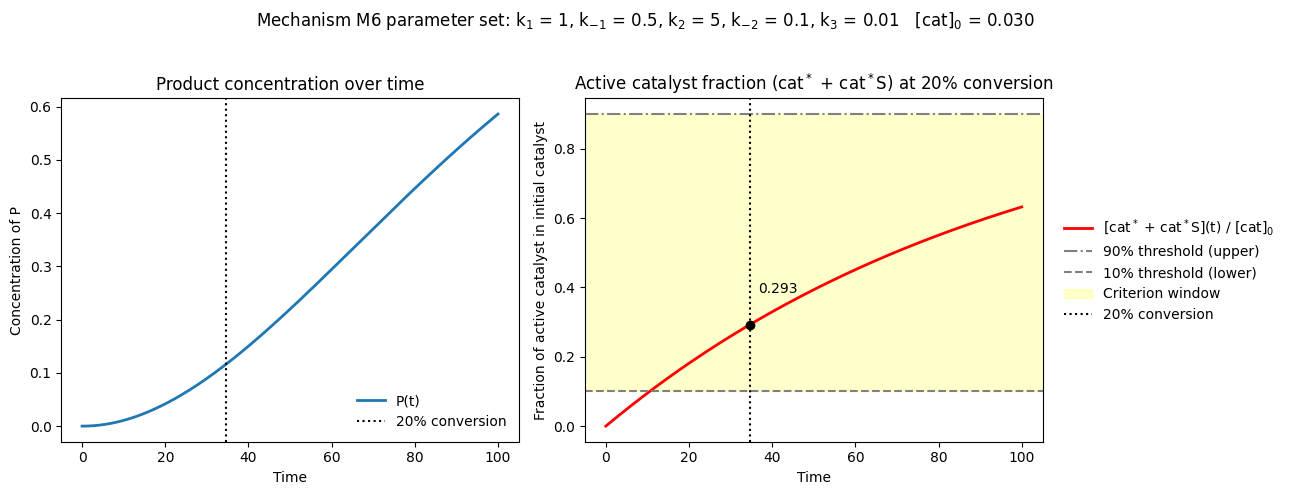

Filter result: Pass (active catalyst fraction in [10%, 90%] at 20% conversion.)

Testing M6 with k3 = 0.050
Initial cat = 0.030, Max P = 0.858, Time at 20% conversion = 21.08, Active cat fraction = 0.651


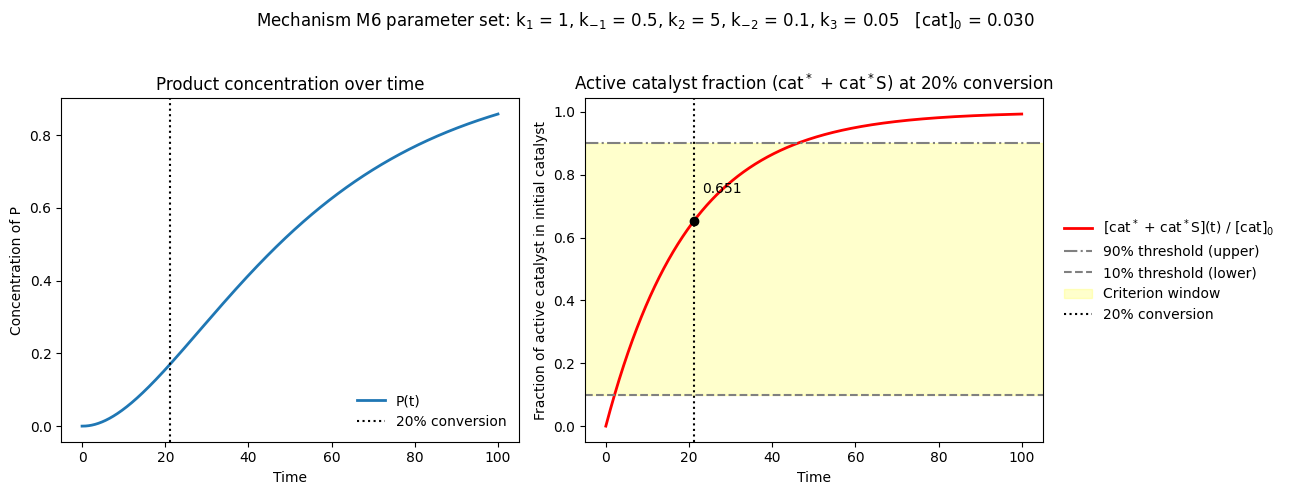

Filter result: Pass (active catalyst fraction in [10%, 90%] at 20% conversion.)

Testing M6 with k3 = 0.100
Initial cat = 0.030, Max P = 0.889, Time at 20% conversion = 16.41, Active cat fraction = 0.806


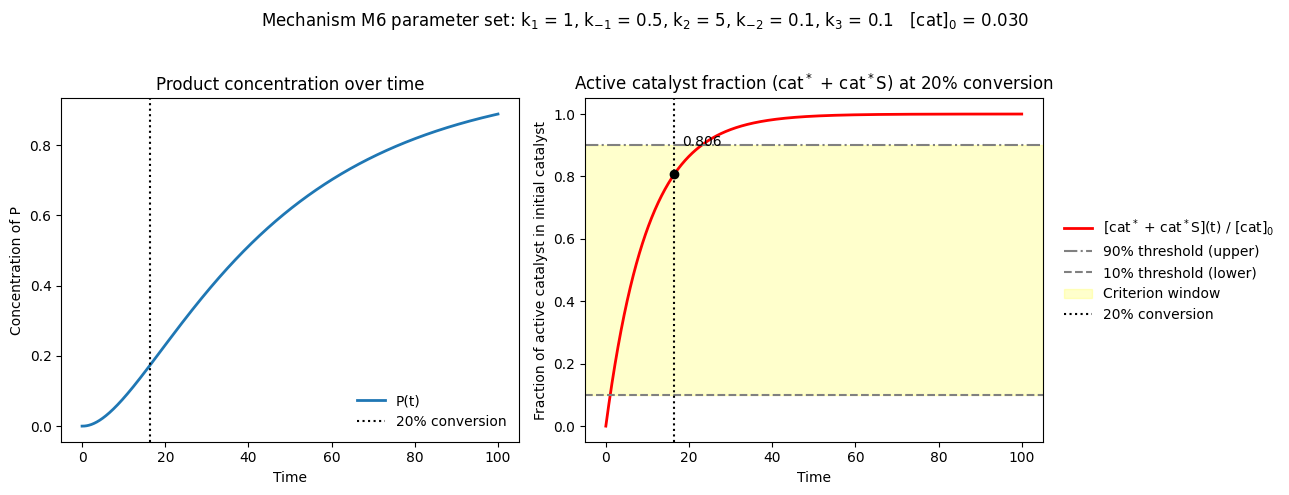

Filter result: Pass (active catalyst fraction in [10%, 90%] at 20% conversion.)

Testing M6 with k3 = 0.200
Initial cat = 0.040, Max P = 0.951, Time at 20% conversion = 11.21, Active cat fraction = 0.894


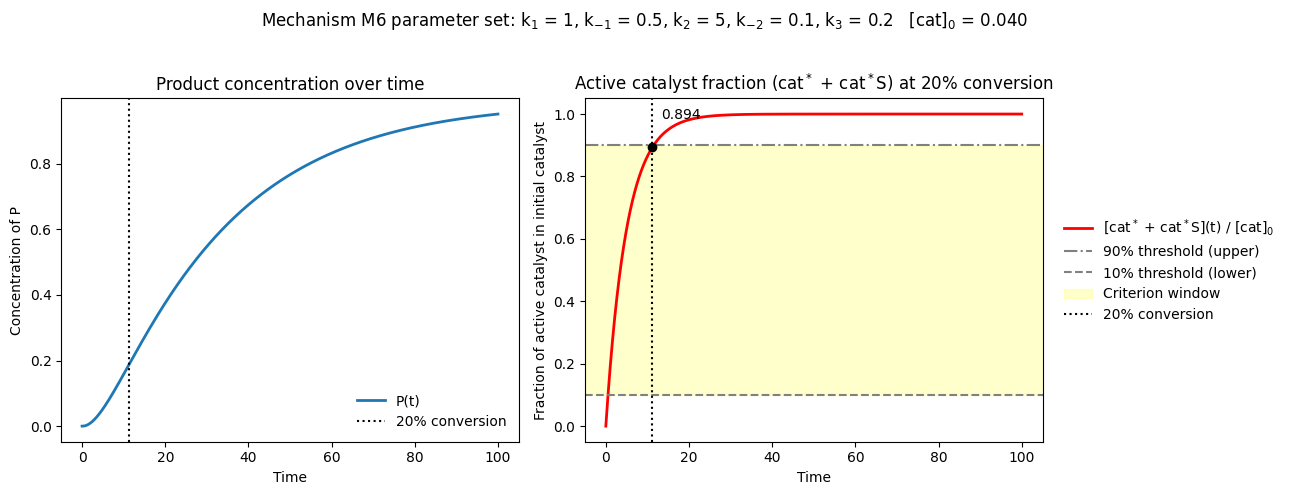

Filter result: Pass (active catalyst fraction in [10%, 90%] at 20% conversion.)

Testing M6 with k3 = 0.500
Filter result: Fail (no initial catalyst concentration in [0.03, 0.07] satisfied the criterion.)



In [18]:
def M6_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5) 

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M6(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for [cat]$_0$ = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for [cat]$_0$ = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, cat_star, cat_starS = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        S_conv = (S0 - S) / (S0 - S[-1] + 1e-8)
        idx_20 = np.argmin(np.abs(S_conv - 0.2))

        if np.abs(S_conv[idx_20] - 0.2) > 0.01:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → No time point sufficiently close to 20% conversion.")
            continue

        t_20 = t[idx_20]
        active_cat = cat_star[idx_20] + cat_starS[idx_20]
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.1 <= active_frac <= 0.9

        if passed:
            if verbose:
                print(
                    f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                    f"Time at 20% conversion = {t_20:.2f}, "
                    f"Active cat fraction = {active_frac:.3f}"
                )

                fig, axs = plt.subplots(1, 2, figsize=(13, 5))

                axs[0].plot(t, P, label='P(t)', linewidth=2)
                axs[0].axvline(t_20, linestyle=':', color='black', label='20% conversion')
                axs[0].set_title("Product concentration over time")
                axs[0].set_xlabel("Time")
                axs[0].set_ylabel("Concentration of P")
                axs[0].legend(frameon=False)

                axs[1].plot(t, (cat_star + cat_starS) / (cat0 + 1e-10),
                            label=r'[cat$^*$ + cat$^*$S](t) / [cat]$_0$', color='red', linewidth=2)
                axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
                axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold (lower)')
                axs[1].axhspan(0.1, 0.9, color='yellow', alpha=0.2, label='Criterion window')
                axs[1].plot(t_20, active_frac, 'ko')
                axs[1].text(t_20 + 2, active_frac + 0.09, f'{active_frac:.3f}', color='black')
                axs[1].axvline(t_20, linestyle=':', color='black', label='20% conversion')
                axs[1].set_title("Active catalyst fraction (cat$^*$ + cat$^*$S) at 20% conversion")
                axs[1].set_xlabel("Time")
                axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
                axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

                param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_3$']
                param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
                plt.suptitle(f"Mechanism M6 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

                print("Filter result: Pass (active catalyst fraction in [10%, 90%] at 20% conversion.)\n")
            return True

    if verbose:
        print("Filter result: Fail (no initial catalyst concentration in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.5, 5.0, 0.1]

k3_list = [0.01, 0.05, 0.1, 0.2, 0.5]
for k3 in k3_list:
    theta = np.array(base_theta + [k3])
    print(f"Testing M6 with k3 = {k3:.3f}")
    M6_dimerization_criterion(theta)

In [21]:
def ode_M7(t, y, theta):
    S, P, cat, catS, catS2 = y
    k1, k_1, k2, k_2, k3, k_3 = theta
    
    dS_dt = k_1 * catS2 - k1 * S * catS + k_3 * catS - k3 * S * cat
    dP_dt = k2 * catS2 - k_2 * catS * P
    dcat_dt = k_3 * catS - k3 * S * cat
    dcatS_dt = k3 * S * cat - k_3 * catS + (k_1 + k2) * catS2 - (k1 * S + k_2 * P) * catS
    dcatS2_dt = (k1 * S + k_2 * P) * catS - (k_1 + k2) * catS2
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dcatS2_dt]

def train_inits_M7():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M7():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M7_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(-0.2, 1.0)
        k_1 = 10**np.random.uniform(-0.5, 0.5)
        k2 = 10**np.random.uniform(0.3, 1.0)
        k_2 = 10**np.random.uniform(-1.3, -0.3)
        k3 = 10**np.random.uniform(-2.0, -1.0)
        k_3 = 10**np.random.uniform(-3.0, -1.5)
        thetas.append(round_sig([k1, k_1, k2, k_2, k3, k_3], sig=3))
    return np.array(thetas)

def M7_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]  
        
        t_span = (0, 100)
        t_eval = np.linspace(0, 100, 100)
        
        sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
        if (not sol.success) or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        S_traj = sol.y[0]
        catS_traj = sol.y[3]
        catS2_traj = sol.y[4]
        S_start = S_traj[0]
        S_end = S_traj[-1]
        S_conv = (S_start - S_traj) / (S_start - S_end + 1e-10)
        idx_20 = np.argmin(np.abs(S_conv - 0.2))
        if np.abs(S_conv[idx_20] - 0.2) > 0.01:
            continue
        active_cat = catS_traj[idx_20] + catS2_traj[idx_20]
        if 0.1 * cat0 <= active_cat <= 0.8 * cat0:
            return True
    return False

ODE_FUNCS["M7"] = ode_M7
TRAIN_INIT_FUNCS["M7"] = train_inits_M7
TEST_INIT_FUNCS["M7"] = test_inits_M7
MECH_DIM["M7"] = 5
THETA_DIM["M7"] = 6
POST_FILTER_FUNCS["M7"] = M7_activecat_post_filter
BIASED_SAMPLE_FUNCS["M7"] = sample_theta_M7_biased

In [22]:
def test_mechanism_M7():
    mechanism = "M7"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M7...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M7.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M7...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M7:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M7 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M7()

Identifying valid kinetic parameter sets for mechanism M7...
Successfully identified 5 valid kinetic parameter sets for mechanism M7.
  Parameter set 1: [1.31, 2.08, 3.82, 0.227, 0.0289, 0.0206]
  Parameter set 2: [0.661, 0.563, 4.08, 0.0594, 0.0348, 0.00144]
  Parameter set 3: [7.4, 0.544, 4.51, 0.0702, 0.0751, 0.00119]
  Parameter set 4: [6.08, 0.637, 2.61, 0.0535, 0.0104, 0.00323]
  Parameter set 5: [8.57, 0.76, 3.06, 0.44, 0.0433, 0.00404]

Generating training, validation, and test datasets for mechanism M7...

Summary of data generation for mechanism M7:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M7 completed successfully.


Testing M7 with k3 = 0.010, k_3 = 0.001
Initial cat = 0.030, Max P = 0.534, Time at 20% conversion = 32.62, Active cat fraction = 0.265


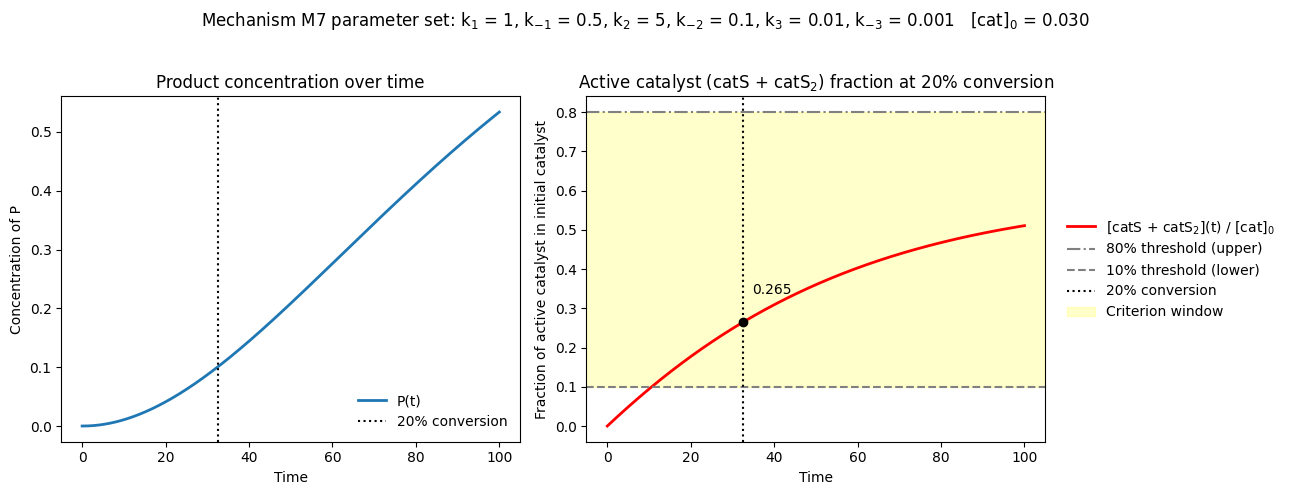

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.010, k_3 = 0.010
Initial catalyst concentration = 0.030 → Fail (max yield = 0.461 < 50%)
Initial cat = 0.040, Max P = 0.550, Time at 20% conversion = 29.42, Active cat fraction = 0.218


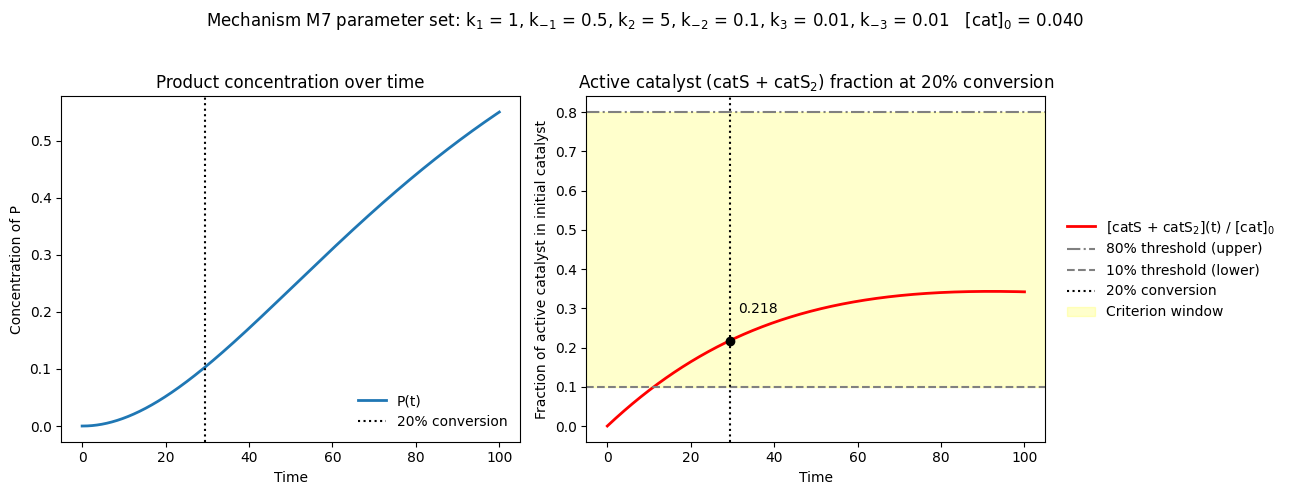

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.010, k_3 = 0.030
Initial catalyst concentration = 0.030 → Fail (max yield = 0.348 < 50%)
Initial catalyst concentration = 0.040 → Fail (max yield = 0.424 < 50%)
Initial catalyst concentration = 0.050 → Fail (max yield = 0.487 < 50%)
Initial cat = 0.060, Max P = 0.541, Time at 20% conversion = 24.88, Active cat fraction = 0.158


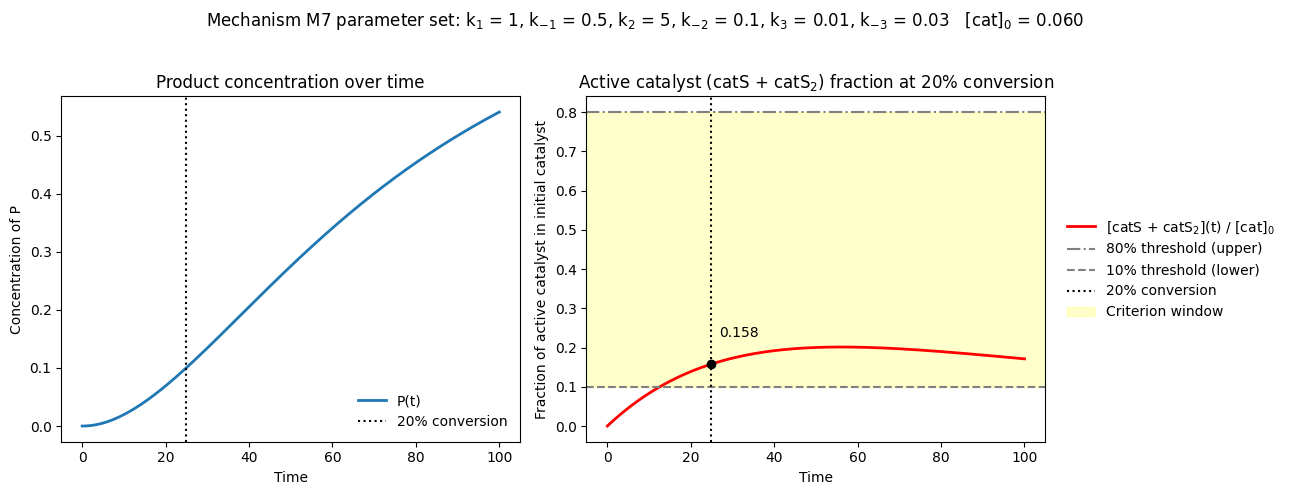

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.050, k_3 = 0.001
Initial cat = 0.030, Max P = 0.812, Time at 20% conversion = 19.81, Active cat fraction = 0.599


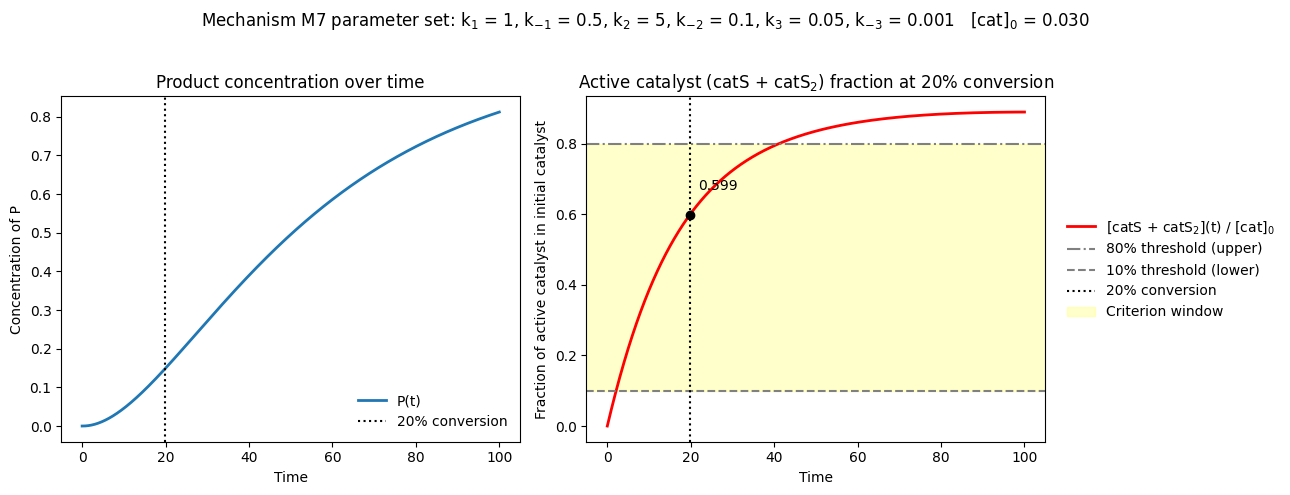

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.050, k_3 = 0.010
Initial cat = 0.030, Max P = 0.763, Time at 20% conversion = 19.41, Active cat fraction = 0.556


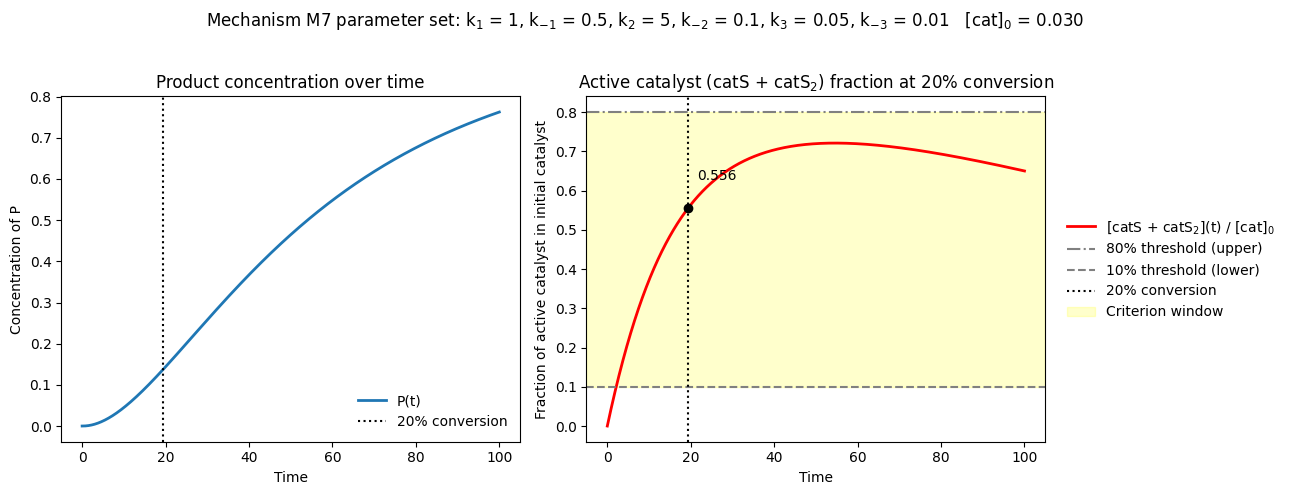

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.050, k_3 = 0.030
Initial cat = 0.030, Max P = 0.668, Time at 20% conversion = 18.75, Active cat fraction = 0.480


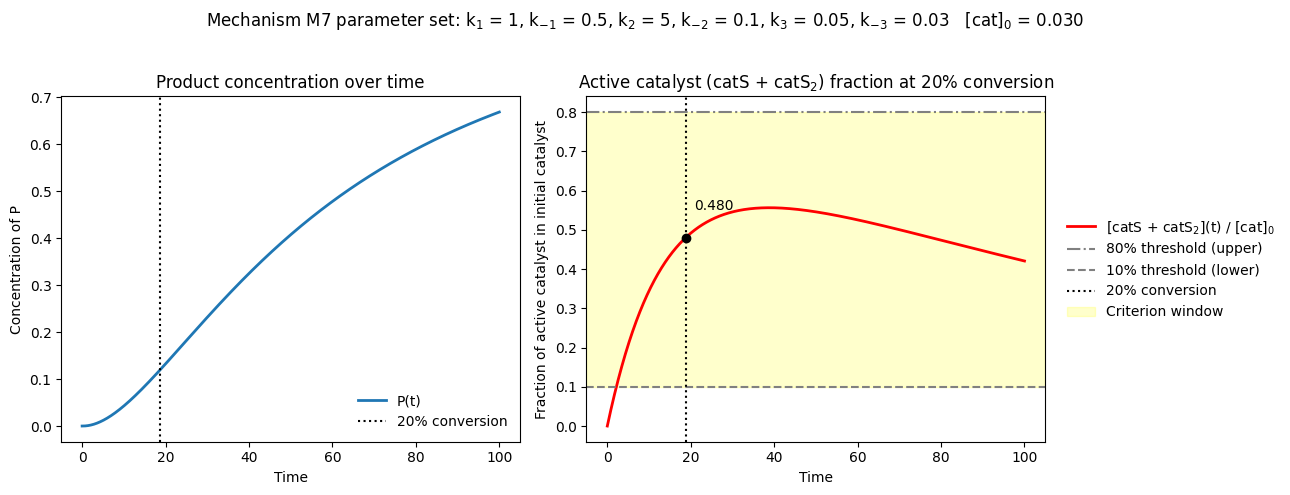

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.100, k_3 = 0.001
Initial cat = 0.030, Max P = 0.854, Time at 20% conversion = 15.28, Active cat fraction = 0.753


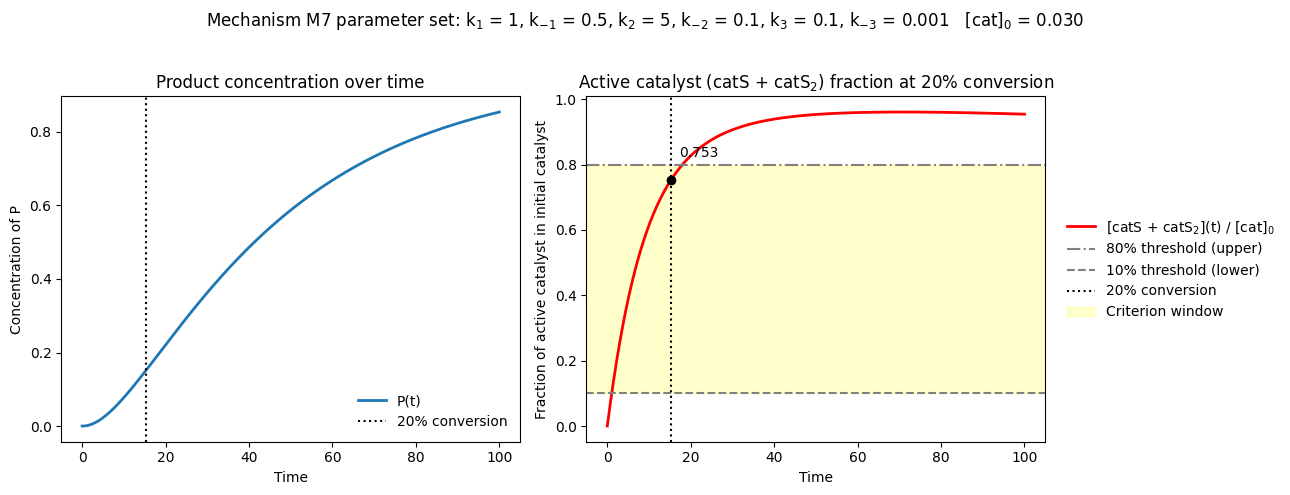

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.100, k_3 = 0.010
Initial cat = 0.030, Max P = 0.821, Time at 20% conversion = 15.08, Active cat fraction = 0.716


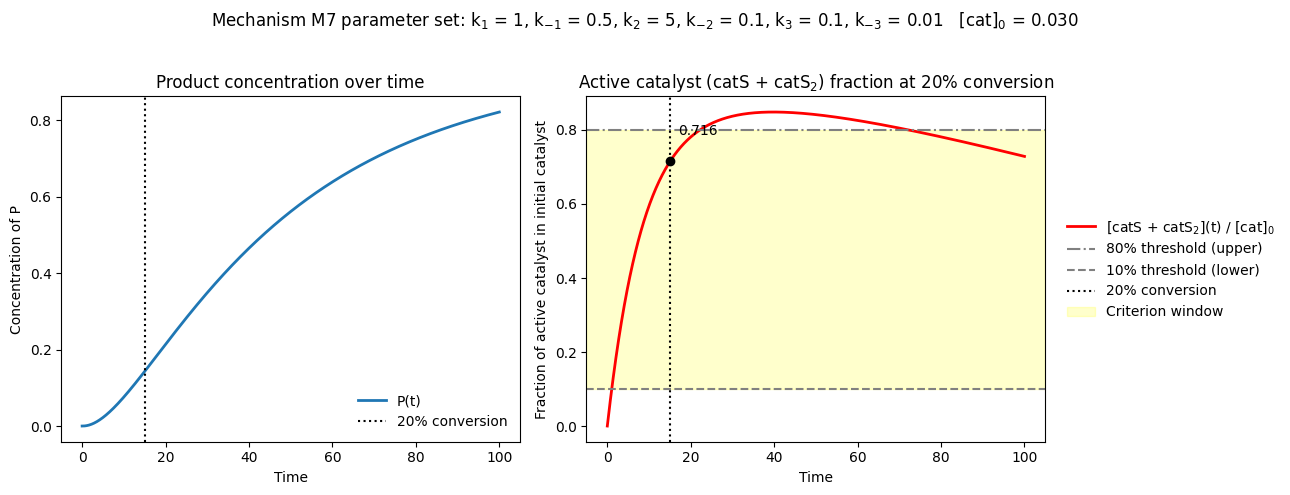

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)

Testing M7 with k3 = 0.100, k_3 = 0.030
Initial cat = 0.030, Max P = 0.756, Time at 20% conversion = 14.81, Active cat fraction = 0.646


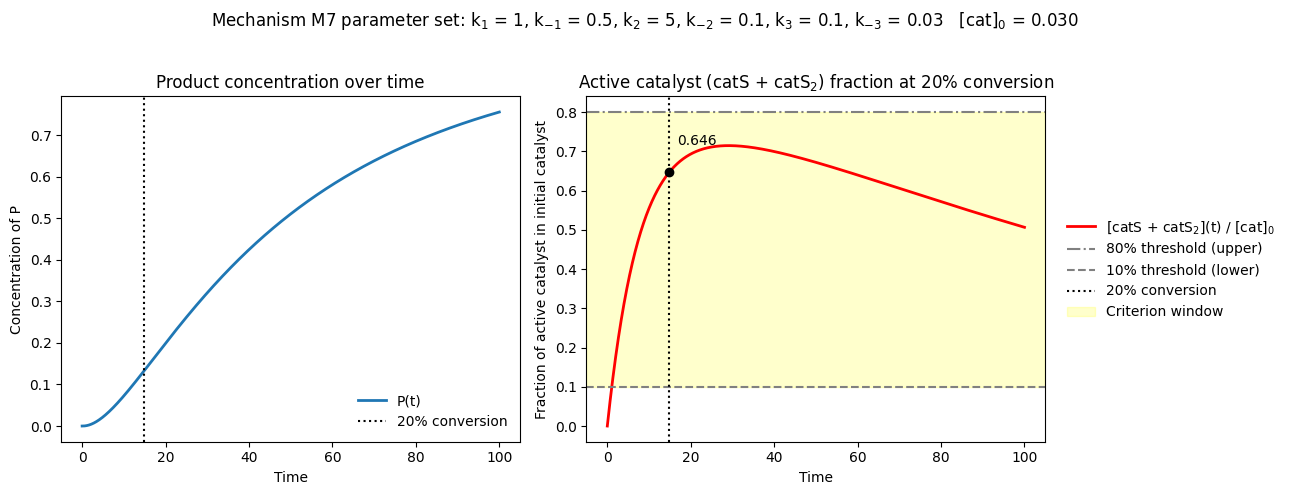

Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)



In [25]:
def M7_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)  

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M7(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for [cat]$_0$ = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for [cat]$_0$ = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, catS2 = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        S_conv = (S0 - S) / (S0 - S[-1] + 1e-8)
        idx_20 = np.argmin(np.abs(S_conv - 0.2))

        if np.abs(S_conv[idx_20] - 0.2) > 0.01:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → No time point sufficiently close to 20% conversion.")
            continue

        t_20 = t[idx_20]
        active_cat = catS[idx_20] + catS2[idx_20]
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.1 <= active_frac <= 0.8

        if passed:
            if verbose:
                print(
                    f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                    f"Time at 20% conversion = {t_20:.2f}, "
                    f"Active cat fraction = {active_frac:.3f}"
                )

                fig, axs = plt.subplots(1, 2, figsize=(13, 5))

                axs[0].plot(t, P, label='P(t)', linewidth=2)
                axs[0].axvline(t_20, linestyle=':', color='black', label='20% conversion')
                axs[0].set_title("Product concentration over time")
                axs[0].set_xlabel("Time")
                axs[0].set_ylabel("Concentration of P")
                axs[0].legend(frameon=False)

                axs[1].plot(t, (catS + catS2) / (cat0 + 1e-10),
                            label=r'[catS + catS$_2$](t) / [cat]$_0$', color='red', linewidth=2)
                axs[1].axhline(0.8, linestyle='-.', color='gray', label='80% threshold (upper)')
                axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold (lower)')
                axs[1].axvline(t_20, linestyle=':', color='black', label='20% conversion')
                axs[1].axhspan(0.1, 0.8, color='yellow', alpha=0.2, label='Criterion window')
                axs[1].plot(t_20, active_frac, 'ko')  
                axs[1].text(t_20 + 2, active_frac + 0.07, f'{active_frac:.3f}', color='black')  

                axs[1].set_title("Active catalyst (catS + catS$_2$) fraction at 20% conversion")
                axs[1].set_xlabel("Time")
                axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
                axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

                param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_3$', 'k$_{-3}$']
                param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
                plt.suptitle(f"Mechanism M7 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

                print("Filter result: Pass (active catalyst fraction in [10%, 80%] at 20% conversion.)\n")
            return True

    if verbose:
        print("Filter result: Fail (no initial catalyst concentration in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.5, 5.0, 0.1]
k3_vals = [0.01, 0.05, 0.1]
k3r_vals = [0.001, 0.01, 0.03]

for k3 in k3_vals:
    for k3r in k3r_vals:
        theta = np.array(base_theta + [k3, k3r])
        print(f"Testing M7 with k3 = {k3:.3f}, k_3 = {k3r:.3f}")
        M7_dimerization_criterion(theta)

In [26]:
def ode_M8(t, y, theta):
    S, P, cat, cat_star, cat_starS, L = y
    k1, k_1, k2, k_2, k3, k_3 = theta
    
    dS_dt = k_1 * cat_starS - k1 * S * cat_star
    dP_dt = k2 * cat_starS - k_2 * cat_star * P
    dcat_dt = k_3 * L * cat_star - k3 * cat
    dcat_star_dt = k3 * cat - k_3 * L * cat_star + (k_1 + k2) * cat_starS - (k1 * S + k_2 * P) * cat_star
    dcat_starS_dt = (k1 * S + k_2 * P) * cat_star - (k_1 + k2) * cat_starS
    dL_dt = k3 * cat - k_3 * L * cat_star
    return [dS_dt, dP_dt, dcat_dt, dcat_star_dt, dcat_starS_dt, dL_dt]

def train_inits_M8():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0, 1.0])
    return inits

def test_inits_M8():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0, 1.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0, 1.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M8_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(-0.2, 1.0)
        k_1 = 10**np.random.uniform(-0.5, 0.5)
        k2 = 10**np.random.uniform(0.3, 1.0)
        k_2 = 10**np.random.uniform(-1.3, -0.3)
        k3 = 10**np.random.uniform(-2.0, -1.0)
        k_3 = 10**np.random.uniform(-3.0, -1.5)
        thetas.append(round_sig([k1, k_1, k2, k_2, k3, k_3], sig=3))
    return np.array(thetas)

def M8_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0, 1.0] 
        
        t_span = (0, 100)
        t_eval = np.linspace(0, 100, 100)
        
        sol = solve_ivp(lambda t, y: ode_func(t, y, theta), t_span, y0, t_eval=t_eval, method="LSODA")
        if (not sol.success) or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        S_traj = sol.y[0]
        cat_star_traj = sol.y[3]
        cat_starS_traj = sol.y[4]
        S_start = S_traj[0]
        S_end = S_traj[-1]
        S_conv = (S_start - S_traj) / (S_start - S_end + 1e-10)
        idx_50 = np.argmin(np.abs(S_conv - 0.5))
        if np.abs(S_conv[idx_50] - 0.5) > 0.01:
            continue
        active_cat = cat_star_traj[idx_50] + cat_starS_traj[idx_50]
        if 0.1 * cat0 <= active_cat <= 0.9 * cat0:
            return True
    return False

ODE_FUNCS["M8"] = ode_M8
TRAIN_INIT_FUNCS["M8"] = train_inits_M8
TEST_INIT_FUNCS["M8"] = test_inits_M8
MECH_DIM["M8"] = 6
THETA_DIM["M8"] = 6
POST_FILTER_FUNCS["M8"] = M8_activecat_post_filter
BIASED_SAMPLE_FUNCS["M8"] = sample_theta_M8_biased

In [27]:
def test_mechanism_M8():
    mechanism = "M8"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M8...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M8.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M8...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M8:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M8 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M8()

Identifying valid kinetic parameter sets for mechanism M8...
Successfully identified 5 valid kinetic parameter sets for mechanism M8.
  Parameter set 1: [5.89, 0.444, 5.16, 0.132, 0.0249, 0.0183]
  Parameter set 2: [0.694, 0.341, 5.34, 0.155, 0.0833, 0.0125]
  Parameter set 3: [1.96, 1.04, 2.1, 0.425, 0.0108, 0.00173]
  Parameter set 4: [1.95, 0.351, 2.47, 0.236, 0.0129, 0.0178]
  Parameter set 5: [4.04, 0.528, 9.6, 0.363, 0.0334, 0.00702]

Generating training, validation, and test datasets for mechanism M8...

Summary of data generation for mechanism M8:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M8 completed successfully.


Testing M8 with k3 = 0.010, k_3 = 0.001
Initial cat = 0.030, Max P = 0.577, Time at 50% conversion = 59.64, Active cat fraction = 0.439


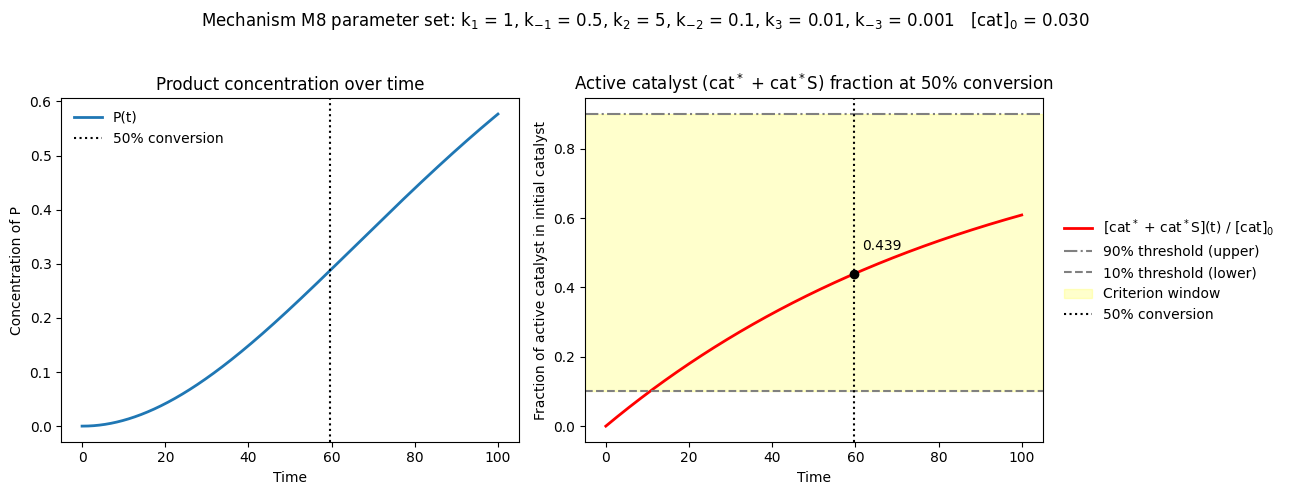

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.010, k_3 = 0.010
Initial cat = 0.030, Max P = 0.502, Time at 50% conversion = 58.64, Active cat fraction = 0.356


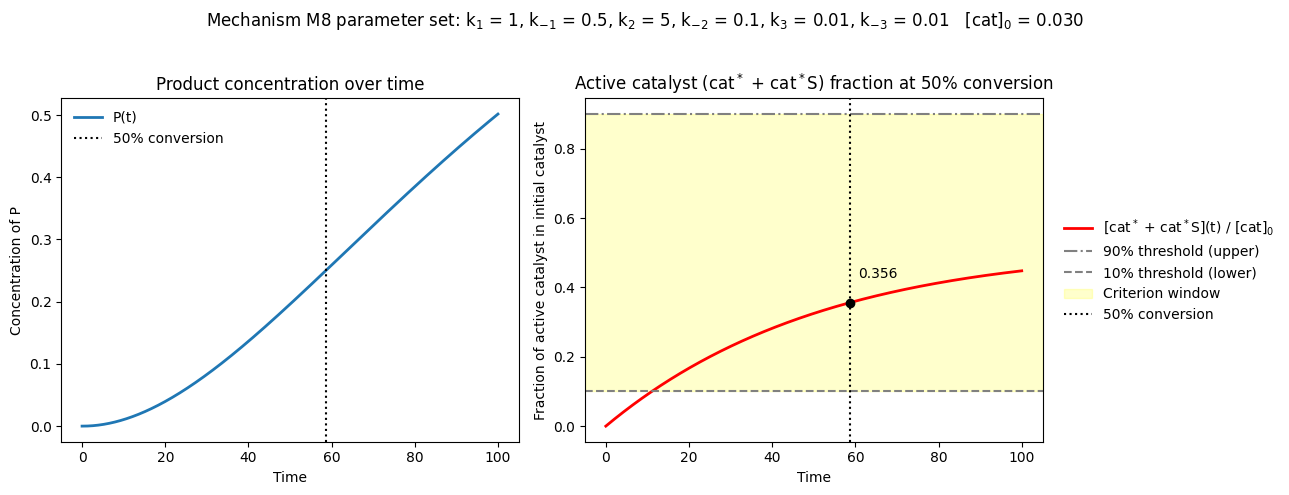

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.010, k_3 = 0.030
Initial catalyst concentration = 0.030 → Fail (max yield = 0.380 < 50%)
Initial catalyst concentration = 0.040 → Fail (max yield = 0.472 < 50%)
Initial cat = 0.050, Max P = 0.550, Time at 50% conversion = 53.30, Active cat fraction = 0.236


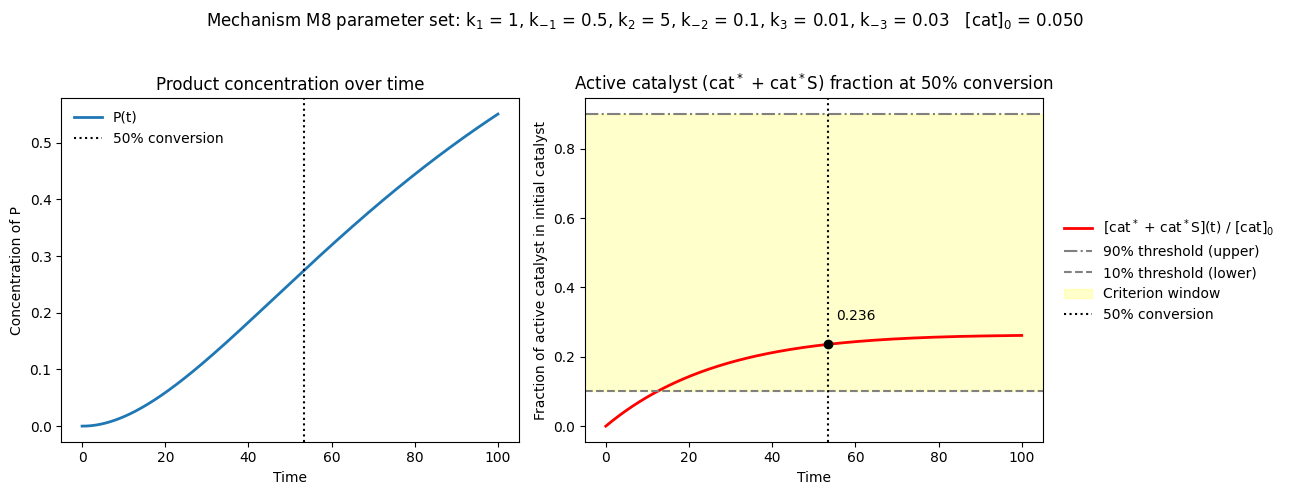

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.050, k_3 = 0.001
Initial cat = 0.030, Max P = 0.855, Time at 50% conversion = 41.09, Active cat fraction = 0.861


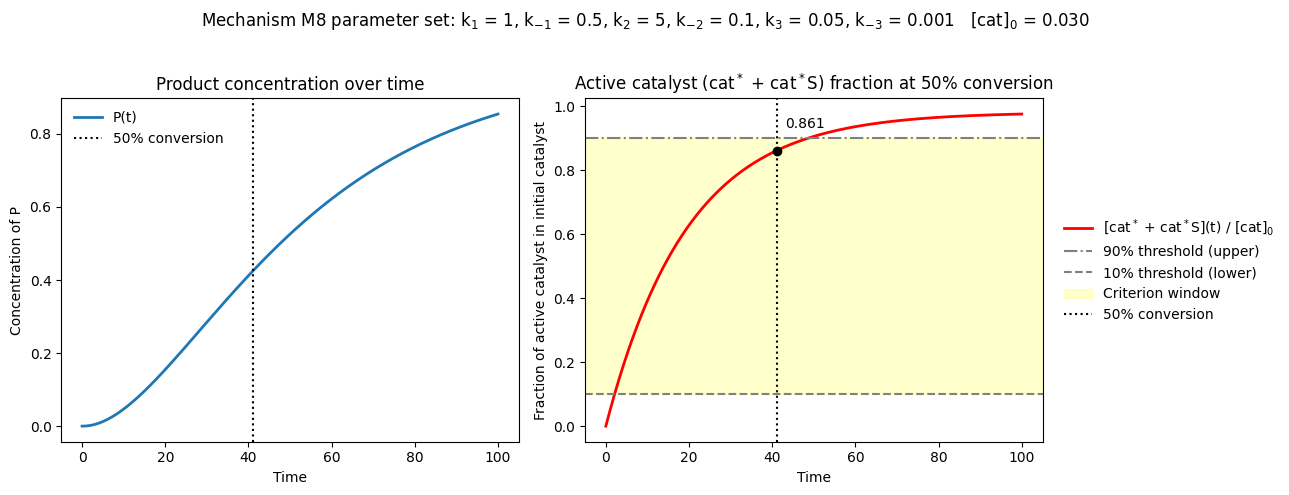

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.050, k_3 = 0.010
Initial cat = 0.030, Max P = 0.819, Time at 50% conversion = 41.69, Active cat fraction = 0.775


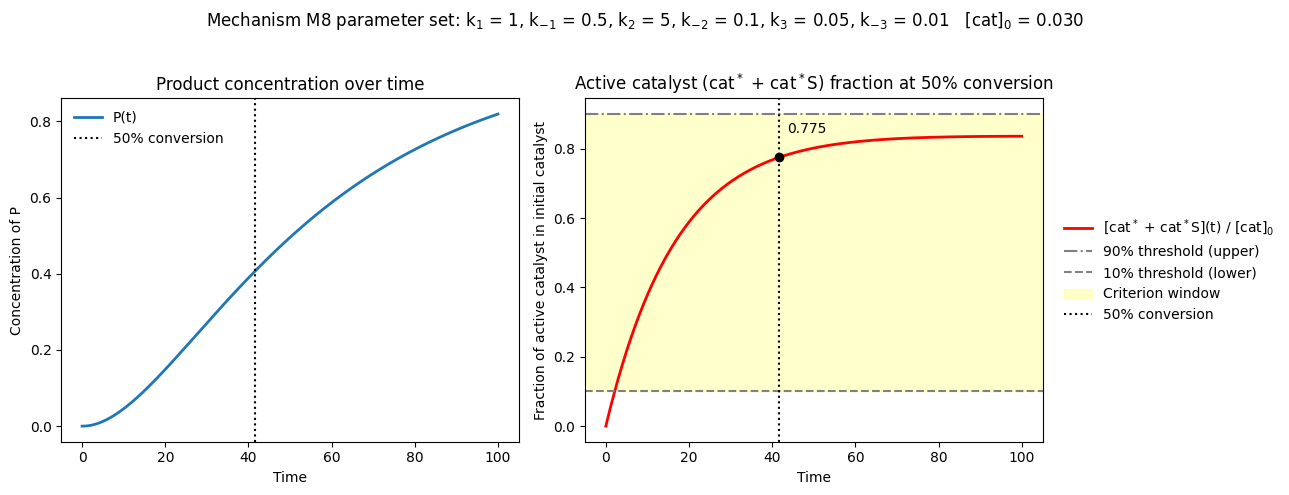

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.050, k_3 = 0.030
Initial cat = 0.030, Max P = 0.745, Time at 50% conversion = 42.70, Active cat fraction = 0.626


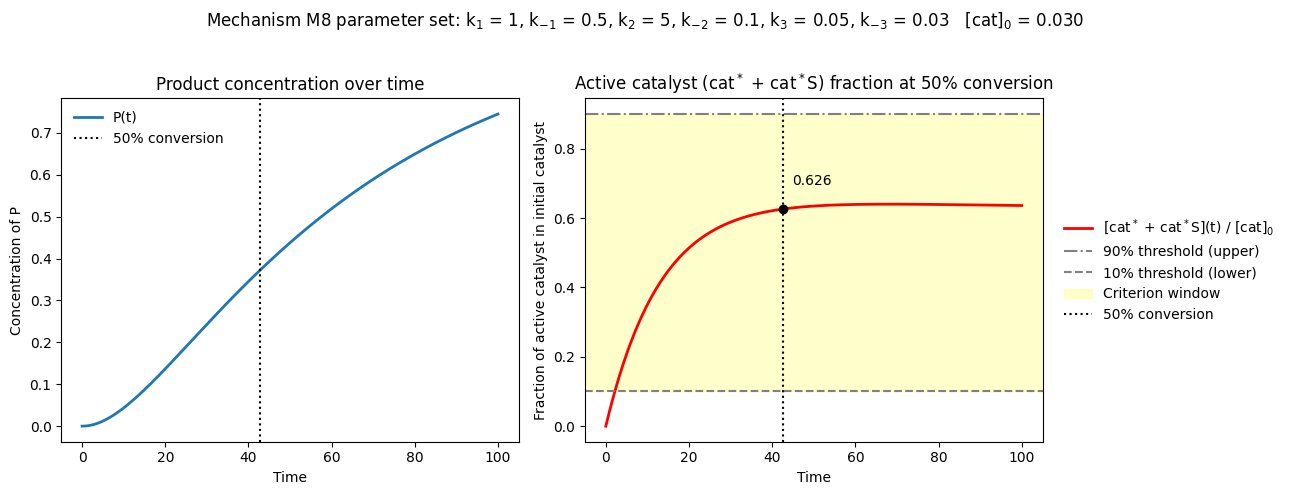

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.100, k_3 = 0.001
Initial cat = 0.060, Max P = 0.979, Time at 50% conversion = 23.15, Active cat fraction = 0.895


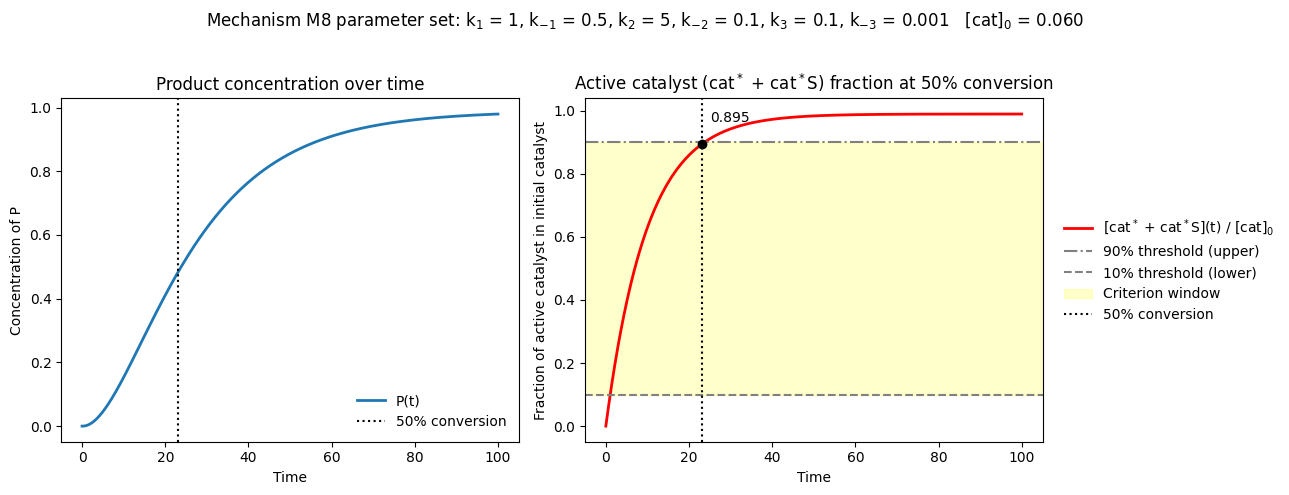

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.100, k_3 = 0.010
Initial cat = 0.030, Max P = 0.868, Time at 50% conversion = 35.09, Active cat fraction = 0.897


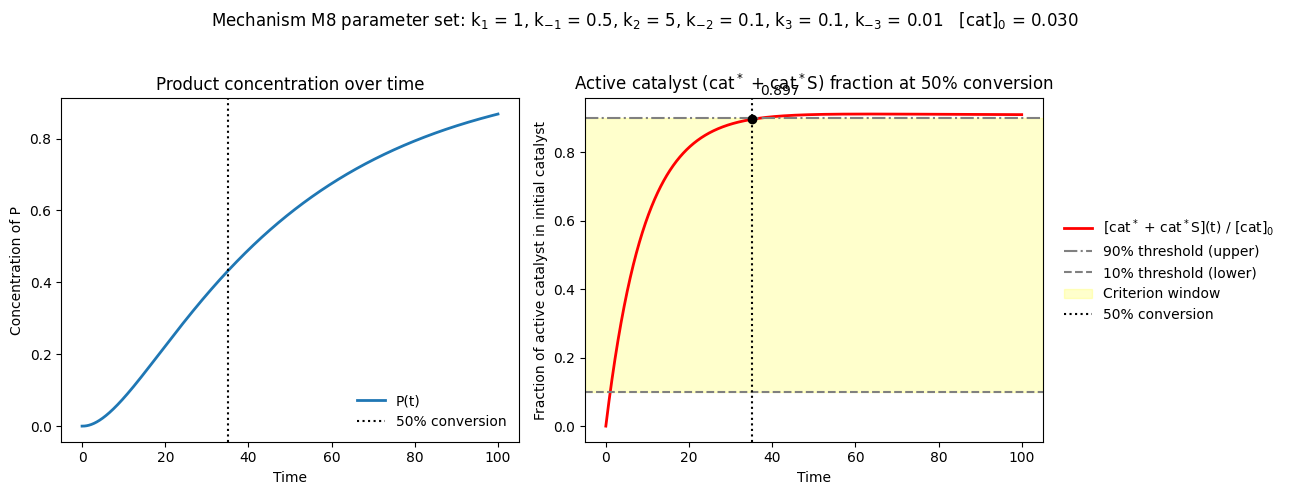

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)

Testing M8 with k3 = 0.100, k_3 = 0.030
Initial cat = 0.030, Max P = 0.828, Time at 50% conversion = 36.29, Active cat fraction = 0.778


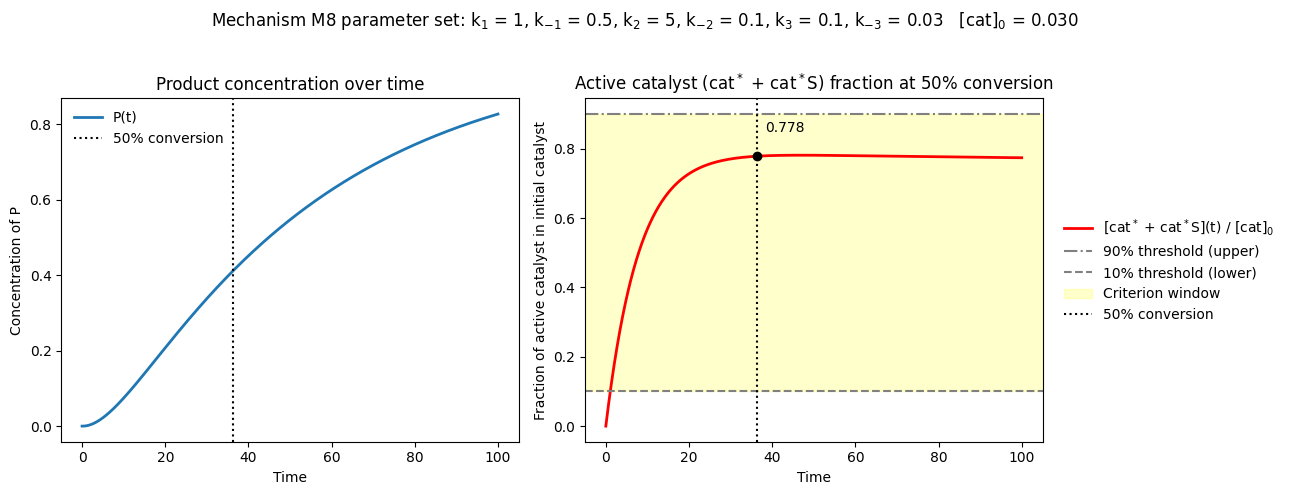

Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)



In [29]:
def M8_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0, 1.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_M8(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for [cat]$_0$ = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for [cat]$_0$ = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, cat_star, cat_starS, L = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        S_conv = (S0 - S) / (S0 - S[-1] + 1e-8)
        idx_50 = np.argmin(np.abs(S_conv - 0.5))

        if np.abs(S_conv[idx_50] - 0.5) > 0.01:
            if verbose:
                print(f"Initial catalyst concentration = {cat0:.3f} → No time point sufficiently close to 50% conversion.")
            continue

        t_50 = t[idx_50]
        active_cat = cat_star[idx_50] + cat_starS[idx_50]
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.1 <= active_frac <= 0.9

        if passed:
            if verbose:
                print(
                    f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                    f"Time at 50% conversion = {t_50:.2f}, "
                    f"Active cat fraction = {active_frac:.3f}"
                )

                fig, axs = plt.subplots(1, 2, figsize=(13, 5))

                axs[0].plot(t, P, label='P(t)', linewidth=2)
                axs[0].axvline(t_50, linestyle=':', color='black', label='50% conversion')
                axs[0].set_title("Product concentration over time")
                axs[0].set_xlabel("Time")
                axs[0].set_ylabel("Concentration of P")
                axs[0].legend(frameon=False)

                axs[1].plot(t, (cat_star + cat_starS) / (cat0 + 1e-10),
                            label=r'[cat$^*$ + cat$^*$S](t) / [cat]$_0$', color='red', linewidth=2)
                axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
                axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold (lower)')
                axs[1].axhspan(0.1, 0.9, color='yellow', alpha=0.2, label='Criterion window')
                axs[1].axvline(t_50, linestyle=':', color='black', label='50% conversion')
                axs[1].plot(t_50, active_frac, 'ko')
                axs[1].text(t_50 + 2, active_frac + 0.07, f'{active_frac:.3f}', color='black')

                axs[1].set_title("Active catalyst (cat$^*$ + cat$^*$S) fraction at 50% conversion")
                axs[1].set_xlabel("Time")
                axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
                axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

                param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_3$', 'k$_{-3}$']
                param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
                plt.suptitle(f"Mechanism M8 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()

                print("Filter result: Pass (active catalyst fraction in [10%, 90%] at 50% conversion.)\n")
            return True

    if verbose:
        print("Filter result: Fail (no initial catalyst concentration in [0.03, 0.07] satisfied the criterion.)\n")
    return False


base_theta = [1.0, 0.5, 5.0, 0.1]
k3_vals = [0.01, 0.05, 0.1]
k3r_vals = [0.001, 0.01, 0.03]

for k3 in k3_vals:
    for k3r in k3r_vals:
        theta = np.array(base_theta + [k3, k3r])
        print(f"Testing M8 with k3 = {k3:.3f}, k_3 = {k3r:.3f}")
        M8_dimerization_criterion(theta)

In [30]:
def ode_M9(t, y, theta):
    S, P, cat, catS, inact_cat = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dinact_dt = k_3 * cat
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_dt]

def train_inits_M9():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M9():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M9_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(0.0, 1.0)
        k_1 = 10**np.random.uniform(-1.0, 0.5)
        k2 = 10**np.random.uniform(0.0, 1.0)
        k_2 = 10**np.random.uniform(-1.0, 0.5)
        k_3 = 10**np.random.uniform(-1.8, -1.35)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M9_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M9"] = ode_M9
TRAIN_INIT_FUNCS["M9"] = train_inits_M9
TEST_INIT_FUNCS["M9"] = test_inits_M9
MECH_DIM["M9"] = 5
THETA_DIM["M9"] = 5
POST_FILTER_FUNCS["M9"] = M9_activecat_post_filter
BIASED_SAMPLE_FUNCS["M9"] = sample_theta_M9_biased

In [31]:
def test_mechanism_M9():
    mechanism = "M9"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M9...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M9.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M9...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M9:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M9 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M9()

Identifying valid kinetic parameter sets for mechanism M9...
Successfully identified 5 valid kinetic parameter sets for mechanism M9.
  Parameter set 1: [3.98, 0.61, 3.74, 0.111, 0.0186]
  Parameter set 2: [5.56, 1.67, 6.32, 0.401, 0.0218]
  Parameter set 3: [5.16, 0.316, 2.13, 0.265, 0.0209]
  Parameter set 4: [1.05, 0.191, 1.49, 0.55, 0.0244]
  Parameter set 5: [1.8, 0.563, 6.4, 0.15, 0.0371]

Generating training, validation, and test datasets for mechanism M9...

Summary of data generation for mechanism M9:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M9 completed successfully.


Testing M9 with k₋3 = 0.015
Initial cat = 0.030, Max P = 0.671, Time at 50% P_max = 30.63, Active cat fraction = 0.767


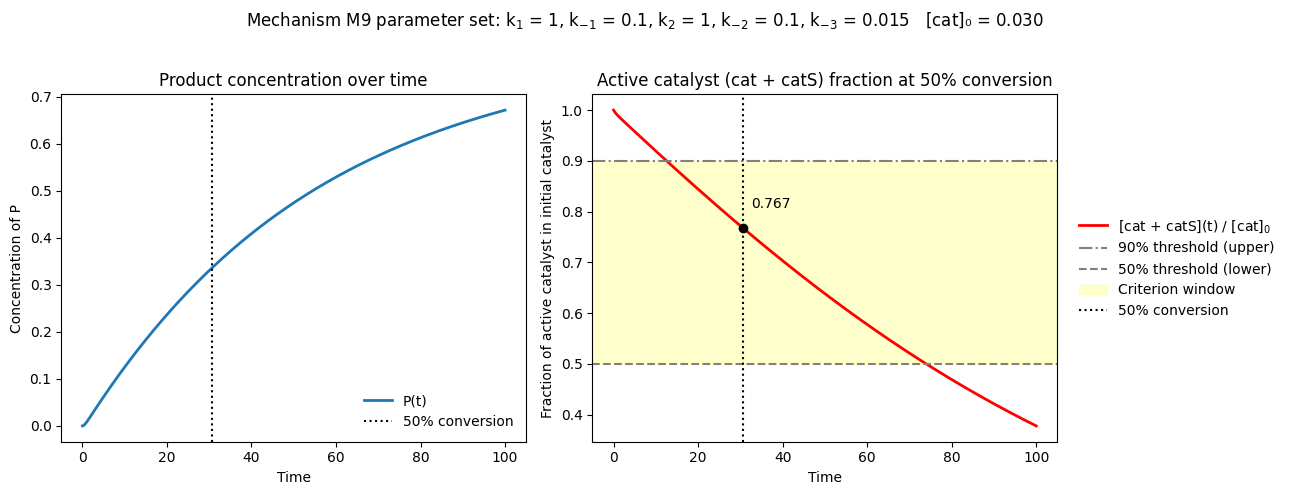

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M9 with k₋3 = 0.025
Initial cat = 0.030, Max P = 0.575, Time at 50% P_max = 27.26, Active cat fraction = 0.679


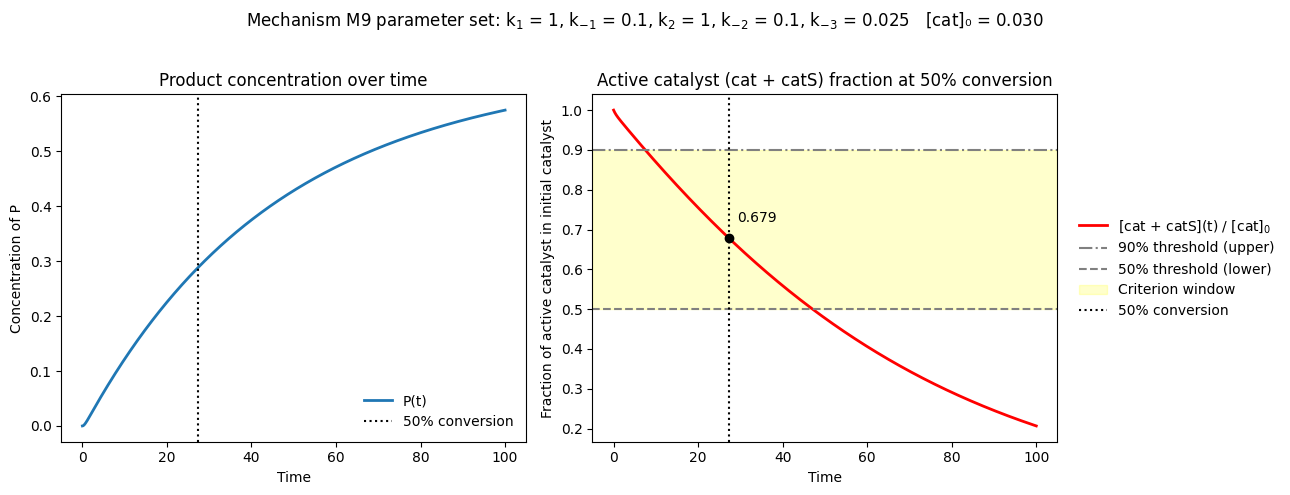

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M9 with k₋3 = 0.035
Initial cat = 0.030 → Fail (max yield = 0.495 < 50%)
Initial cat = 0.040, Max P = 0.602, Time at 50% P_max = 22.18, Active cat fraction = 0.641


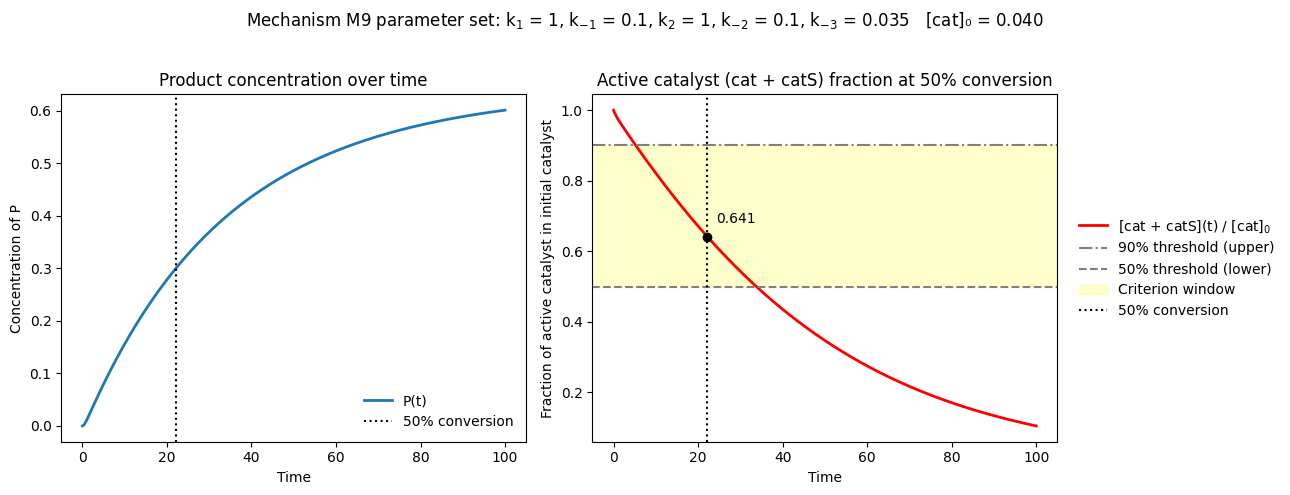

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M9 with k₋3 = 0.045
Initial cat = 0.030 → Fail (max yield = 0.430 < 50%)
Initial cat = 0.040, Max P = 0.530, Time at 50% P_max = 19.85, Active cat fraction = 0.603


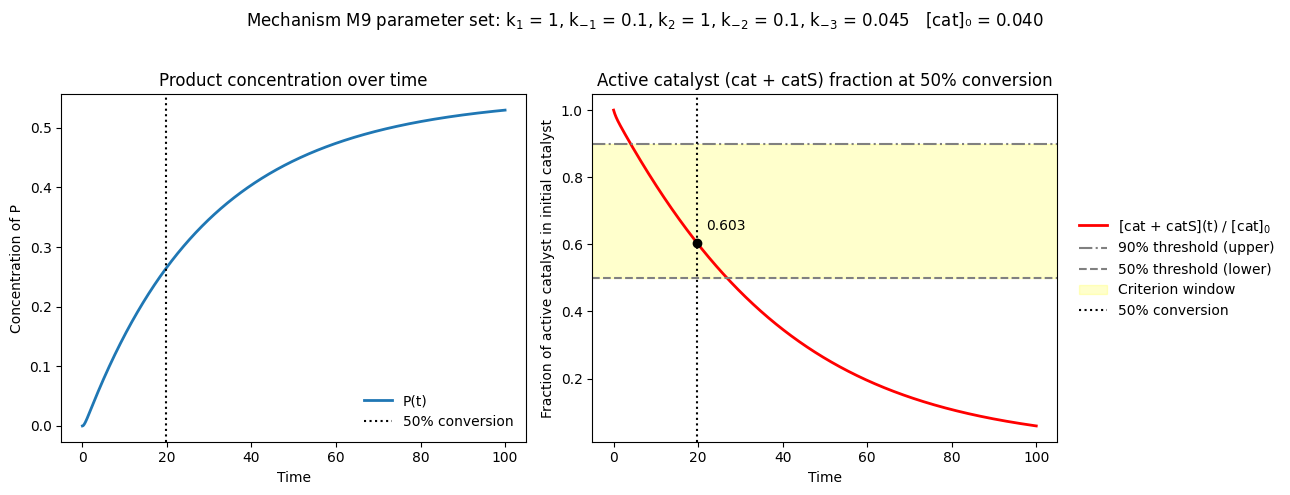

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [34]:
def M9_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M9(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_cat = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            
            
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko')  
            axs[1].text(t_half + 2, active_frac + 0.04, f'{active_frac:.3f}', color='black')  

            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M9 parameter set: {param_str}   [cat]₀ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [0.015, 0.025, 0.035, 0.045] 

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M9 with k₋3 = {k_3:.3f}")
    M9_dimerization_criterion(theta)

In [35]:
def ode_M10(t, y, theta):
    S, P, cat, catS, inhibitor, inact_catI = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3 * inhibitor) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dinhibitor_dt = -k_3 * inhibitor * cat
    dinact_catI_dt = k_3 * inhibitor * cat
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinhibitor_dt, dinact_catI_dt]

def train_inits_M10():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0, 0.0])
    return inits

def test_inits_M10():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 1.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M10_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(0.0, 1.0)
        k_1 = 10**np.random.uniform(-1.0, 0.5)
        k2 = 10**np.random.uniform(0.0, 1.0)
        k_2 = 10**np.random.uniform(-1.0, 0.5)
        k_3 = 10**np.random.uniform(-2.0, -1.35)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M10_inactcat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    S0 = 1.0
    P0 = 0.0
    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 1.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
            
        t = sol.t
        y = sol.y
        P = y[1]
        inact_catI = y[5]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        inact_catI_interp = interp1d(t, inact_catI, kind='linear', fill_value='extrapolate')
        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max
        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        inact_catI_at_half = inact_catI_interp(t_half)
        if inact_catI_at_half >= 0.1 * cat0:
            return True
    return False

ODE_FUNCS["M10"] = ode_M10
TRAIN_INIT_FUNCS["M10"] = train_inits_M10
TEST_INIT_FUNCS["M10"] = test_inits_M10
MECH_DIM["M10"] = 6
THETA_DIM["M10"] = 5
POST_FILTER_FUNCS["M10"] = M10_inactcat_post_filter
BIASED_SAMPLE_FUNCS["M10"] = sample_theta_M10_biased

In [36]:
def test_mechanism_M10():
    mechanism = "M10"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M10...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M10.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M10...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M10:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M10 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M10()

Identifying valid kinetic parameter sets for mechanism M10...
Successfully identified 5 valid kinetic parameter sets for mechanism M10.
  Parameter set 1: [1.59, 0.823, 2.66, 0.101, 0.0374]
  Parameter set 2: [1.68, 1.42, 4.03, 1.17, 0.0299]
  Parameter set 3: [2.83, 0.769, 2.69, 2.3, 0.0136]
  Parameter set 4: [9.06, 1.48, 1.85, 0.223, 0.0444]
  Parameter set 5: [3.26, 0.436, 9.06, 3.05, 0.0155]

Generating training, validation, and test datasets for mechanism M10...

Summary of data generation for mechanism M10:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M10 completed successfully.


Testing M10 with k₋3 = 0.010
Initial cat = 0.030, Max P = 0.725, Time at 50% P_max = 32.28, Inactive catI fraction = 0.170


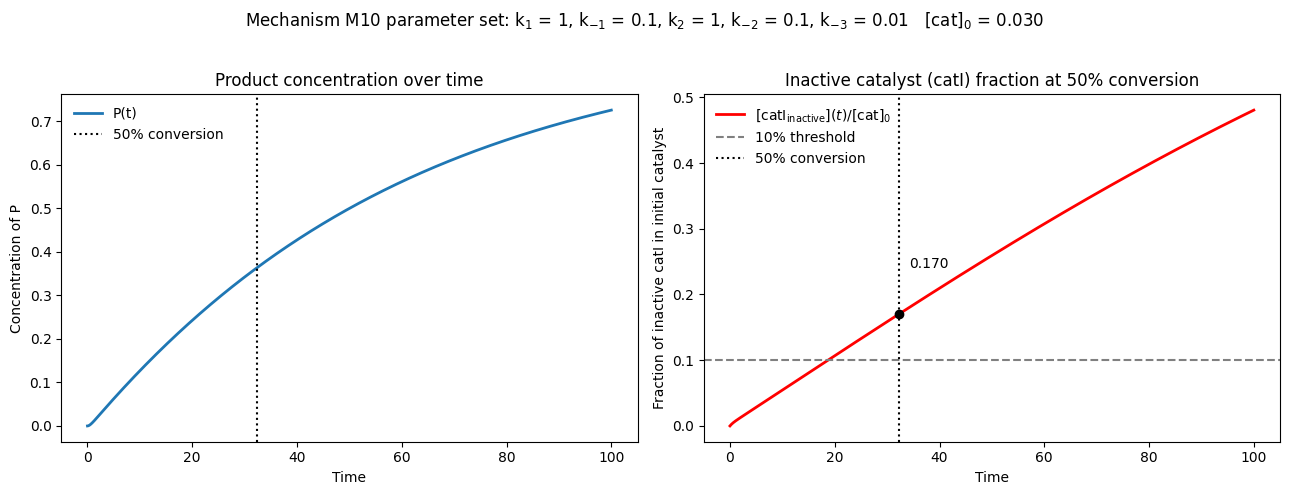

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)

Testing M10 with k₋3 = 0.015
Initial cat = 0.030, Max P = 0.672, Time at 50% P_max = 30.68, Inactive catI fraction = 0.232


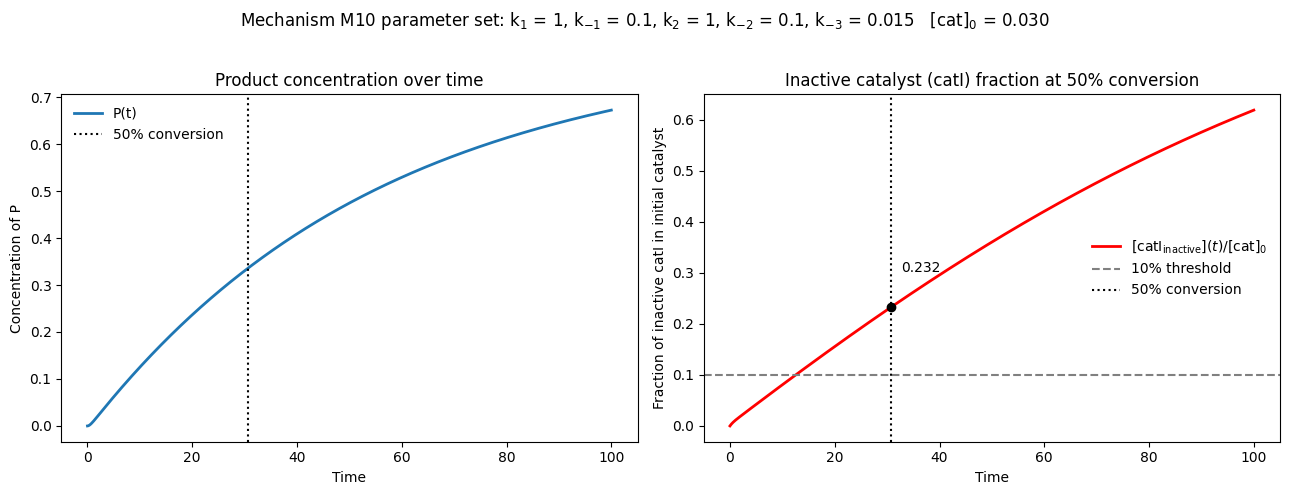

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)

Testing M10 with k₋3 = 0.020
Initial cat = 0.030, Max P = 0.623, Time at 50% P_max = 29.02, Inactive catI fraction = 0.282


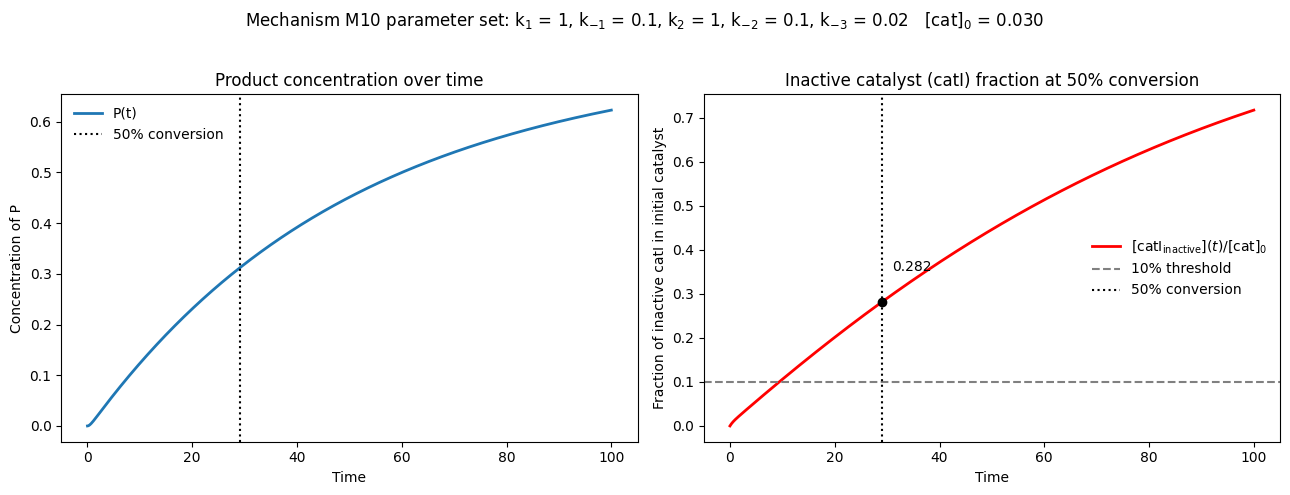

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)

Testing M10 with k₋3 = 0.025
Initial cat = 0.030, Max P = 0.577, Time at 50% P_max = 27.37, Inactive catI fraction = 0.321


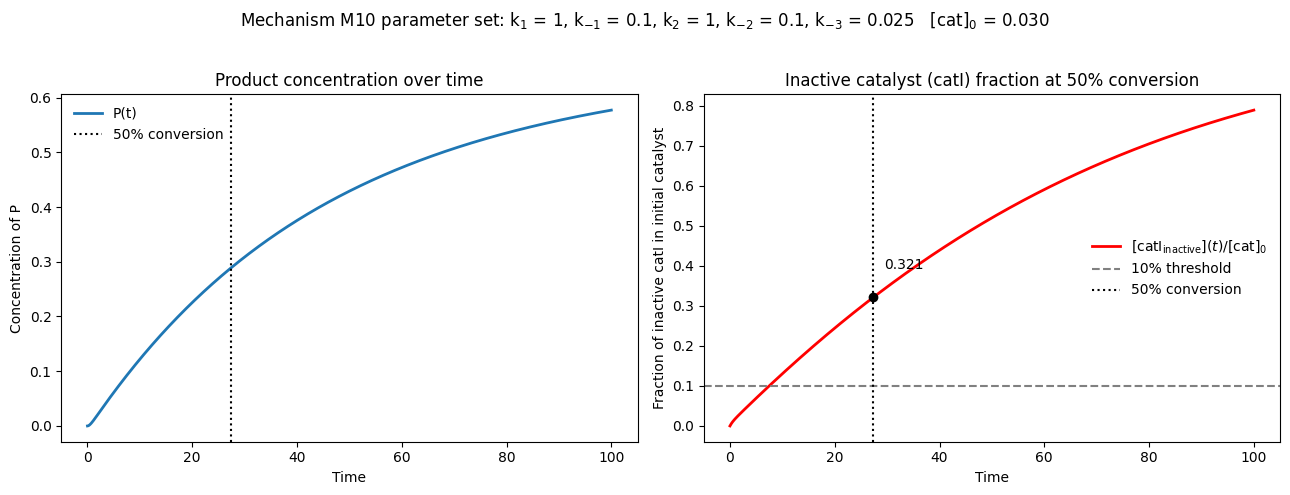

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)

Testing M10 with k₋3 = 0.035
Initial cat = 0.030 → Fail (max yield = 0.498 < 50%)
Initial cat = 0.040, Max P = 0.606, Time at 50% P_max = 22.37, Inactive catI fraction = 0.359


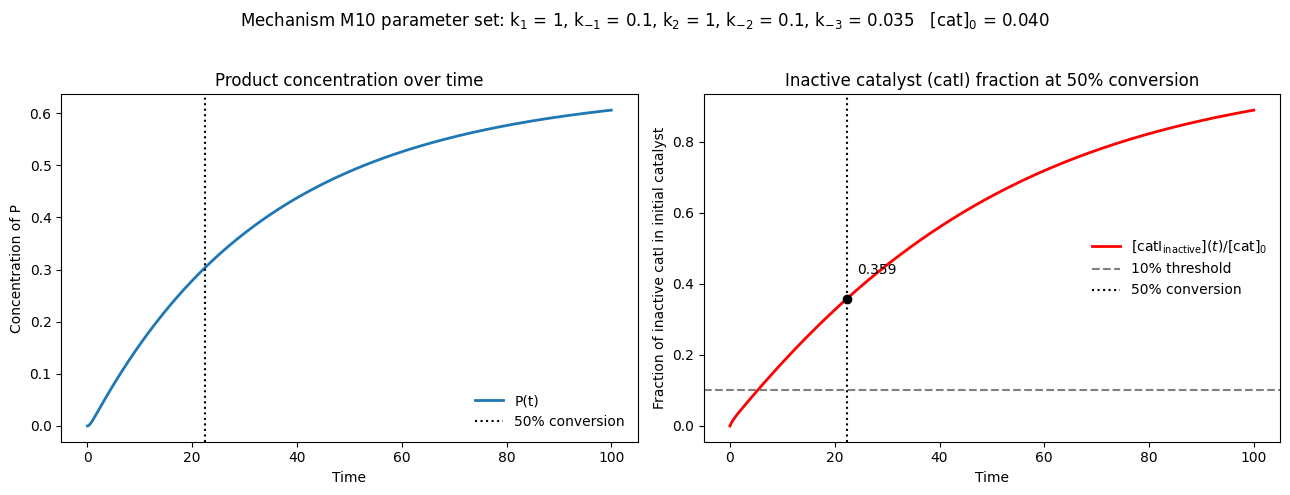

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)

Testing M10 with k₋3 = 0.045
Initial cat = 0.030 → Fail (max yield = 0.433 < 50%)
Initial cat = 0.040, Max P = 0.535, Time at 50% P_max = 20.08, Inactive catI fraction = 0.398


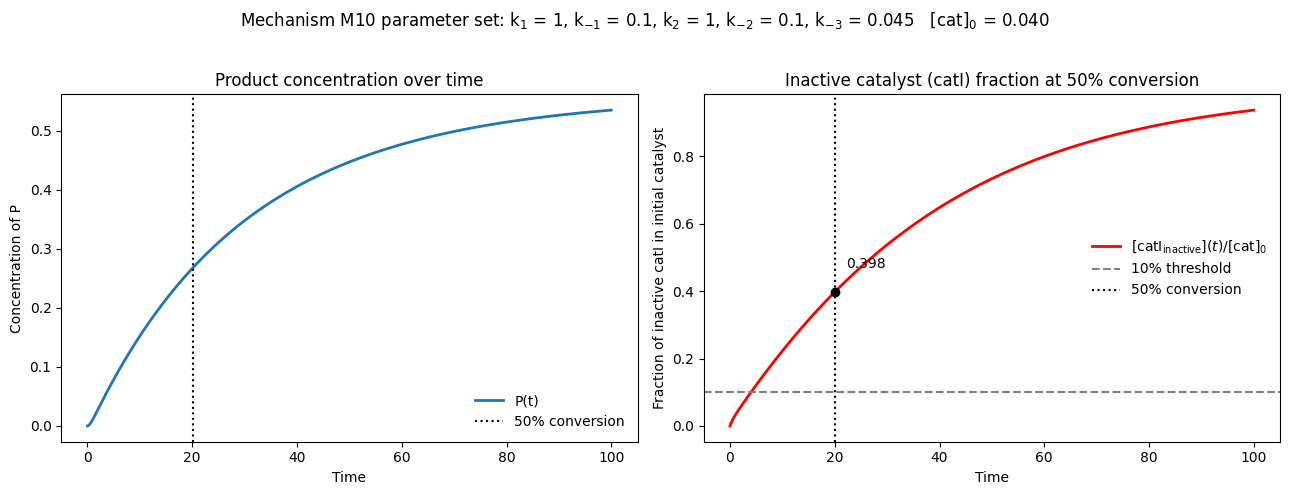

Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)



In [38]:
def M10_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 1.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M10(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inhibitor, inact_catI = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        inact_catI_interp = interp1d(t, inact_catI, kind='linear', fill_value='extrapolate')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        inact_catI_at_half = inact_catI_interp(t_half)
        ratio = inact_catI_at_half / (cat0 + 1e-10)
        passed = ratio > 0.1

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Inactive catI fraction = {ratio:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, inact_catI / (cat0 + 1e-10),
                        label=r'$[\mathrm{catI}_{\mathrm{inactive}}](t) / [\mathrm{cat}]_0$', color='red', linewidth=2)
            axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].plot(t_half, ratio, 'ko')
            axs[1].text(t_half + 2, ratio + 0.07, f'{ratio:.3f}', color='black')
            axs[1].set_title("Inactive catalyst (catI) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of inactive catI in initial catalyst")
            axs[1].legend(frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']                      
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M10 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")         


            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (inactive catI fraction ≤ 10% at 50% conversion.)\n")
            else:
                print("Filter result: Pass (inactive catI fraction > 10% at 50% conversion.)\n")            

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]  
k_3_list = [0.01, 0.015, 0.02, 0.025, 0.035, 0.045]  

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M10 with k₋3 = {k_3:.3f}")
    M10_dimerization_criterion(theta, verbose=True)

In [39]:
def ode_M11(t, y, theta):
    S, P, cat, catS, inact_catS = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - (k1 + k_3) * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3 * S) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dinact_catS_dt = k_3 * S * cat
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_catS_dt]

def train_inits_M11():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M11():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M11_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = np.random.uniform(1.0, 4.5)     
        k_1 = np.random.uniform(0.1, 2.7)   
        k2 = np.random.uniform(1.0, 4.5)
        k_2 = np.random.uniform(0.1, 2.7)
        k_3 = np.random.uniform(0.01, 0.045) 
        theta = [round(k1, 3), round(k_1, 3), round(k2, 3), round(k_2, 3), round(k_3, 3)]
        thetas.append(theta)
    return thetas

def M11_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0] 
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M11"] = ode_M11
TRAIN_INIT_FUNCS["M11"] = train_inits_M11
TEST_INIT_FUNCS["M11"] = test_inits_M11
MECH_DIM["M11"] = 5
THETA_DIM["M11"] = 5
POST_FILTER_FUNCS["M11"] = M11_activecat_post_filter
BIASED_SAMPLE_FUNCS["M11"] = sample_theta_M11_biased

In [40]:
def test_mechanism_M11():
    mechanism = "M11"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M11...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M11.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M11...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M11:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M11 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M11()

Identifying valid kinetic parameter sets for mechanism M11...
Successfully identified 5 valid kinetic parameter sets for mechanism M11.
  Parameter set 1: [4.005, 1.65, 2.362, 1.921, 0.037]
  Parameter set 2: [3.622, 0.282, 2.056, 2.03, 0.028]
  Parameter set 3: [2.707, 1.408, 1.083, 0.35, 0.028]
  Parameter set 4: [2.617, 2.297, 2.219, 0.971, 0.023]
  Parameter set 5: [1.15, 1.139, 3.92, 1.726, 0.018]

Generating training, validation, and test datasets for mechanism M11...

Summary of data generation for mechanism M11:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M11 completed successfully.


Testing M11 with k₋3 = 0.010
Initial cat = 0.030, Max P = 0.761, Time at 50% P_max = 33.89, Active cat fraction = 0.857


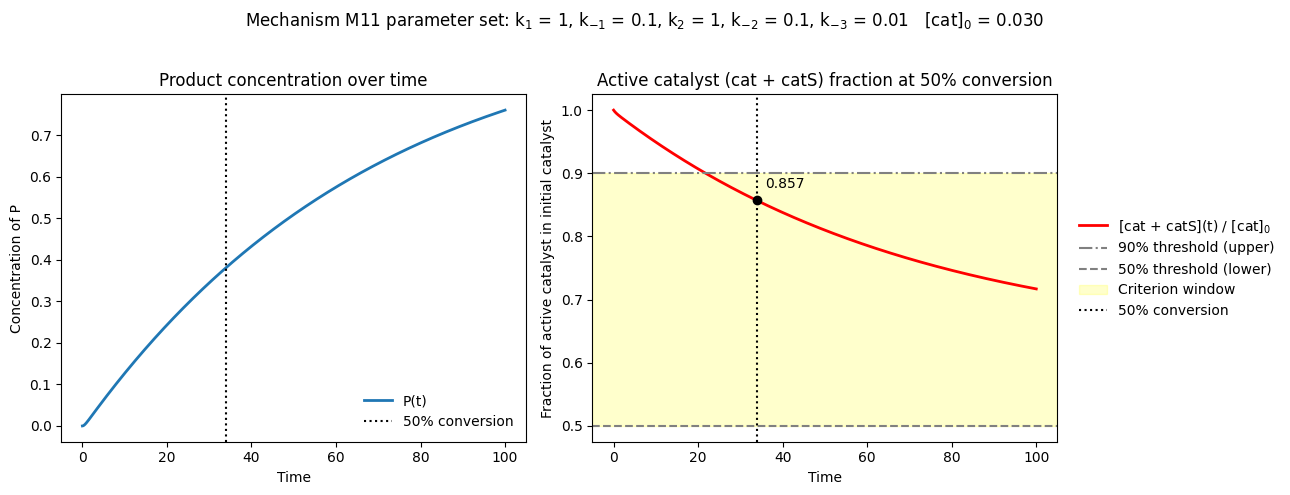

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M11 with k₋3 = 0.015
Initial cat = 0.030, Max P = 0.722, Time at 50% P_max = 33.07, Active cat fraction = 0.797


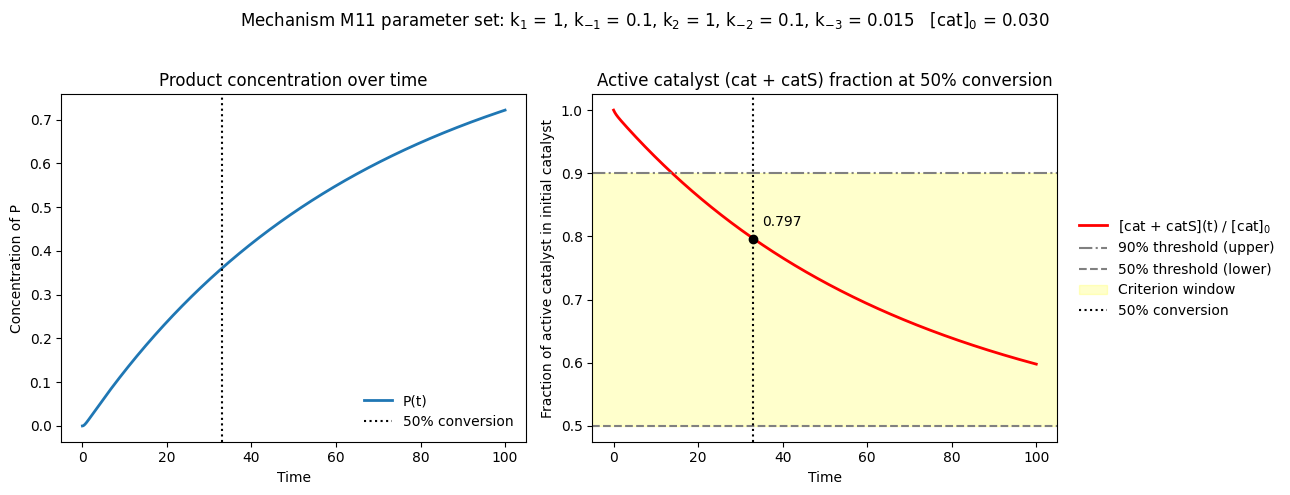

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M11 with k₋3 = 0.020
Initial cat = 0.030, Max P = 0.682, Time at 50% P_max = 32.07, Active cat fraction = 0.744


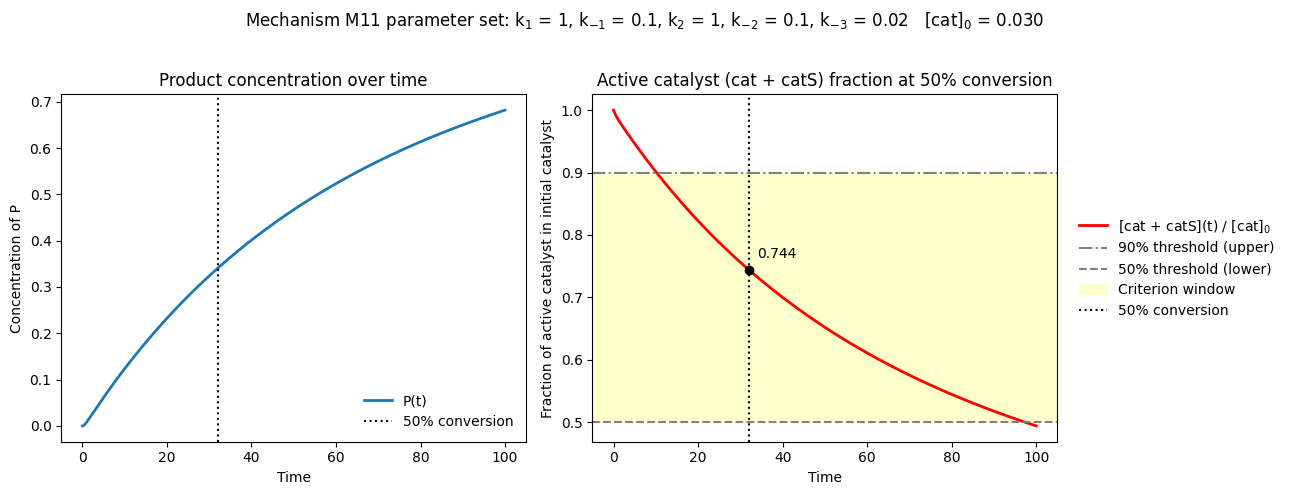

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M11 with k₋3 = 0.025
Initial cat = 0.030, Max P = 0.642, Time at 50% P_max = 30.91, Active cat fraction = 0.698


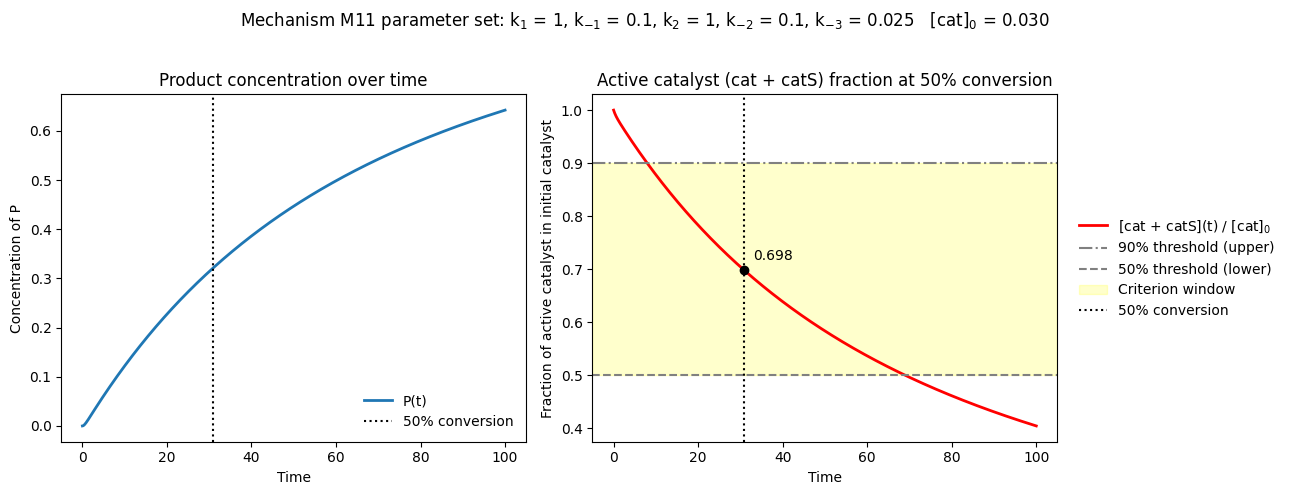

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M11 with k₋3 = 0.035
Initial cat = 0.030, Max P = 0.567, Time at 50% P_max = 28.32, Active cat fraction = 0.627


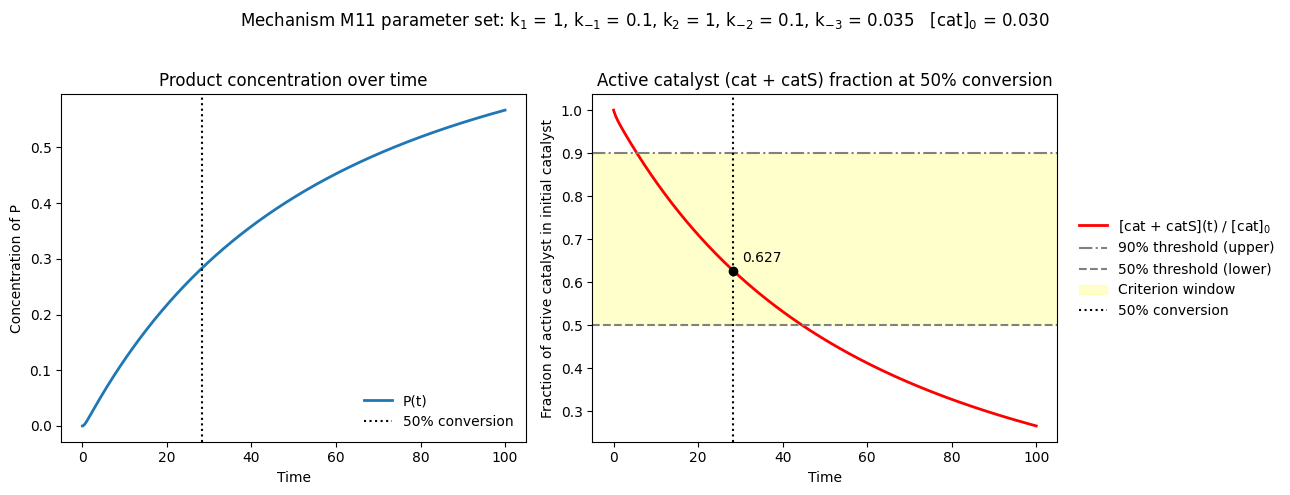

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M11 with k₋3 = 0.045
Initial cat = 0.030 → Fail (max yield = 0.499 < 50%)
Initial cat = 0.040, Max P = 0.632, Time at 50% P_max = 24.72, Active cat fraction = 0.598


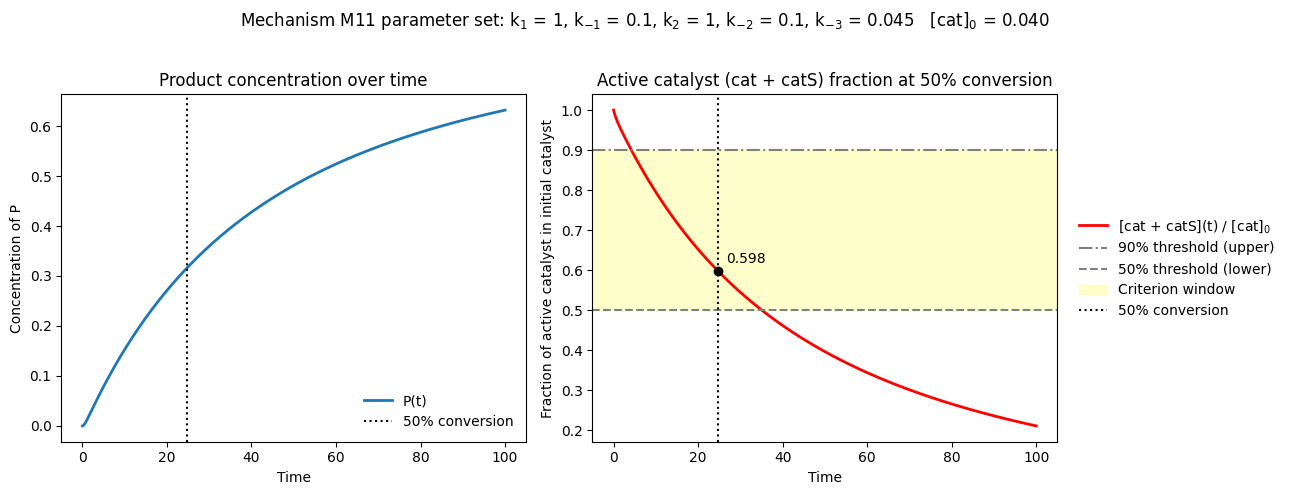

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [41]:
def M11_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M11(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_catS = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= ratio <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {ratio:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, (cat + catS) / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].plot(t_half, ratio, 'ko')  
            axs[1].text(t_half + 2, ratio + 0.02, f'{ratio:.3f}', color='black')  
            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M11 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]  
k_3_list = [0.01, 0.015, 0.02, 0.025, 0.035, 0.045]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M11 with k₋3 = {k_3:.3f}")
    M11_dimerization_criterion(theta, verbose=True)

In [42]:
def ode_M12(t, y, theta):
    S, P, cat, catS, inact_catP = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - (k_2 + k_3) * P * cat
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dinact_catP_dt = k_3 * P * cat
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_catP_dt]

def train_inits_M12():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M12():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M12_biased(n=1):
    thetas = []
    for _ in range(n):
        k1  = np.random.uniform(2.22, 3.88)
        k_1 = np.random.uniform(0.54, 1.78)
        k2  = np.random.uniform(7.5, 14.3)
        k_2 = np.random.uniform(0.51, 1.89)
        k_3 = np.random.uniform(0.067, 0.096)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M12_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0] 
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max
        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M12"] = ode_M12
TRAIN_INIT_FUNCS["M12"] = train_inits_M12
TEST_INIT_FUNCS["M12"] = test_inits_M12
MECH_DIM["M12"] = 5
THETA_DIM["M12"] = 5
POST_FILTER_FUNCS["M12"] = M12_activecat_post_filter
BIASED_SAMPLE_FUNCS["M12"] = sample_theta_M12_biased

In [45]:
def test_mechanism_M12():
    mechanism = "M12"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M12...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M12.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M12...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M12:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M12 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M12()

Identifying valid kinetic parameter sets for mechanism M12...
Successfully identified 5 valid kinetic parameter sets for mechanism M12.
  Parameter set 1: [3.7, 0.608, 8.52, 1.87, 0.0915]
  Parameter set 2: [3.41, 0.918, 13.2, 0.683, 0.0921]
  Parameter set 3: [2.27, 1.56, 8.39, 1.16, 0.0692]
  Parameter set 4: [3.83, 0.954, 8.51, 0.91, 0.0791]
  Parameter set 5: [2.3, 1.41, 13.6, 1.09, 0.069]

Generating training, validation, and test datasets for mechanism M12...

Summary of data generation for mechanism M12:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M12 completed successfully.


Testing M12 with k_3 = 0.050
Initial cat = 0.030, Max P = 0.642, Time at 50% P_max = 27.16, Active cat fraction = 0.876


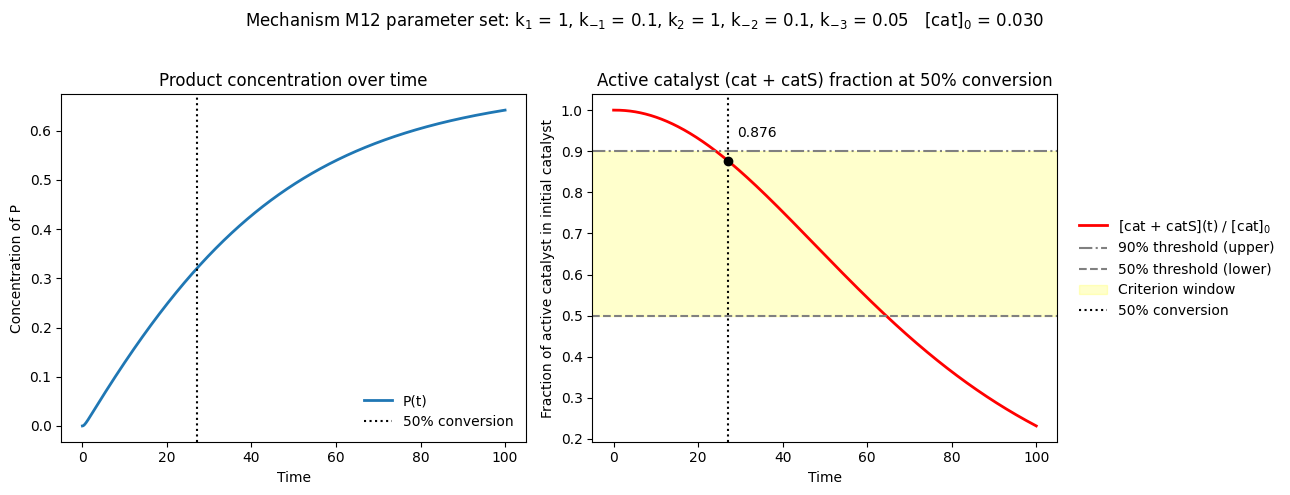

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M12 with k_3 = 0.060
Initial cat = 0.030, Max P = 0.615, Time at 50% P_max = 26.06, Active cat fraction = 0.865


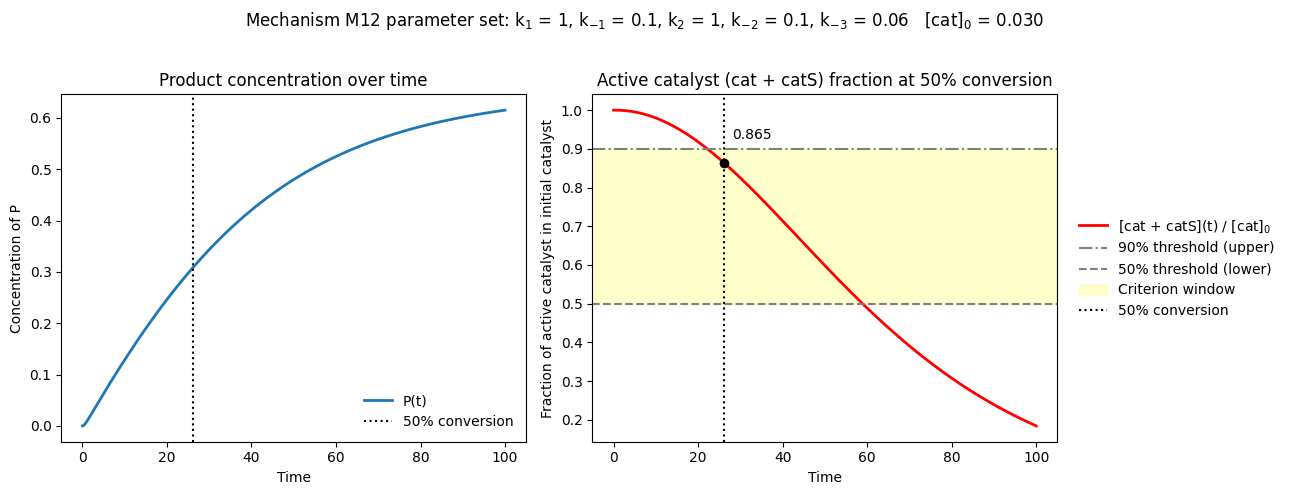

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M12 with k_3 = 0.070
Initial cat = 0.030, Max P = 0.591, Time at 50% P_max = 25.06, Active cat fraction = 0.855


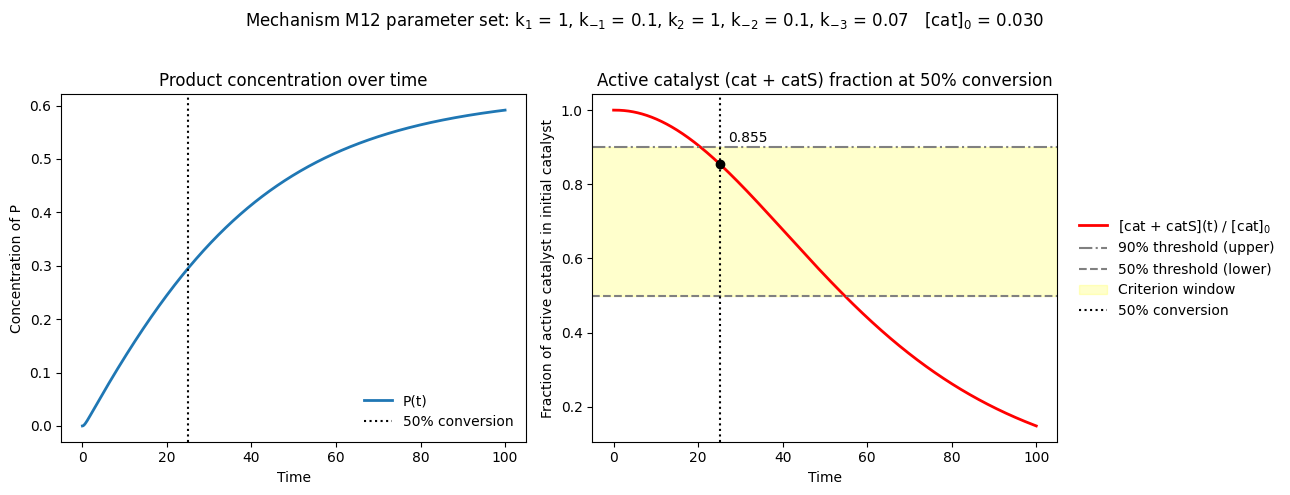

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M12 with k_3 = 0.090
Initial cat = 0.030, Max P = 0.550, Time at 50% P_max = 23.33, Active cat fraction = 0.841


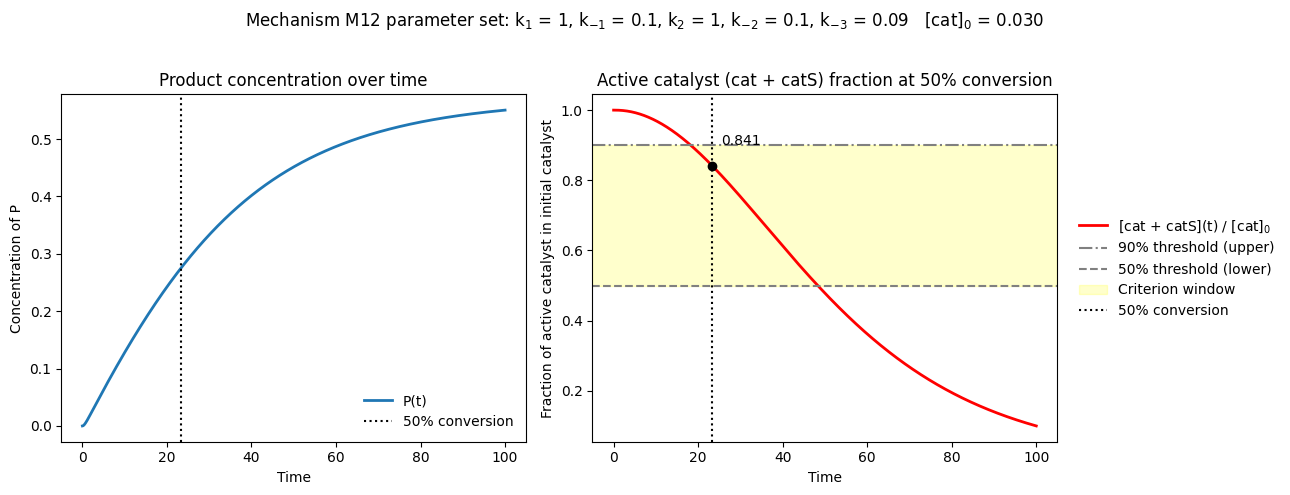

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M12 with k_3 = 0.100
Initial cat = 0.030, Max P = 0.533, Time at 50% P_max = 22.59, Active cat fraction = 0.836


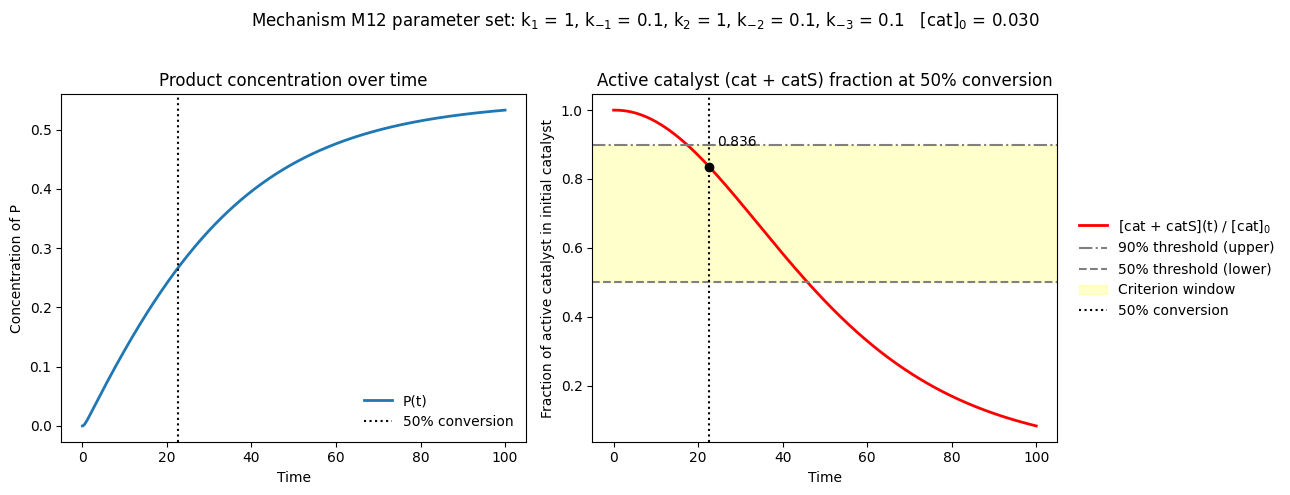

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [46]:
def M12_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)
    
    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M12(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_catP = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        from scipy.interpolate import interp1d
        from scipy.optimize import root_scalar
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)

            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko') 
            axs[1].text(t_half + 2, active_frac + 0.06, f'{active_frac:.3f}', color='black')

            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M12 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [0.05, 0.06, 0.07, 0.09, 0.1]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M12 with k_3 = {k_3:.3f}")
    M12_dimerization_criterion(theta)

In [49]:
def ode_M13(t, y, theta):
    S, P, cat, catS, inact_cat2 = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + 2 * k_3 * cat) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2) * catS
    dinact_cat2_dt = k_3 * cat**2
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_cat2_dt]

def train_inits_M13():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M13():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M13_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(2.5, 5.5)
        k_1  = np.random.uniform(0.9, 2.1)
        k2   = np.random.uniform(7.5, 11.5)
        k_2  = np.random.uniform(0.9, 2.1)
        k_3  = np.random.uniform(1.2, 2.3)
        theta = [round(k1, 3), round(k_1, 3), round(k2, 3), round(k_2, 3), round(k_3, 3)]
        thetas.append(theta)
    return thetas

def M13_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.8:
            return True
    return False

ODE_FUNCS["M13"] = ode_M13
TRAIN_INIT_FUNCS["M13"] = train_inits_M13
TEST_INIT_FUNCS["M13"] = test_inits_M13
MECH_DIM["M13"] = 5
THETA_DIM["M13"] = 5
POST_FILTER_FUNCS["M13"] = M13_activecat_post_filter
BIASED_SAMPLE_FUNCS["M13"] = sample_theta_M13_biased

In [50]:
def test_mechanism_M13():
    mechanism = "M13"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M13...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M13.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M13...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M13:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M13 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M13()

Identifying valid kinetic parameter sets for mechanism M13...
Successfully identified 5 valid kinetic parameter sets for mechanism M13.
  Parameter set 1: [2.855, 1.611, 8.858, 1.909, 2.033]
  Parameter set 2: [5.329, 1.91, 10.7, 1.652, 2.042]
  Parameter set 3: [3.245, 1.168, 9.224, 1.282, 1.476]
  Parameter set 4: [3.411, 1.061, 7.8, 1.084, 1.846]
  Parameter set 5: [4.379, 2.008, 9.43, 1.37, 1.287]

Generating training, validation, and test datasets for mechanism M13...

Summary of data generation for mechanism M13:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M13 completed successfully.


Testing M13 with k_3 = 1.000
Initial cat = 0.030, Max P = 0.942, Time at 50% P_max = 14.95, Active cat fraction = 0.759


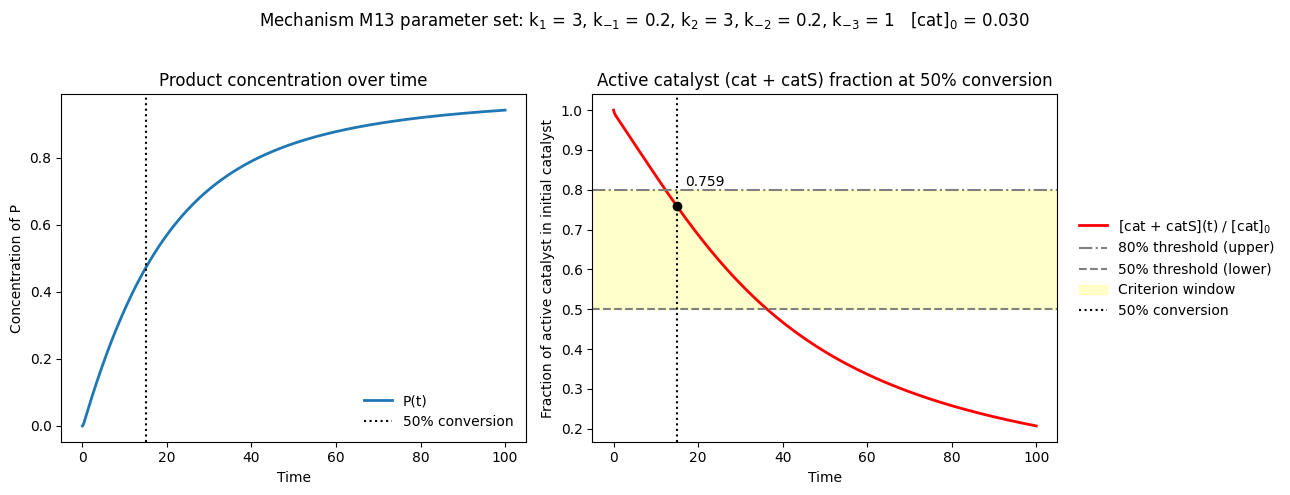

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M13 with k_3 = 1.500
Initial cat = 0.030, Max P = 0.904, Time at 50% P_max = 15.03, Active cat fraction = 0.679


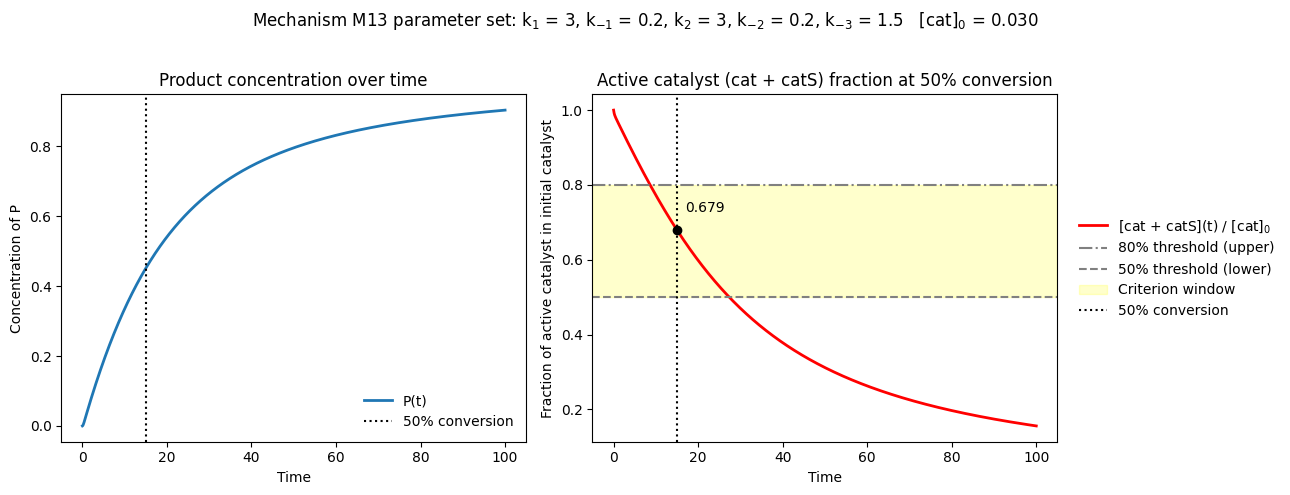

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M13 with k_3 = 2.000
Initial cat = 0.030, Max P = 0.867, Time at 50% P_max = 15.01, Active cat fraction = 0.616


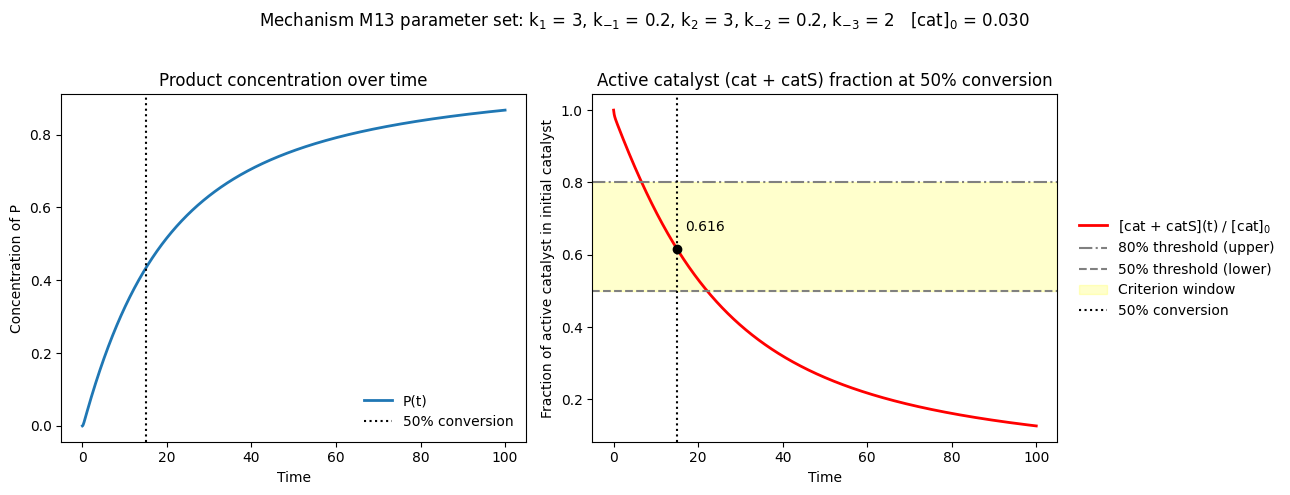

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M13 with k_3 = 3.000
Initial cat = 0.030, Max P = 0.800, Time at 50% P_max = 14.84, Active cat fraction = 0.525


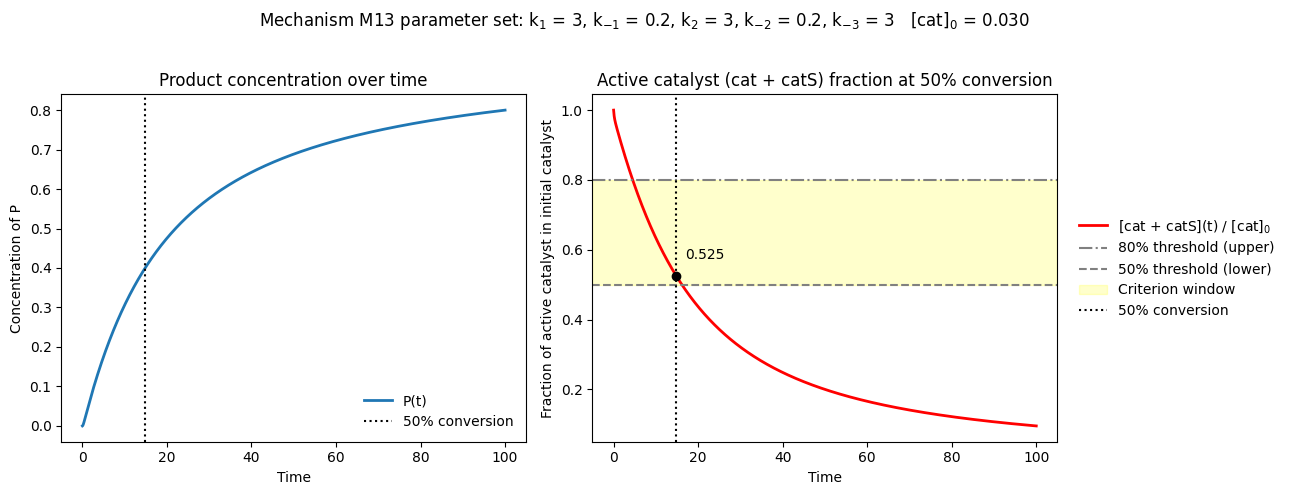

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)



In [53]:
def M13_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_M13(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_cat2 = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)
        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        from scipy.interpolate import interp1d
        from scipy.optimize import root_scalar
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.8

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            
            axs[1].axhline(0.8, linestyle='-.', color='gray', label='80% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axhspan(0.5, 0.8, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko') 
            axs[1].text(t_half + 2, active_frac + 0.05, f'{active_frac:.3f}', color='black')

            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            
            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M13 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 80%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [3.0, 0.2, 3.0, 0.2]
k_3_list = [1.0, 1.5, 2.0, 3.0]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M13 with k_3 = {k_3:.3f}")
    M13_dimerization_criterion(theta)

In [54]:
def ode_M14(t, y, theta):
    S, P, cat, catS, inact_catS = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3) * catS
    dinact_catS_dt = k_3 * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_catS_dt]

def train_inits_M14():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M14():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M14_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = 10**np.random.uniform(0.2, 0.6)
        k_1 = 10**np.random.uniform(-0.5, 0.3)
        k2 = 10**np.random.uniform(0.2, 0.6)
        k_2 = 10**np.random.uniform(-0.5, 0.3)
        k_3 = 10**np.random.uniform(-1.5, -0.96)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M14_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        S, P, cat, catS, _ = y
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M14"] = ode_M14
TRAIN_INIT_FUNCS["M14"] = train_inits_M14
TEST_INIT_FUNCS["M14"] = test_inits_M14
MECH_DIM["M14"] = 5
THETA_DIM["M14"] = 5
POST_FILTER_FUNCS["M14"] = M14_activecat_post_filter
BIASED_SAMPLE_FUNCS["M14"] = sample_theta_M14_biased

In [55]:
def test_mechanism_M14():
    mechanism = "M14"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M14...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M14.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M14...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M14:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M14 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M14()

Identifying valid kinetic parameter sets for mechanism M14...
Successfully identified 5 valid kinetic parameter sets for mechanism M14.
  Parameter set 1: [2, 1.4, 3.05, 0.34, 0.107]
  Parameter set 2: [2.11, 1.23, 2.42, 0.815, 0.084]
  Parameter set 3: [2.82, 0.375, 2.42, 0.581, 0.0716]
  Parameter set 4: [3.36, 1.22, 2.82, 1.71, 0.0412]
  Parameter set 5: [2.04, 0.379, 2.05, 0.659, 0.0959]

Generating training, validation, and test datasets for mechanism M14...

Summary of data generation for mechanism M14:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M14 completed successfully.


Testing M14 with k_3 = 0.030
Initial cat = 0.030, Max P = 0.897, Time at 50% P_max = 21.94, Active cat fraction = 0.768


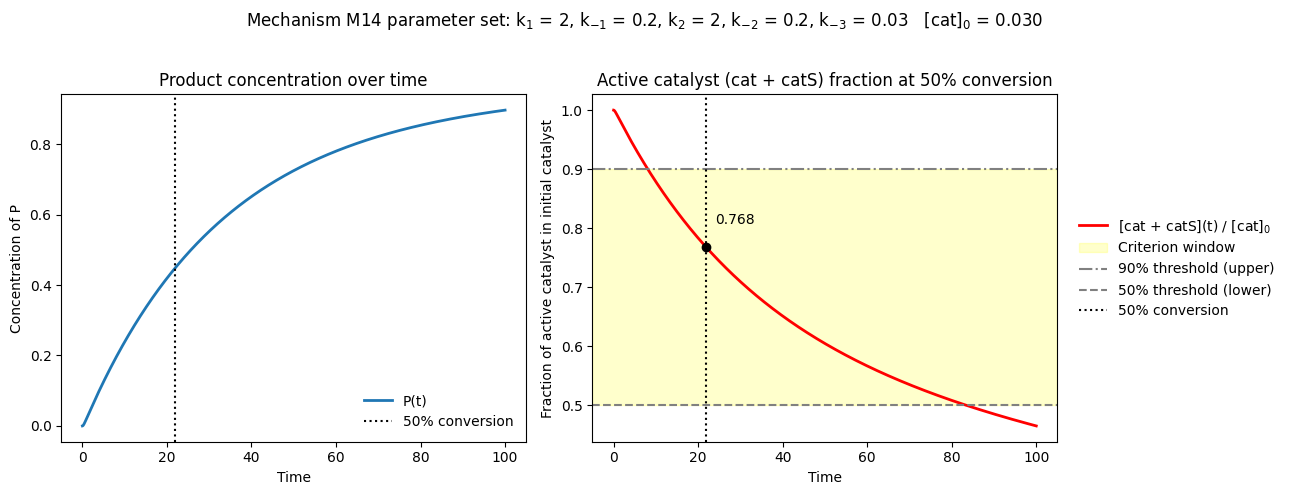

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M14 with k_3 = 0.050
Initial cat = 0.030, Max P = 0.805, Time at 50% P_max = 20.91, Active cat fraction = 0.654


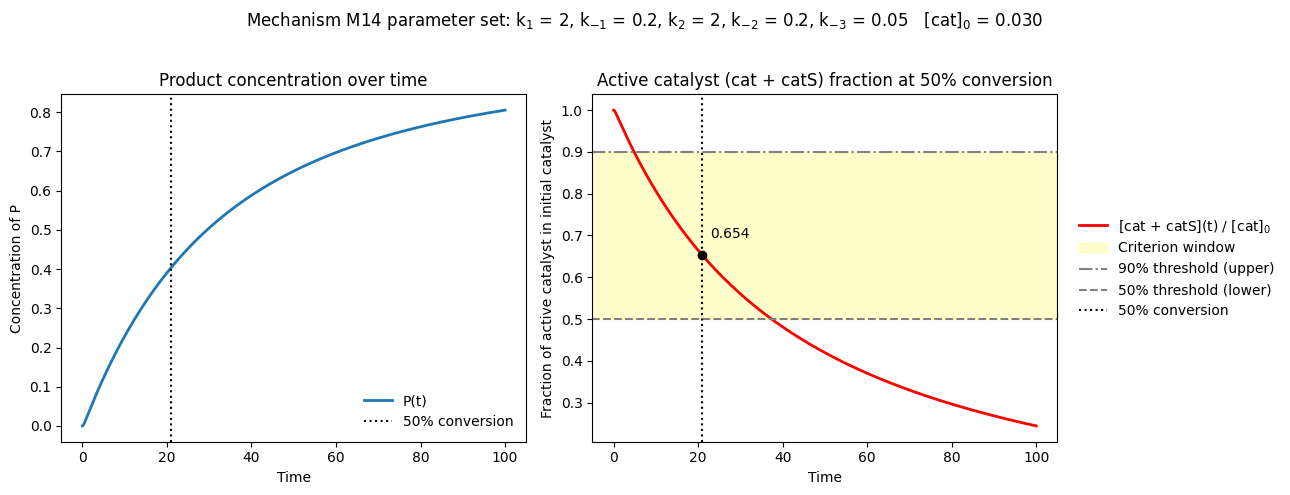

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M14 with k_3 = 0.070
Initial cat = 0.030, Max P = 0.698, Time at 50% P_max = 18.71, Active cat fraction = 0.582


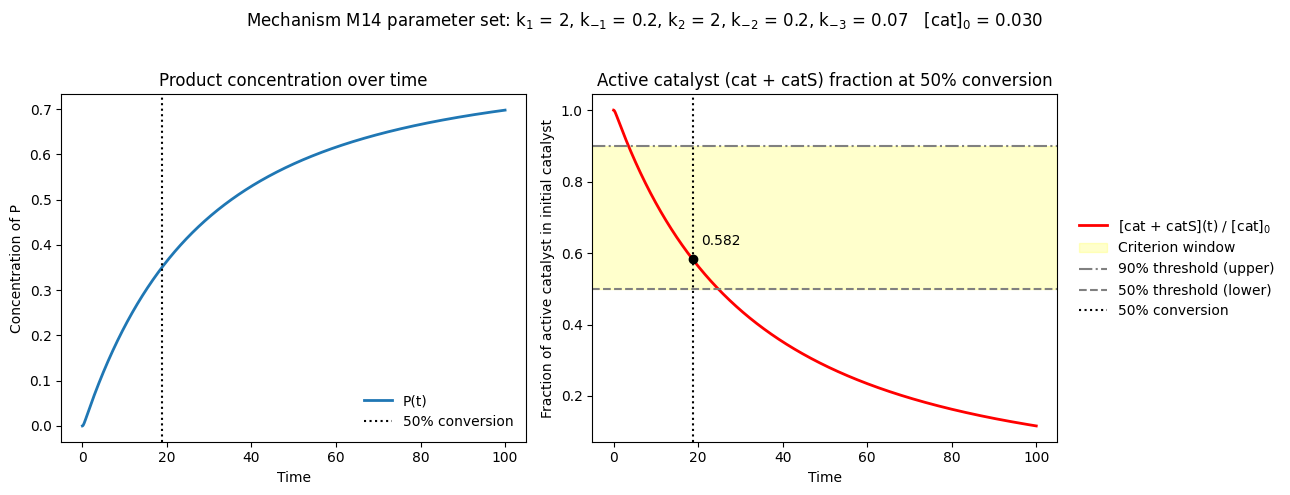

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M14 with k_3 = 0.090
Initial cat = 0.030, Max P = 0.595, Time at 50% P_max = 16.17, Active cat fraction = 0.544


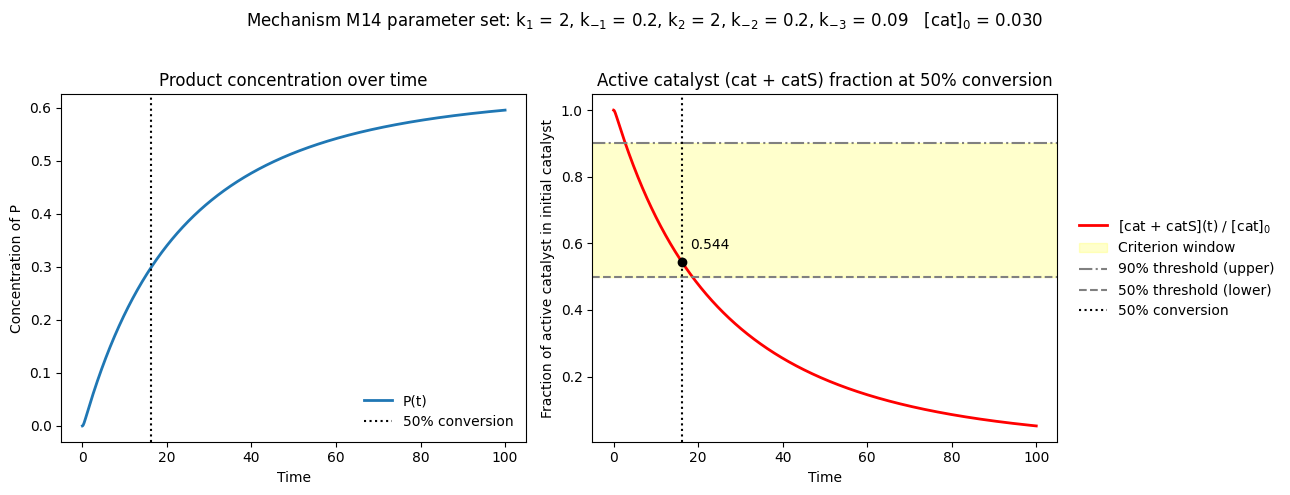

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M14 with k_3 = 0.110
Initial cat = 0.030, Max P = 0.509, Time at 50% P_max = 13.86, Active cat fraction = 0.525


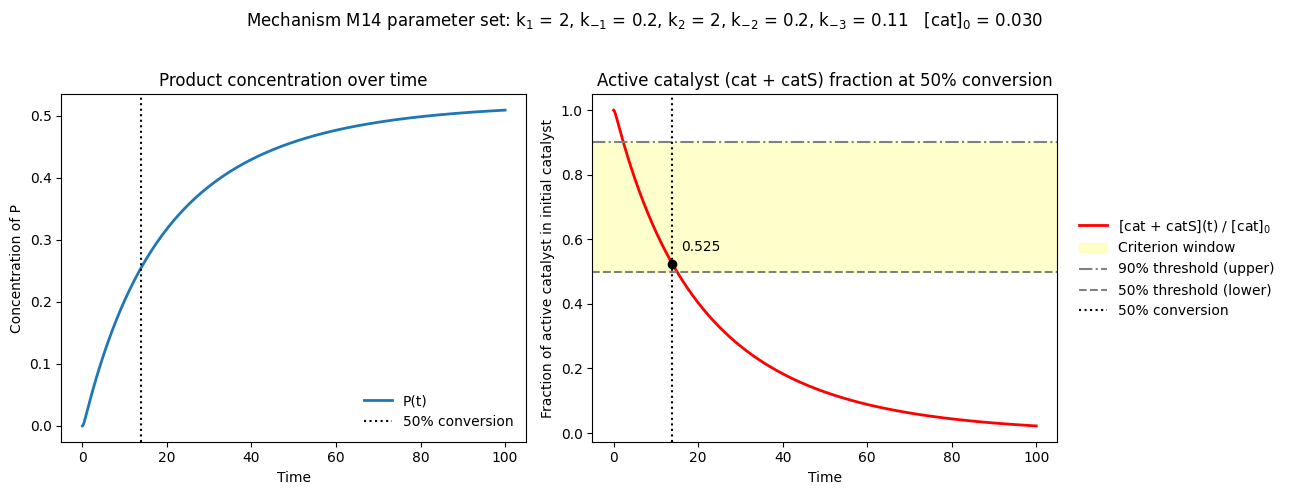

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [57]:
def M14_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M14(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6, atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration was unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_catS = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        from scipy.interpolate import interp1d
        from scipy.optimize import root_scalar
        P_interp = interp1d(t, P, kind='linear')
        cat_interp = interp1d(t, cat, kind='linear')
        catS_interp = interp1d(t, catS, kind='linear')

        def half_max_fn(ti):
            return P_interp(ti) - 0.5 * P_max

        try:
            sol_root = root_scalar(half_max_fn, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].plot(t_half, active_frac, 'ko')
            axs[1].text(t_half + 2, active_frac + 0.04, f'{active_frac:.3f}', color='black')
 
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            
            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Active catalyst / [cat]$_0$")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M14 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if passed:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [2.0, 0.2, 2.0, 0.2]
k_3_list = [0.03, 0.05, 0.07, 0.09, 0.11]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M14 with k_3 = {k_3:.3f}")
    M14_dimerization_criterion(theta)

In [58]:
def ode_M15(t, y, theta):
    S, P, cat, catS, inhibitor, inact_catSI = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3 * inhibitor) * catS
    dinhibitor_dt = -k_3 * inhibitor * catS
    dinact_catSI_dt = k_3 * inhibitor * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinhibitor_dt, dinact_catSI_dt]

def train_inits_M15():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0, 0.0])
    return inits

def test_inits_M15():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 1.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 1.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M15_biased(n=1):
    thetas = []
    for _ in range(n):
        k1 = np.random.uniform(2.0, 8.0)
        k_1 = np.random.uniform(0.4, 2.1)
        k2 = np.random.uniform(1.8, 3.7)
        k_2 = np.random.uniform(0.4, 2.1)
        k_3 = np.random.uniform(0.019, 0.029)
        theta = [round(k1, 3), round(k_1, 3), round(k2, 3), round(k_2, 3), round(k_3, 3)]
        thetas.append(theta)
    return thetas

def M15_inactcat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 1.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            (0, 100), y0, method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6, atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        P, catSI = sol.y[1], sol.y[5]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        catSI_interp = interp1d(t, catSI, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        inact_cat = catSI_interp(t_half)
        if inact_cat > 0.1 * cat0:
            return True
    return False

ODE_FUNCS["M15"] = ode_M15
TRAIN_INIT_FUNCS["M15"] = train_inits_M15
TEST_INIT_FUNCS["M15"] = test_inits_M15
MECH_DIM["M15"] = 6
THETA_DIM["M15"] = 5
POST_FILTER_FUNCS["M15"] = M15_inactcat_post_filter
BIASED_SAMPLE_FUNCS["M15"] = sample_theta_M15_biased

In [59]:
def test_mechanism_M15():
    mechanism = "M15"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M15...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M15.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M15...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M15:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M15 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M15()

Identifying valid kinetic parameter sets for mechanism M15...
Successfully identified 5 valid kinetic parameter sets for mechanism M15.
  Parameter set 1: [2.956, 1.042, 2.174, 1.904, 0.024]
  Parameter set 2: [4.309, 2.016, 2.84, 1.511, 0.024]
  Parameter set 3: [6.686, 1.724, 2.798, 1.554, 0.023]
  Parameter set 4: [3.671, 1.489, 1.827, 1.756, 0.022]
  Parameter set 5: [5.112, 0.951, 1.92, 1.19, 0.022]

Generating training, validation, and test datasets for mechanism M15...

Summary of data generation for mechanism M15:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M15 completed successfully.


Testing M15 with k₋3 = 0.015
Initial cat = 0.030, Max P = 0.725, Time at 50% P_max = 33.04, Inactive catSI fraction = 0.186


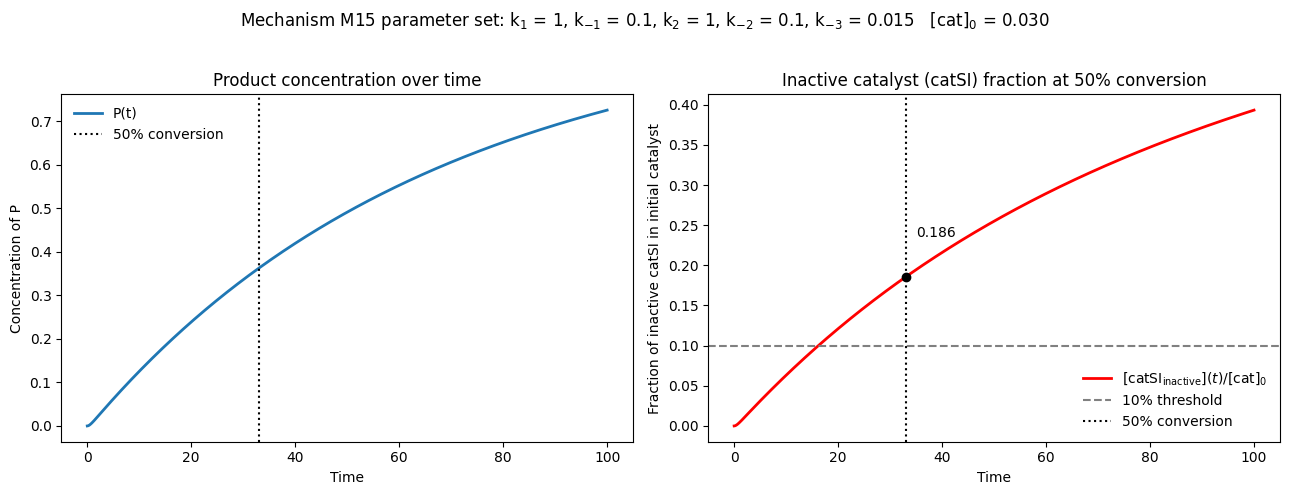

Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)

Testing M15 with k₋3 = 0.020
Initial cat = 0.030, Max P = 0.688, Time at 50% P_max = 32.11, Inactive catSI fraction = 0.234


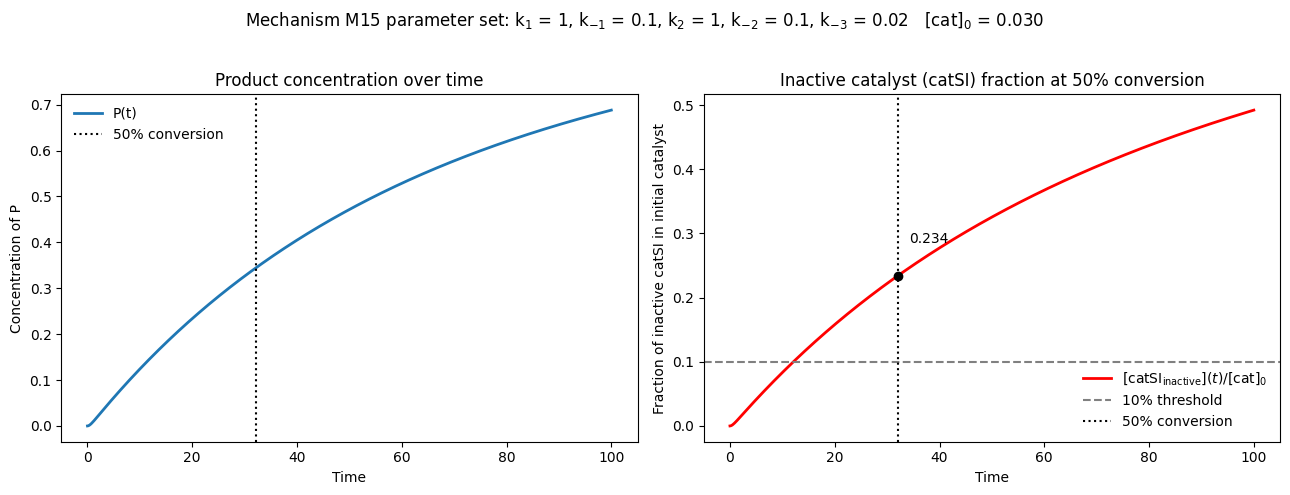

Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)

Testing M15 with k₋3 = 0.025
Initial cat = 0.030, Max P = 0.651, Time at 50% P_max = 31.06, Inactive catSI fraction = 0.277


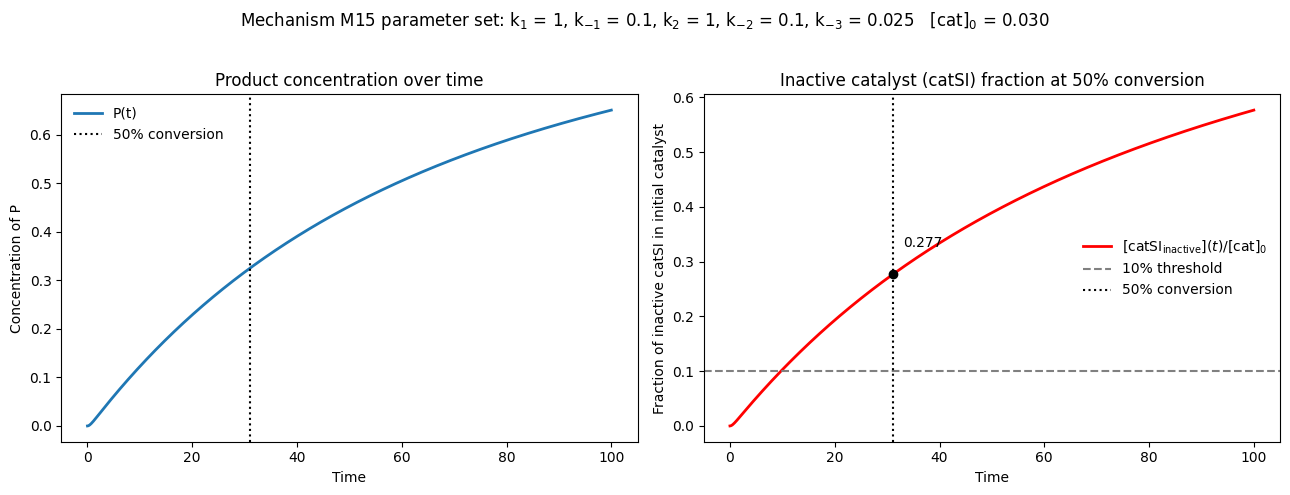

Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)

Testing M15 with k₋3 = 0.030
Initial cat = 0.030, Max P = 0.615, Time at 50% P_max = 29.93, Inactive catSI fraction = 0.313


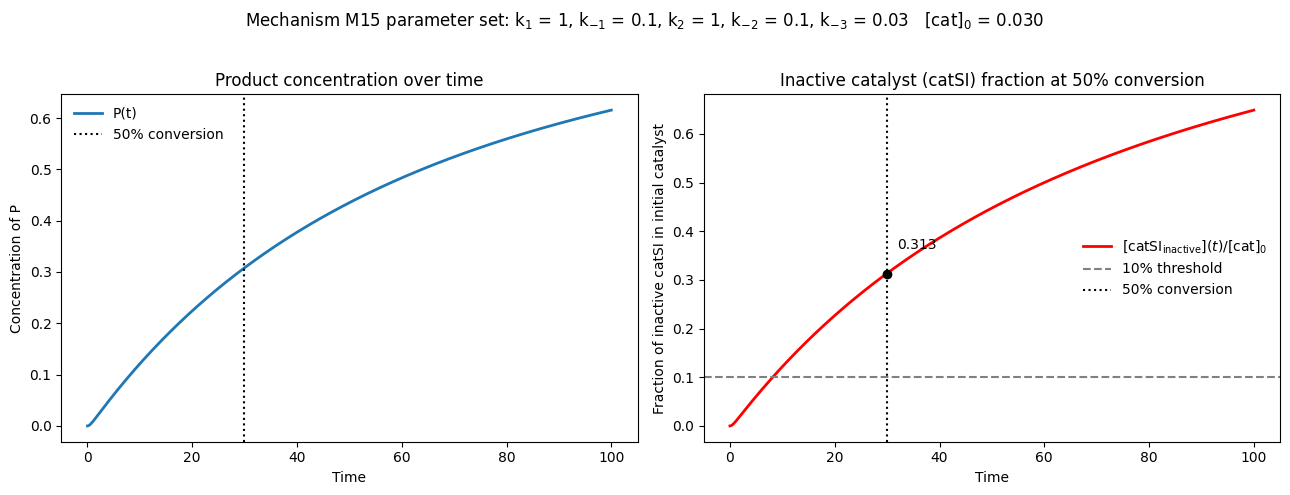

Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)

Testing M15 with k₋3 = 0.035
Initial cat = 0.030, Max P = 0.581, Time at 50% P_max = 28.74, Inactive catSI fraction = 0.344


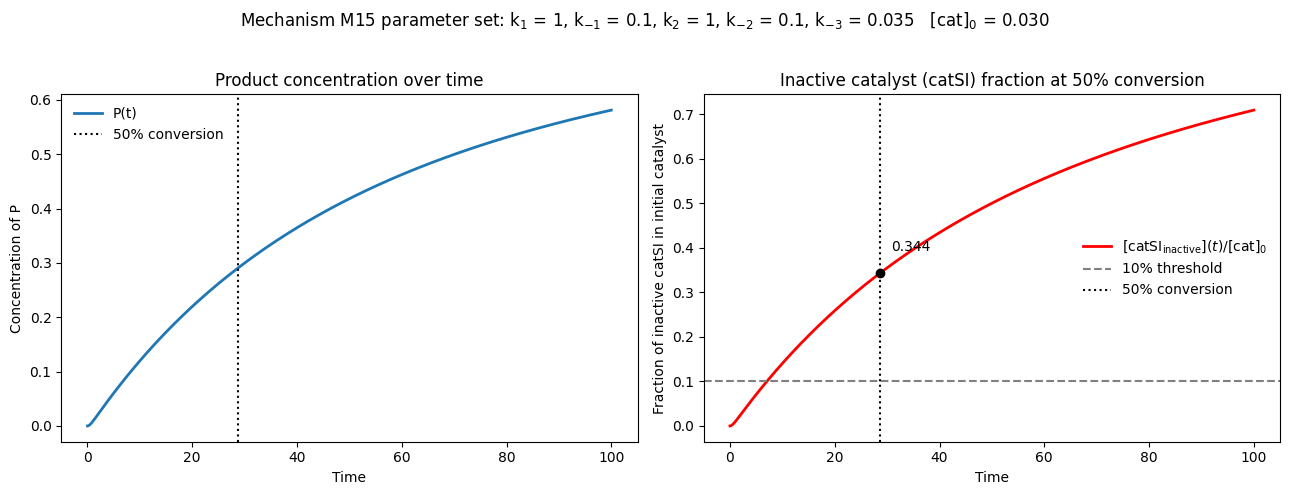

Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)



In [60]:
def M15_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 1.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M15(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method="LSODA",
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inhibitor, catSI = sol.y
        P_max = np.max(P)
        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        catSI_interp = interp1d(t, catSI, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        inact_cat = catSI_interp(t_half)
        ratio = inact_cat / (cat0 + 1e-10)
        passed = ratio > 0.1

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Inactive catSI fraction = {ratio:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, catSI / (cat0 + 1e-10),
                        label=r'$[\mathrm{catSI}_{\mathrm{inactive}}](t) / [\mathrm{cat}]_0$', color='red', linewidth=2)
            axs[1].axhline(0.1, linestyle='--', color='gray', label='10% threshold')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].plot(t_half, ratio, 'ko')
            axs[1].text(t_half + 2, ratio + 0.05, f'{ratio:.3f}', color='black')

            axs[1].set_title("Inactive catalyst (catSI) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of inactive catSI in initial catalyst")
            axs[1].legend(frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']  
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M15 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}") 

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if passed:
                print("Filter result: Pass (inactive catSI fraction > 10% at 50% conversion.)\n")
            else:
               print("Filter result: Fail (inactive catSI fraction ≤ 10% at 50% conversion.)\n")


        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False


base_theta = [1.0, 0.1, 1.0, 0.1]  
k_3_list = [0.015, 0.02, 0.025, 0.03, 0.035]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M15 with k₋3 = {k_3:.3f}")
    M15_dimerization_criterion(theta, verbose=True)

In [61]:
def ode_M16(t, y, theta):
    S, P, cat, catS, inact_catS2 = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat - k_3 * S * catS
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3 * S) * catS
    dinact_catS2_dt = k_3 * S * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_catS2_dt]

def train_inits_M16():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M16():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M16_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(6.0, 12.5)
        k_1  = np.random.uniform(0.8, 2.1)
        k2   = np.random.uniform(2.1, 3.1)
        k_2  = np.random.uniform(0.6, 2.2)
        k_3  = np.random.uniform(0.021, 0.031)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M16_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0] 
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100), y0=y0,
                            method='LSODA', t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6, atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M16"] = ode_M16
TRAIN_INIT_FUNCS["M16"] = train_inits_M16
TEST_INIT_FUNCS["M16"] = test_inits_M16
MECH_DIM["M16"] = 5
THETA_DIM["M16"] = 5
POST_FILTER_FUNCS["M16"] = M16_activecat_post_filter
BIASED_SAMPLE_FUNCS["M16"] = sample_theta_M16_biased

In [62]:
def test_mechanism_M16():
    mechanism = "M16"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M16...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M16.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M16...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M16:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M16 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M16()

Identifying valid kinetic parameter sets for mechanism M16...
Successfully identified 5 valid kinetic parameter sets for mechanism M16.
  Parameter set 1: [7.96, 1.84, 3.03, 1.52, 0.0279]
  Parameter set 2: [9.01, 0.801, 2.88, 1.18, 0.0284]
  Parameter set 3: [12, 1.33, 2.45, 1.05, 0.0226]
  Parameter set 4: [6.26, 1.87, 2.62, 1.15, 0.0265]
  Parameter set 5: [6.79, 2, 2.99, 0.836, 0.0303]

Generating training, validation, and test datasets for mechanism M16...

Summary of data generation for mechanism M16:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M16 completed successfully.


Testing M16 with k₋3 = 0.015
Initial cat = 0.030, Max P = 0.758, Time at 50% P_max = 34.37, Active cat fraction = 0.846


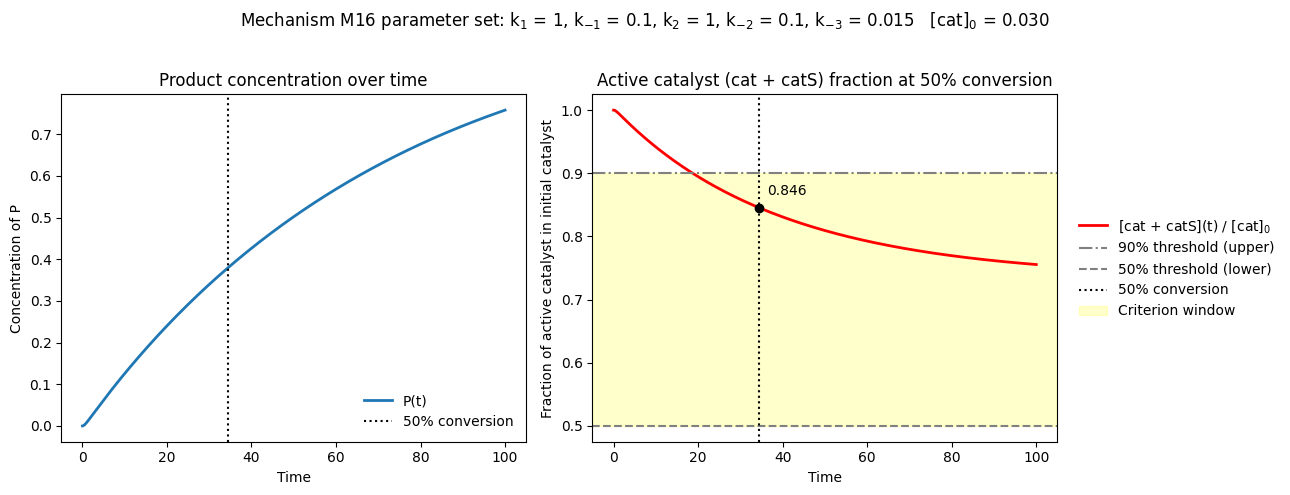

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M16 with k₋3 = 0.020
Initial cat = 0.030, Max P = 0.730, Time at 50% P_max = 33.98, Active cat fraction = 0.800


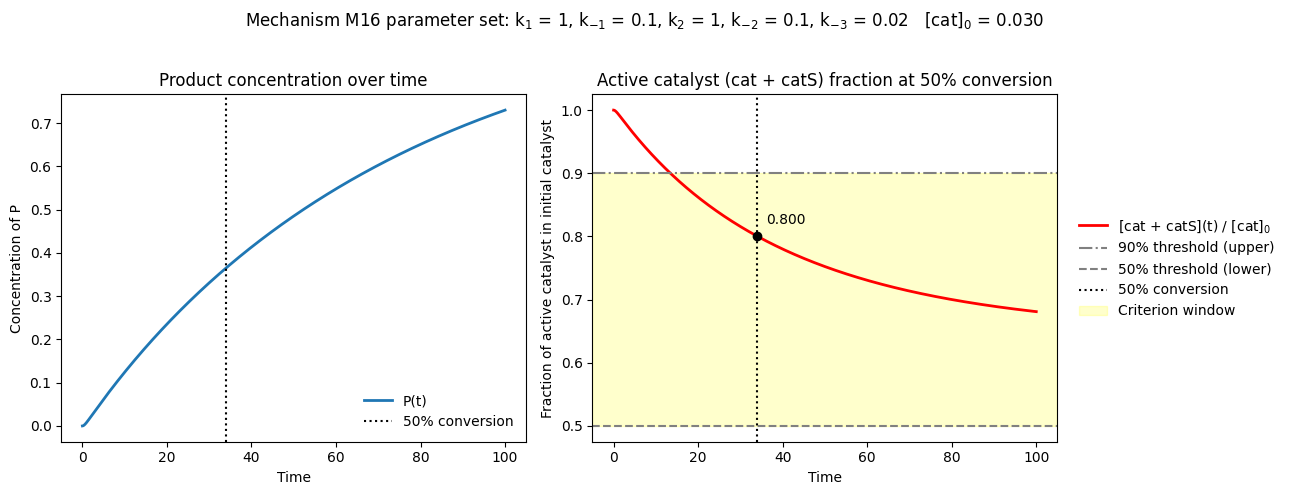

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M16 with k₋3 = 0.025
Initial cat = 0.030, Max P = 0.702, Time at 50% P_max = 33.48, Active cat fraction = 0.759


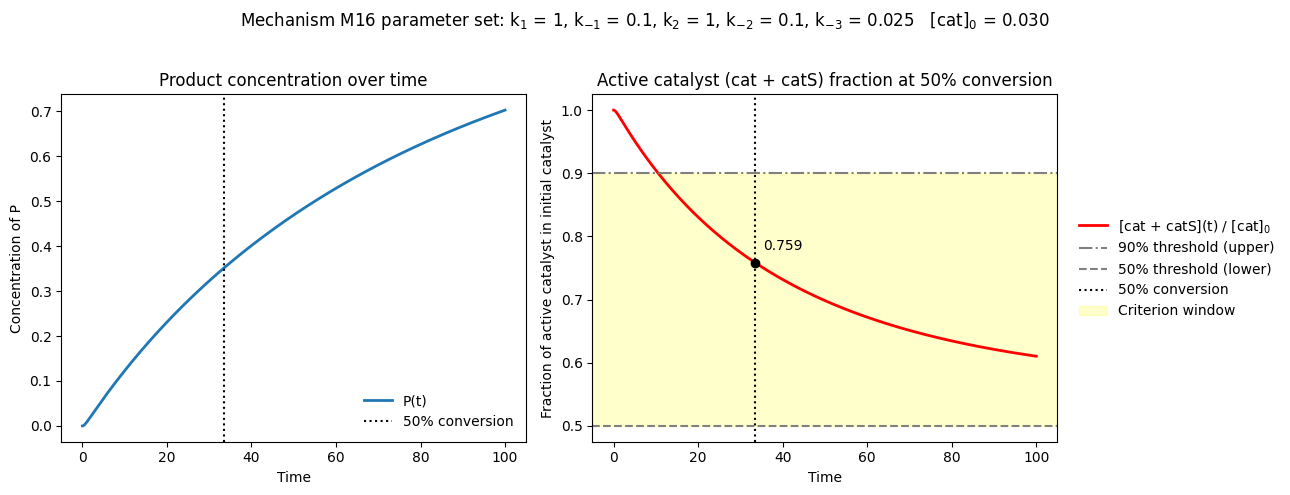

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M16 with k₋3 = 0.030
Initial cat = 0.030, Max P = 0.674, Time at 50% P_max = 32.87, Active cat fraction = 0.720


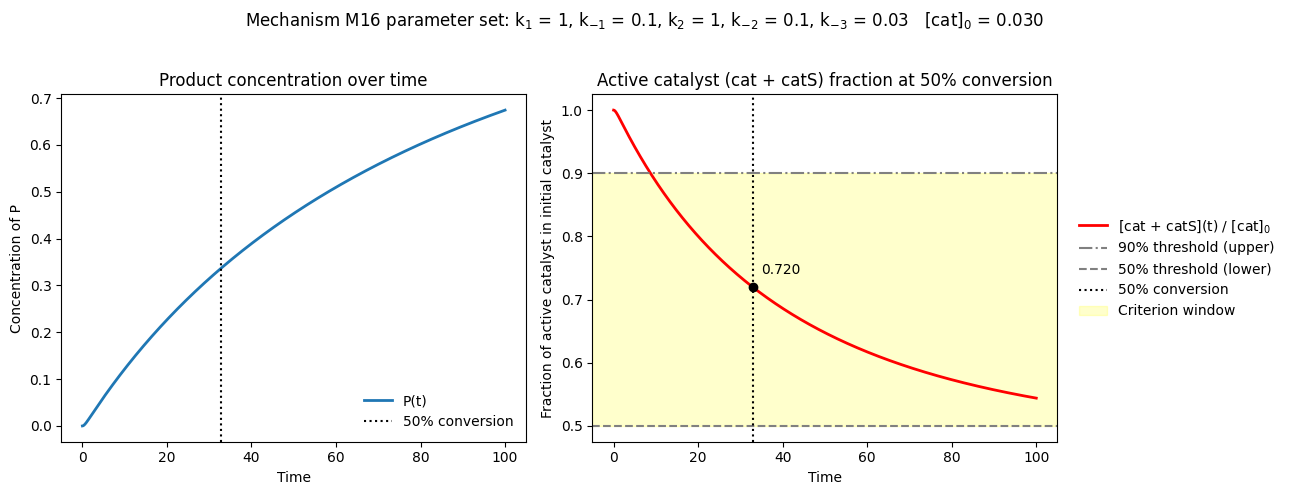

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M16 with k₋3 = 0.035
Initial cat = 0.030, Max P = 0.646, Time at 50% P_max = 32.16, Active cat fraction = 0.685


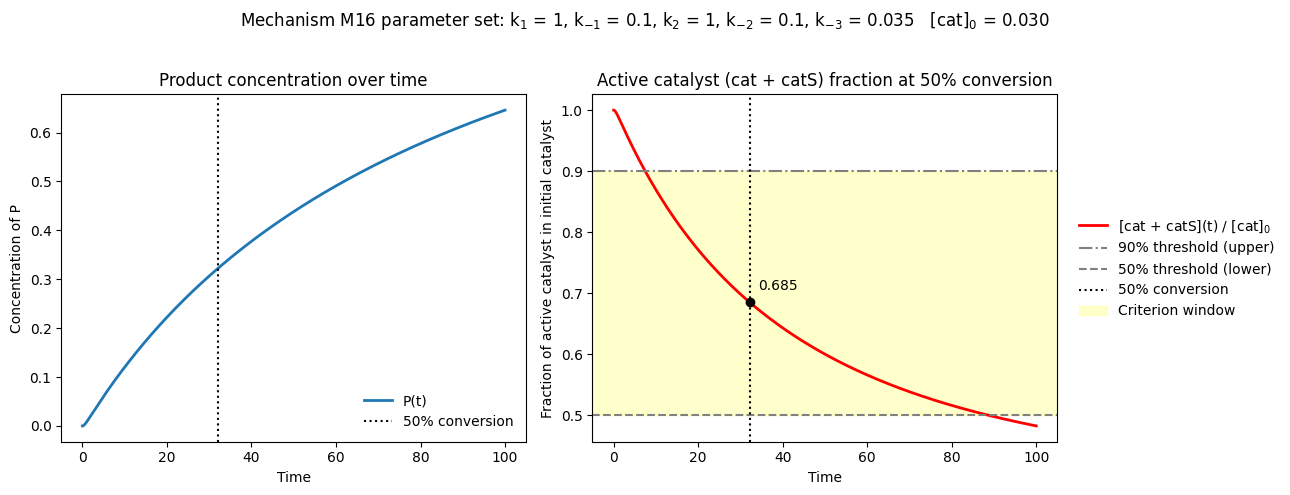

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [63]:
def M16_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)  

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M16(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method="LSODA",
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_catS2 = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))
            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko')
            axs[1].text(t_half + 2, active_frac + 0.02, f'{active_frac:.3f}', color='black')

            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M16 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if passed:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False


base_theta = [1.0, 0.1, 1.0, 0.1]  
k_3_list = [0.015, 0.02, 0.025, 0.03, 0.035]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M16 with k₋3 = {k_3:.3f}")
    M16_dimerization_criterion(theta, verbose=True)

In [64]:
def ode_M17(t, y, theta):
    S, P, cat, catS, inact_catSP = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P - k_3 * P * catS
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3 * P) * catS
    dinact_catSP_dt = k_3 * P * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_catSP_dt]

def train_inits_M17():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M17():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M17_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(6.5, 13.0)
        k_1  = np.random.uniform(0.7, 2.5)
        k2   = np.random.uniform(2.0, 5.5)
        k_2  = np.random.uniform(0.7, 2.5)
        k_3  = np.random.uniform(0.11, 0.23)
        theta = [round(k1, 3), round(k_1, 3), round(k2, 3), round(k_2, 3), round(k_3, 3)]
        thetas.append(theta)
    return thetas

def M17_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0] 
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        P, cat, catS = sol.y[1], sol.y[2], sol.y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception:
            continue
        if abs(P_interp(t_half)/(P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.9:
            return True
    return False

ODE_FUNCS["M17"] = ode_M17
TRAIN_INIT_FUNCS["M17"] = train_inits_M17
TEST_INIT_FUNCS["M17"] = test_inits_M17
MECH_DIM["M17"] = 5
THETA_DIM["M17"] = 5
POST_FILTER_FUNCS["M17"] = M17_activecat_post_filter
BIASED_SAMPLE_FUNCS["M17"] = sample_theta_M17_biased

In [65]:
def test_mechanism_M17():
    mechanism = "M17"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M17...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M17.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M17...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M17:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M17 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M17()

Identifying valid kinetic parameter sets for mechanism M17...
Successfully identified 5 valid kinetic parameter sets for mechanism M17.
  Parameter set 1: [9.182, 1.349, 5.469, 2.369, 0.195]
  Parameter set 2: [7.17, 1.082, 3.003, 1.856, 0.206]
  Parameter set 3: [6.697, 0.907, 3.073, 1.354, 0.21]
  Parameter set 4: [6.896, 0.78, 4.714, 1.297, 0.201]
  Parameter set 5: [12.34, 1.064, 3.773, 1.201, 0.227]

Generating training, validation, and test datasets for mechanism M17...

Summary of data generation for mechanism M17:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M17 completed successfully.


Testing M17 with k₋3 = 0.100
Initial cat = 0.030, Max P = 0.616, Time at 50% P_max = 26.81, Active cat fraction = 0.834


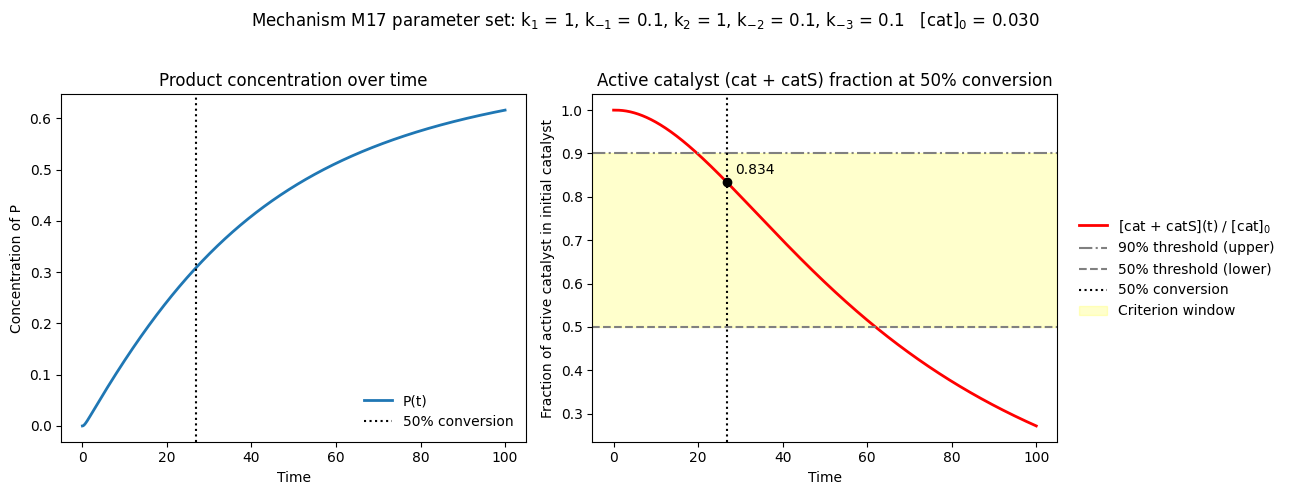

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M17 with k₋3 = 0.150
Initial cat = 0.030, Max P = 0.543, Time at 50% P_max = 23.78, Active cat fraction = 0.805


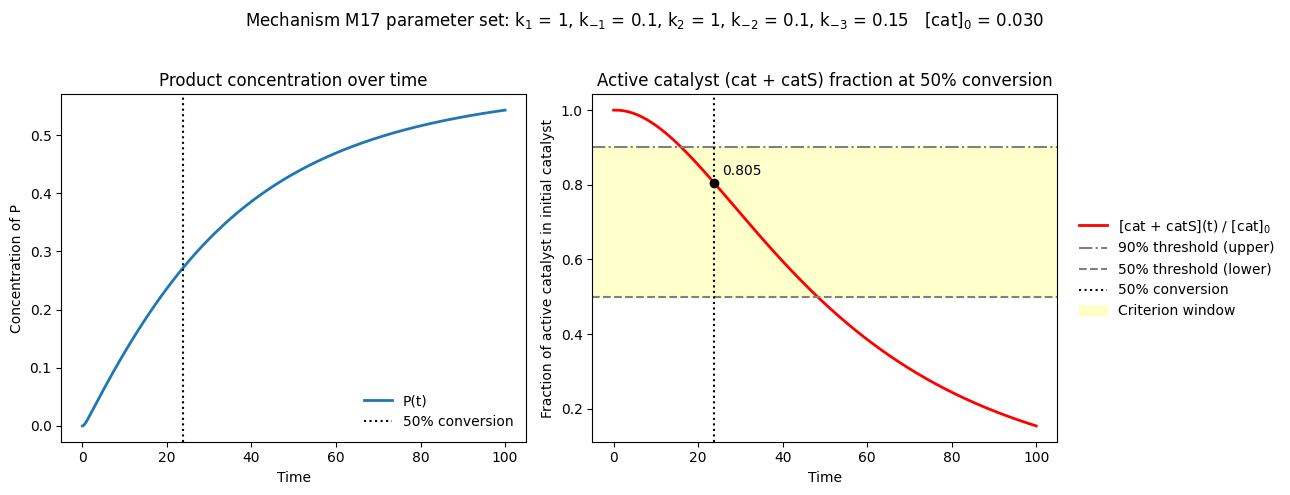

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M17 with k₋3 = 0.200
Initial cat = 0.030 → Fail (max yield = 0.487 < 50%)
Initial cat = 0.040, Max P = 0.558, Time at 50% P_max = 18.83, Active cat fraction = 0.792


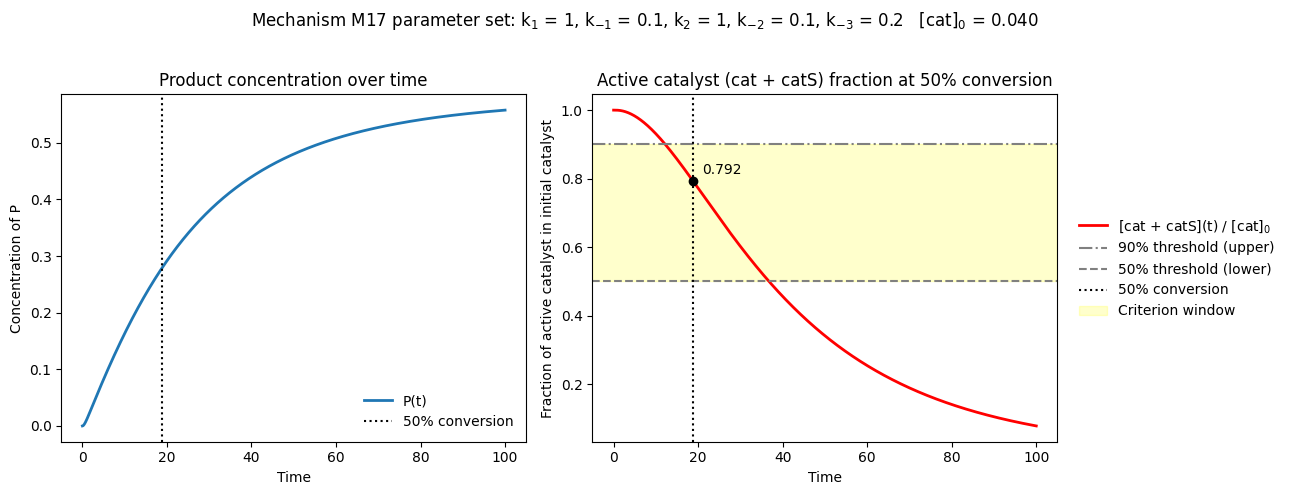

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)

Testing M17 with k₋3 = 0.250
Initial cat = 0.030 → Fail (max yield = 0.444 < 50%)
Initial cat = 0.040, Max P = 0.508, Time at 50% P_max = 17.15, Active cat fraction = 0.784


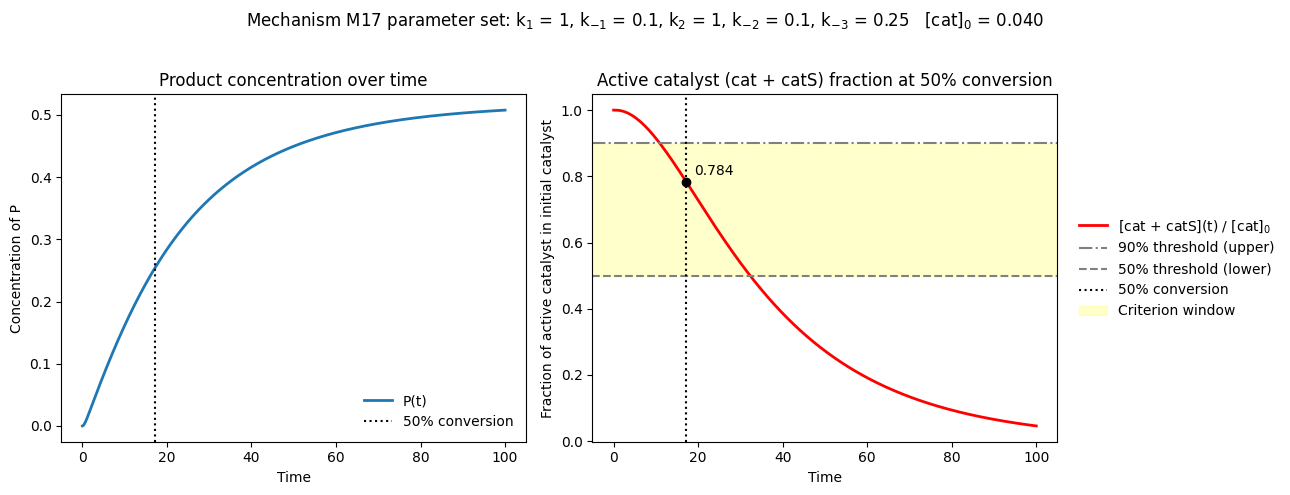

Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)



In [66]:
def M17_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)  
    
    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M17(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6, atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_catSP = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)
        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        from scipy.interpolate import interp1d
        from scipy.optimize import root_scalar
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.9

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko')
            axs[1].text(t_half + 2, active_frac + 0.02, f'{active_frac:.3f}', color='black')

            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M17 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 90%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 90%] at 50% conversion.)\n")
        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [0.10, 0.15, 0.20, 0.25]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M17 with k₋3 = {k_3:.3f}")
    M17_dimerization_criterion(theta, verbose=True)

In [67]:
def ode_M18(t, y, theta):
    S, P, cat, catS, inact_cat2S2 = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3 * catS) * catS
    dinact_cat2S2_dt = k_3 * catS ** 2
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_cat2S2_dt]

def train_inits_M18():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M18():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M18_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(7.0, 18.9)      
        k_1  = np.random.uniform(0.35, 4.2)
        k2   = np.random.uniform(0.85, 2.42)
        k_2  = np.random.uniform(0.32, 4.48)
        k_3  = np.random.uniform(1.69, 2.73)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M18_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(
                lambda t, y: ode_func(t, y, theta),
                t_span=(0, 100),
                y0=y0,
                method='LSODA',
                t_eval=np.linspace(0, 100, 1500),
                rtol=1e-6,
                atol=1e-9
            )
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.8:
            return True
    return False

ODE_FUNCS["M18"] = ode_M18
TRAIN_INIT_FUNCS["M18"] = train_inits_M18
TEST_INIT_FUNCS["M18"] = test_inits_M18
MECH_DIM["M18"] = 5
THETA_DIM["M18"] = 5
POST_FILTER_FUNCS["M18"] = M18_activecat_post_filter
BIASED_SAMPLE_FUNCS["M18"] = sample_theta_M18_biased

In [68]:
def test_mechanism_M18():
    mechanism = "M18"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M18...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M18.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M18...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M18:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M18 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M18()

Identifying valid kinetic parameter sets for mechanism M18...
Successfully identified 5 valid kinetic parameter sets for mechanism M18.
  Parameter set 1: [10.5, 1.44, 2.37, 2.55, 2.55]
  Parameter set 2: [7.53, 0.518, 2.27, 3.13, 2.04]
  Parameter set 3: [14.5, 2.34, 1.5, 0.741, 1.84]
  Parameter set 4: [7.43, 1.11, 1.81, 1.91, 2.23]
  Parameter set 5: [14.7, 3.2, 1.75, 0.878, 2.71]

Generating training, validation, and test datasets for mechanism M18...

Summary of data generation for mechanism M18:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M18 completed successfully.


Testing M18 with k₋3 = 1.500
Initial cat = 0.030, Max P = 0.727, Time at 50% P_max = 33.89, Active cat fraction = 0.790


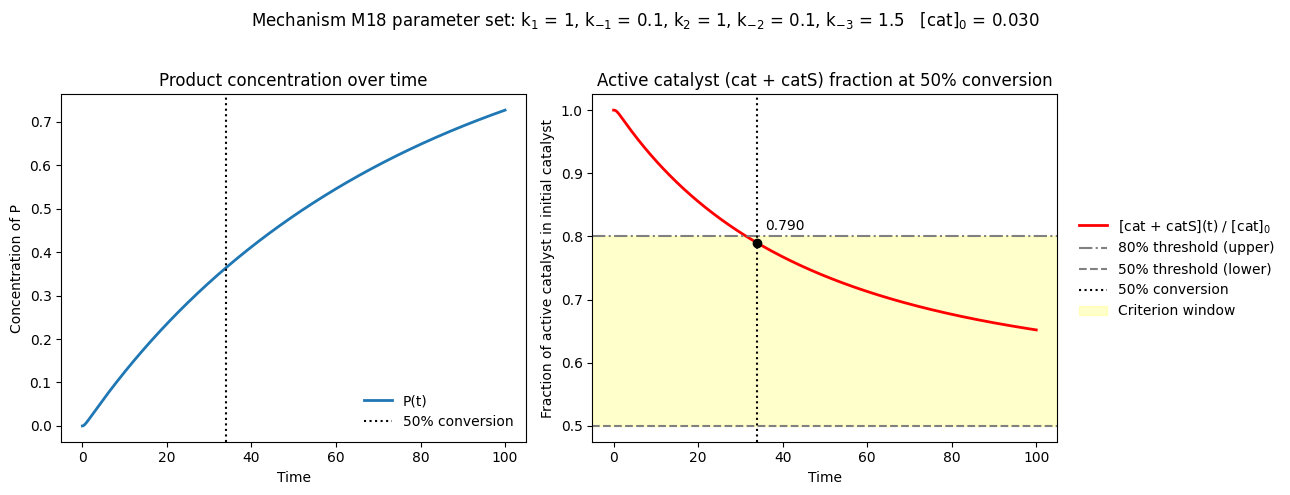

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M18 with k₋3 = 2.000
Initial cat = 0.030, Max P = 0.695, Time at 50% P_max = 33.43, Active cat fraction = 0.740


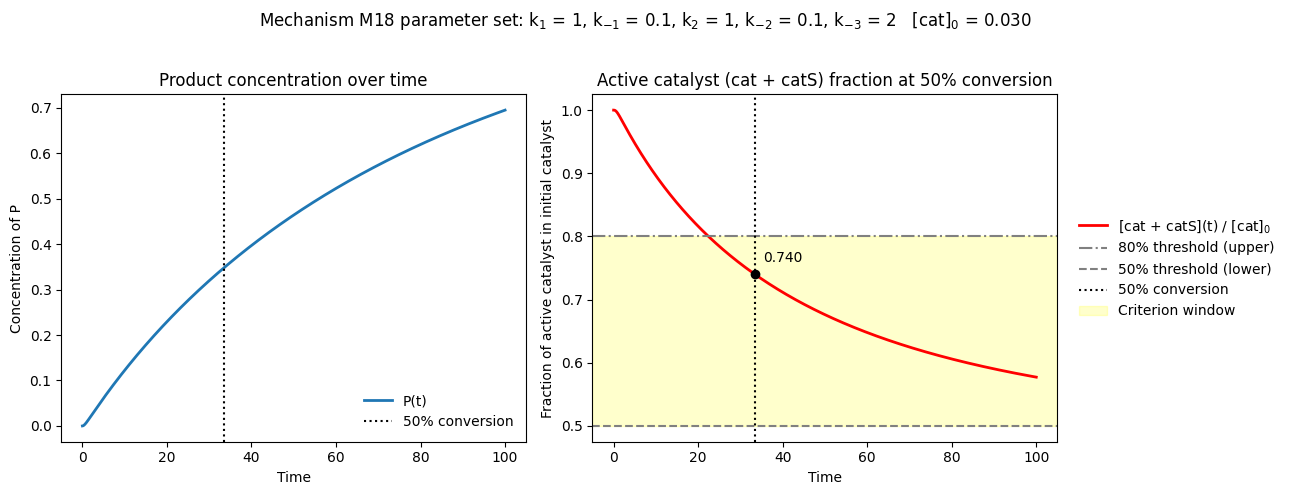

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M18 with k₋3 = 2.500
Initial cat = 0.030, Max P = 0.666, Time at 50% P_max = 32.93, Active cat fraction = 0.697


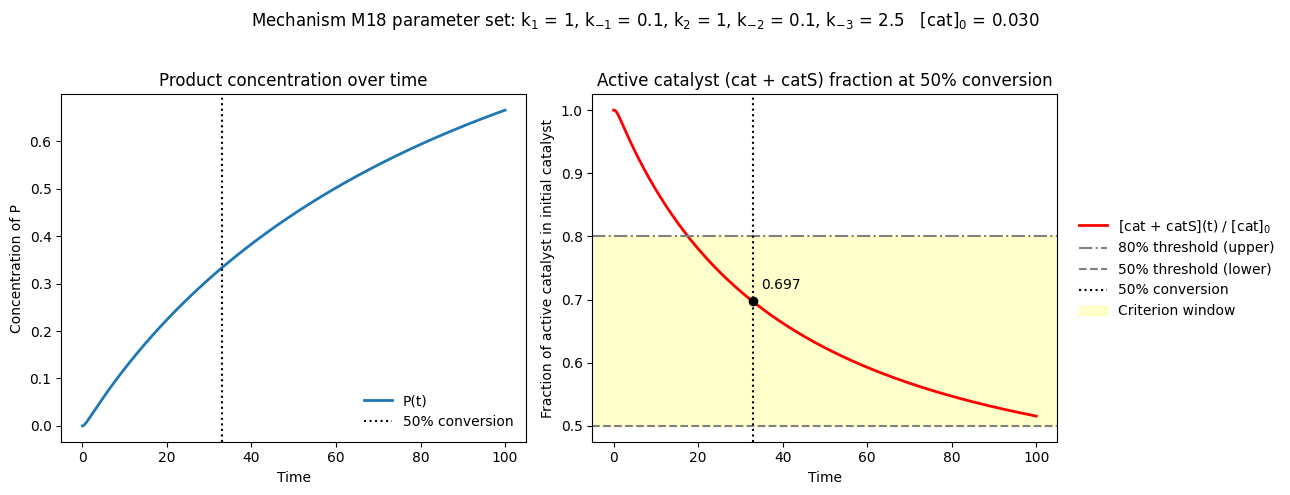

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)

Testing M18 with k₋3 = 3.000
Initial cat = 0.030, Max P = 0.639, Time at 50% P_max = 32.43, Active cat fraction = 0.660


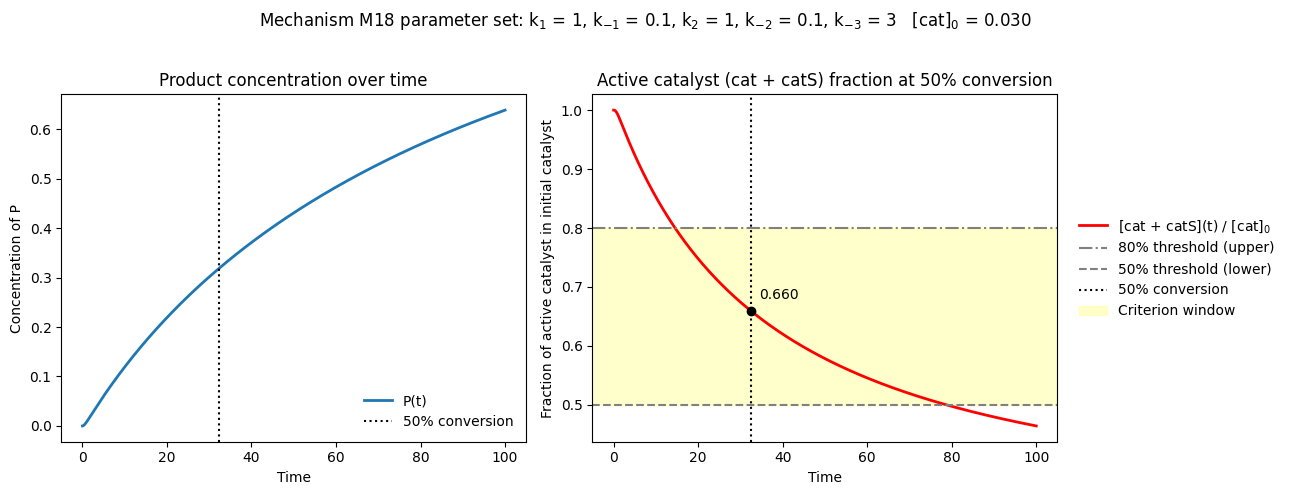

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)



In [71]:
def M18_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]
        try:
            sol = solve_ivp(
                lambda t, y: ode_M18(t, y, theta),
                t_span=(0, 100),
                y0=y0,
                method='LSODA',
                t_eval=np.linspace(0, 100, 1500),
                rtol=1e-6, atol=1e-9
            )
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_cat2S2 = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= ratio <= 0.8

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {ratio:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)
            axs[1].axhline(0.8, linestyle='-.', color='gray', label='80% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].axhspan(0.5, 0.8, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, ratio, 'ko')
            axs[1].text(t_half + 2, ratio + 0.02, f'{ratio:.3f}', color='black')

            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M18 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if passed:
                print("Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)\n")
            else:
                print("Filter result: Fail (active catalyst fraction not in [50%, 80%] at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False


base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [1.5, 2.0, 2.5, 3.0] 

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"Testing M18 with k₋3 = {k_3:.3f}")
    M18_dimerization_criterion(theta, verbose=True)

In [73]:
def ode_M19(t, y, theta):
    S, P, cat, catS, inact_cat2S = y
    k1, k_1, k2, k_2, k_3 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3 * catS) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_3 * cat) * catS
    dinact_cat2S_dt = k_3 * cat * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_cat2S_dt]

def train_inits_M19():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    return inits

def test_inits_M19():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M19_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(3.5, 7.7)
        k_1  = np.random.uniform(1.0, 3.8)
        k2   = np.random.uniform(1.7, 4.1)
        k_2  = np.random.uniform(0.65, 2.1)
        k_3  = np.random.uniform(1.34, 1.9)
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3], sig=3))
    return np.array(thetas)

def M19_activecat_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t = sol.t
        y = sol.y
        P = y[1]
        cat = y[2]
        catS = y[3]
        P_max = np.max(P)
        if P_max < 1e-6:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]],
                                   method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception:
            continue
        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            continue
        active_cat = cat_interp(t_half) + catS_interp(t_half)
        ratio = active_cat / (cat0 + 1e-10)
        if 0.5 <= ratio <= 0.8:
            return True
    return False

ODE_FUNCS["M19"] = ode_M19
TRAIN_INIT_FUNCS["M19"] = train_inits_M19
TEST_INIT_FUNCS["M19"] = test_inits_M19
MECH_DIM["M19"] = 5
THETA_DIM["M19"] = 5
POST_FILTER_FUNCS["M19"] = M19_activecat_post_filter
BIASED_SAMPLE_FUNCS["M19"] = sample_theta_M19_biased

In [74]:
def test_mechanism_M19():
    mechanism = "M19"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M19...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M19.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M19...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M19:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M19 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M19()

Identifying valid kinetic parameter sets for mechanism M19...
Successfully identified 5 valid kinetic parameter sets for mechanism M19.
  Parameter set 1: [5.33, 3.53, 2.36, 0.748, 1.81]
  Parameter set 2: [6.91, 2.7, 3.49, 1.37, 1.57]
  Parameter set 3: [6.69, 1.02, 1.75, 1.58, 1.78]
  Parameter set 4: [6.97, 2.47, 3.08, 1.75, 1.78]
  Parameter set 5: [5.21, 1.44, 3.13, 0.709, 1.56]

Generating training, validation, and test datasets for mechanism M19...

Summary of data generation for mechanism M19:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M19 completed successfully.



Testing M19 with k₋3 = 0.800
Initial cat = 0.030, Max P = 0.674, Time at 50% P_max = 32.11, Active cat fraction = 0.728


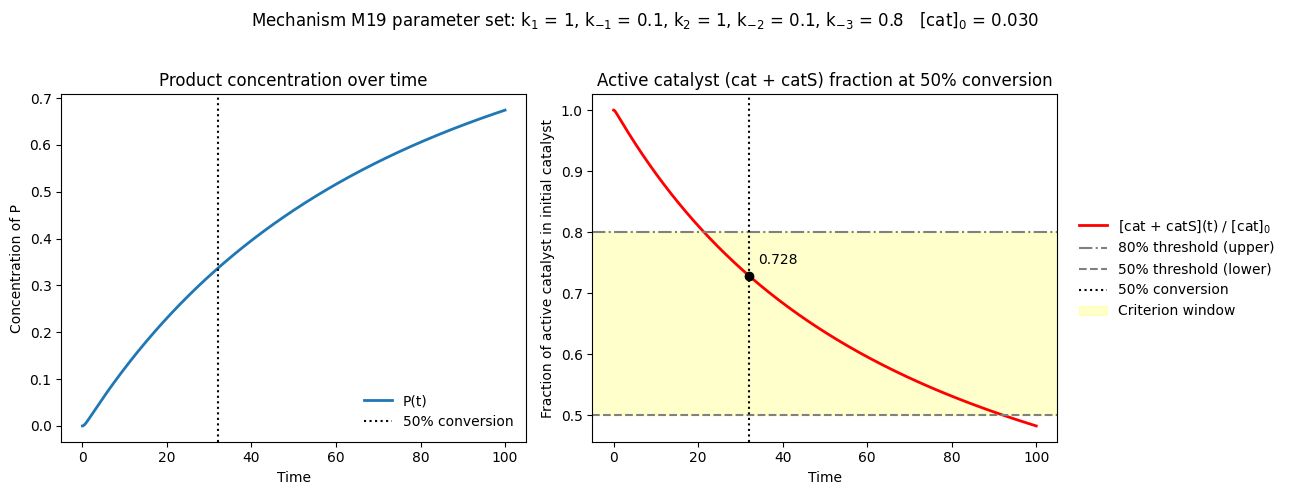

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)


Testing M19 with k₋3 = 1.000
Initial cat = 0.030, Max P = 0.644, Time at 50% P_max = 31.45, Active cat fraction = 0.686


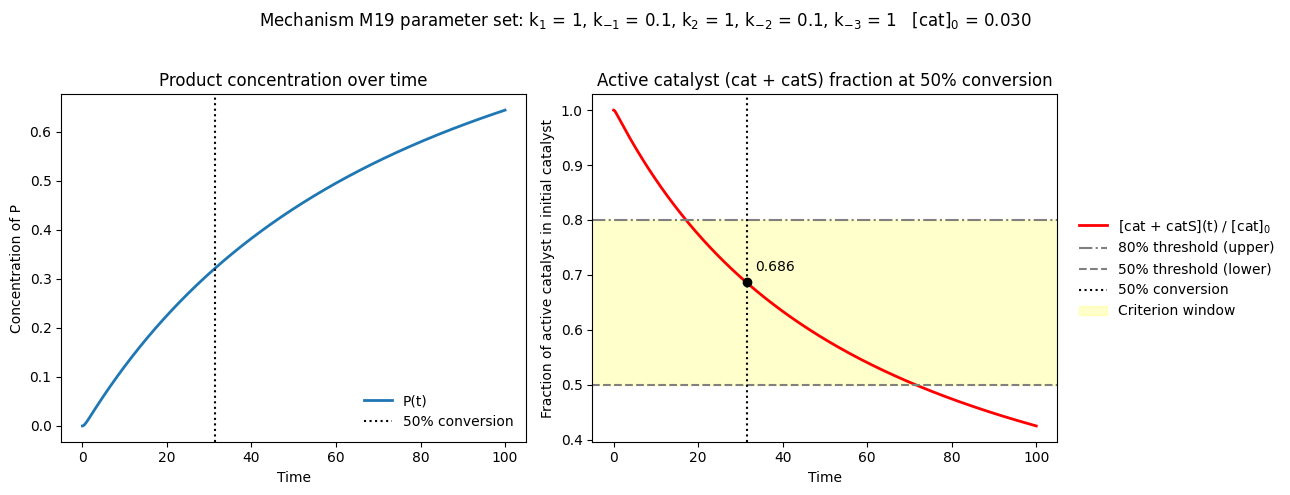

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)


Testing M19 with k₋3 = 1.500
Initial cat = 0.030, Max P = 0.579, Time at 50% P_max = 29.94, Active cat fraction = 0.604


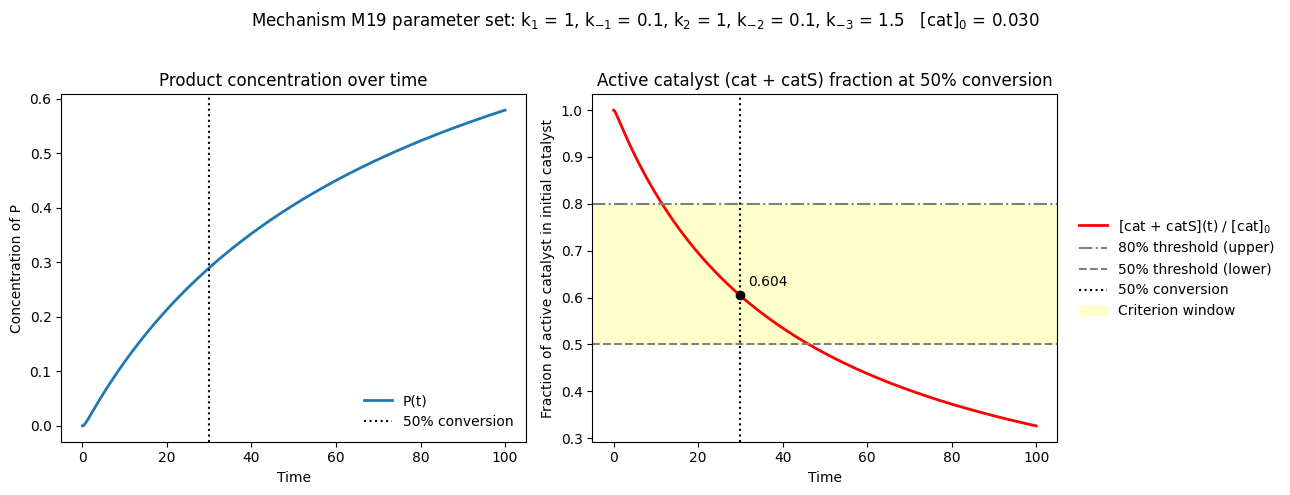

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)


Testing M19 with k₋3 = 2.000
Initial cat = 0.030, Max P = 0.528, Time at 50% P_max = 28.64, Active cat fraction = 0.545


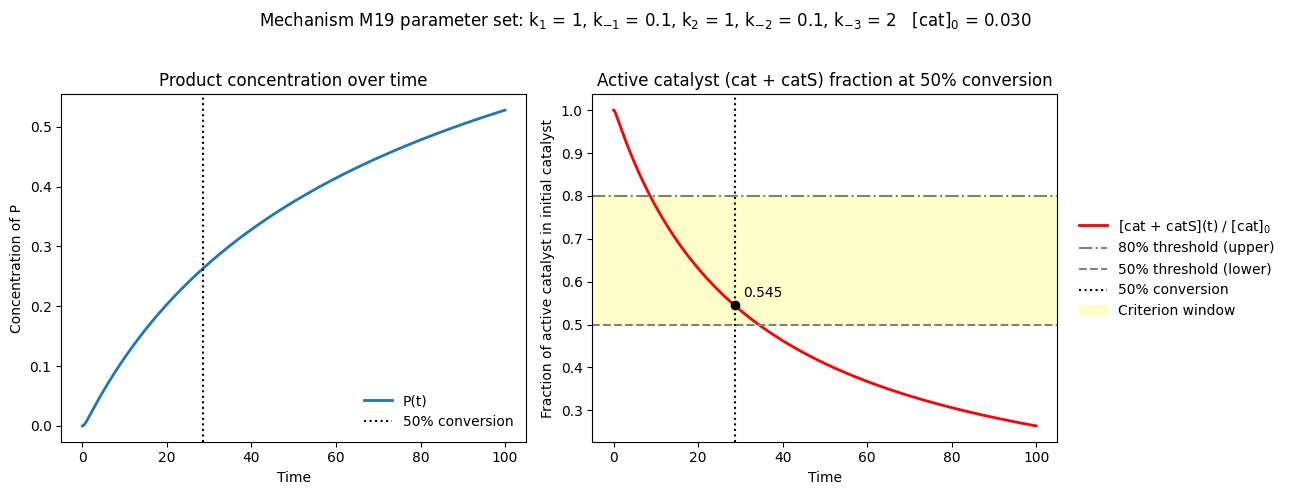

Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)



In [75]:
def M19_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)
    passed_any = False

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0]

        try:
            sol = solve_ivp(lambda t, y: ode_M19(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success:
            if verbose:
                print(f"ODE integration unsuccessful for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_cat2S = sol.y
        active_cat_t = cat + catS
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        from scipy.interpolate import interp1d
        from scipy.optimize import root_scalar
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        active_cat = cat_interp(t_half) + catS_interp(t_half)
        active_frac = active_cat / (cat0 + 1e-10)
        passed = 0.5 <= active_frac <= 0.8
        passed_any |= passed

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, "
                f"Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_frac:.3f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, active_cat_t / (cat0 + 1e-10),
                        label=r'[cat + catS](t) / [cat]$_0$', color='red', linewidth=2)

            axs[1].axhline(0.8, linestyle='-.', color='gray', label='80% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].axhspan(0.5, 0.8, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_frac, 'ko')  
            axs[1].text(t_half + 2, active_frac + 0.02, f'{active_frac:.3f}', color='black')  

            axs[1].set_title("Active catalyst (cat + catS) fraction at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of active catalyst in initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M19 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if not passed:
                print("Filter result: Fail (active catalyst fraction not in [50%, 80%] at 50% conversion.)\n")
            else:
                print("Filter result: Pass (active catalyst fraction in [50%, 80%] at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion.)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [0.8, 1.0, 1.5, 2.0]

for k_3 in k_3_list:
    theta = np.array(base_theta + [k_3])
    print(f"\nTesting M19 with k₋3 = {k_3:.3f}")
    M19_dimerization_criterion(theta, verbose=True)

In [76]:
def ode_M20(t, y, theta):
    S, P, cat, catS, inact_cat, inact_catS = y
    k1, k_1, k2, k_2, k_3, k_4 = theta
    
    dS_dt = k_1 * catS - k1 * S * cat
    dP_dt = k2 * catS - k_2 * cat * P
    dcat_dt = (k_1 + k2) * catS - (k1 * S + k_2 * P + k_3) * cat
    dcatS_dt = (k1 * S + k_2 * P) * cat - (k_1 + k2 + k_4) * catS
    dinact_cat_dt = k_3 * cat
    dinact_catS_dt = k_4 * catS
    return [dS_dt, dP_dt, dcat_dt, dcatS_dt, dinact_cat_dt, dinact_catS_dt]

def train_inits_M20():
    cat0s = np.sort(np.random.uniform(0.03, 0.07, 30))
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0, 0.0])
    return inits

def test_inits_M20():
    cat0s = [
        np.random.uniform(0.01, 0.02),
        np.random.uniform(0.045, 0.055),
        np.random.uniform(0.09, 0.10)
    ]
    inits = []
    for cat0 in cat0s:
        inits.append([1.0, 0.0, cat0, 0.0, 0.0, 0.0])
    S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
    P0_4 = 1.0 - S0_4
    pick4 = np.random.randint(0, 3)
    cat0_4 = cat0s[pick4]
    inits.append([S0_4, P0_4, cat0_4, 0.0, 0.0, 0.0])
    x1_row = cat0s + [cat0_4]
    return inits, x1_row

def sample_theta_M20_biased(n=1):
    thetas = []
    for _ in range(n):
        k1   = np.random.uniform(4.03, 16.3)    
        k_1  = np.random.uniform(0.401, 4.26)   
        k2   = np.random.uniform(3.19, 15.6)    
        k_2  = np.random.uniform(0.402, 4.4)   
        k_3  = np.random.uniform(0.0370, 0.0529) 
        k_4  = np.random.uniform(0.0374, 0.0529) 
        thetas.append(round_sig([k1, k_1, k2, k_2, k_3, k_4], sig=3))
    return np.array(thetas)

def M20_post_filter(theta, ode_func):
    cat0_list = np.linspace(0.03, 0.07, 5)
    for cat0 in cat0_list:
        S0 = 1.0
        P0 = 0.0
        y0 = [S0, P0, cat0, 0.0, 0.0, 0.0]
        
        try:
            sol = solve_ivp(lambda t, y: ode_func(t, y, theta),
                            t_span=(0, 100), y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6, atol=1e-9)
        except Exception:
            continue
        if not sol.success or np.any(np.isnan(sol.y)):
            continue
            
        for arr in sol.y:
            if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
                continue
            if np.max(arr) > 1.5 or np.min(arr) < -0.1:
                continue
            if np.max(np.abs(np.diff(arr))) > 0.7:
                continue
            if np.any(np.abs(np.diff(arr, 2)) > 0.2):
                continue
                
        t, y = sol.t, sol.y
        P, cat, catS, inact_cat, inact_catS = y[1], y[2], y[3], y[4], y[5]
        P_max = np.max(P)
        if P_max < 0.5 * S0:
            continue
        P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        inact_cat_interp = interp1d(t, inact_cat, kind='linear', fill_value='extrapolate')
        inact_catS_interp = interp1d(t, inact_catS, kind='linear', fill_value='extrapolate')
        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max, bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                continue
            t_half = sol_root.root
        except Exception:
            continue
        if abs(P_interp(t_half)/(P_max+1e-10) - 0.5) > 0.01:
            continue

        cat_val = cat_interp(t_half)
        catS_val = catS_interp(t_half)
        inact1 = inact_cat_interp(t_half)
        inact2 = inact_catS_interp(t_half)

        active_ratio = (cat_val + catS_val) / cat0
        inact1_ratio = inact1 / cat0
        inact2_ratio = inact2 / cat0

        if (0.5 <= active_ratio <= 0.9) and (inact1_ratio > 0.05) and (inact2_ratio > 0.05):
            return True
    return False


ODE_FUNCS["M20"] = ode_M20
TRAIN_INIT_FUNCS["M20"] = train_inits_M20
TEST_INIT_FUNCS["M20"] = test_inits_M20
MECH_DIM["M20"] = 6
THETA_DIM["M20"] = 6
POST_FILTER_FUNCS["M20"] = M20_post_filter
BIASED_SAMPLE_FUNCS["M20"] = sample_theta_M20_biased

In [79]:
def test_mechanism_M20():
    mechanism = "M20"
    dim = MECH_DIM[mechanism]
    ode_func = ODE_FUNCS[mechanism]
    filter_func = POST_FILTER_FUNCS.get(mechanism, None)

    print("Identifying valid kinetic parameter sets for mechanism M20...")
    try:
        theta_candidates = filter_theta_pool(
            n_required=5,
            filter_func=filter_func,
            ode_func=ode_func,
            dim=dim,
            max_round=40,
            batch_factor=20
        )
        print(f"Successfully identified {len(theta_candidates)} valid kinetic parameter sets for mechanism M20.")
        for i, theta in enumerate(theta_candidates):
            param_str = ', '.join([f"{v:.4g}" for v in theta])
            print(f"  Parameter set {i+1}: [{param_str}]")
    except RuntimeError as e:
        print("Identifying failed: Unable to identify sufficient valid kinetic parameter sets.")
        print(f"Details: {str(e)}")
        return
    except Exception as e:
        print("An unexpected error occurred during parameter identifying:")
        print(str(e))
        return

    print("\nGenerating training, validation, and test datasets for mechanism M20...")

    n_train, n_val, n_test = 10, 5, 5
    n_total = n_train + n_val + n_test

    try:
        theta_pool = filter_theta_pool(
            n_total,
            filter_func,
            ode_func,
            dim,
            max_round=40,
            batch_factor=20
        )
        theta_train, theta_val, theta_test = np.split(theta_pool, [n_train, n_train + n_val])

        def batch_generate(theta_set, ode_func, n_points=21, train=True):
            x1_list, x2_list, t_list = [], [], []
            for theta in theta_set:
                res = generate_sample_from_theta(theta, ode_func, n_points=n_points, train=train, dim=dim)
                if res is not None and res[0] is not None:
                    x1, x2, t = res
                    x1_list.append(x1)
                    x2_list.append(x2)
                    t_list.append(t)
            return x1_list, x2_list, t_list

        x1_train, x2_train, t_train = batch_generate(theta_train, ode_func, n_points=21, train=True)
        x1_val, x2_val, t_val = batch_generate(theta_val, ode_func, n_points=21, train=True)
        x1_test, x2_test, t_test = batch_generate(theta_test, ode_func, n_points=7, train=False)

        print("\nSummary of data generation for mechanism M20:")
        print(f"  Number of training samples:    {len(x1_train)}")
        print(f"  Number of validation samples:  {len(x1_val)}")
        print(f"  Number of test samples:        {len(x1_test)}")

        if len(x1_train) == 0 or len(x1_val) == 0 or len(x1_test) == 0:
            print("Dataset generation failed: No valid samples generated in at least one subset.")
        else:
            print("Dataset generation for mechanism M20 completed successfully.")
    except Exception as e:
        print("Dataset generation failed due to an unexpected error:")
        print(str(e))

test_mechanism_M20()

Identifying valid kinetic parameter sets for mechanism M20...
Successfully identified 5 valid kinetic parameter sets for mechanism M20.
  Parameter set 1: [13.1, 3.15, 13.9, 2.75, 0.0416, 0.0486]
  Parameter set 2: [7.4, 3.17, 8.07, 3.56, 0.038, 0.0501]
  Parameter set 3: [6.72, 2.66, 3.86, 2.52, 0.0462, 0.0489]
  Parameter set 4: [11.5, 3.2, 15.2, 0.439, 0.0471, 0.0496]
  Parameter set 5: [4.3, 0.447, 10.3, 1.97, 0.0382, 0.0382]

Generating training, validation, and test datasets for mechanism M20...

Summary of data generation for mechanism M20:
  Number of training samples:    10
  Number of validation samples:  5
  Number of test samples:        5
Dataset generation for mechanism M20 completed successfully.



Testing M20 with k₋3 = 0.025, k₋4 = 0.025
Initial cat = 0.030 → Fail (max yield = 0.434 < 50%)
Initial cat = 0.040, Max P = 0.542, Time at 50% P_max = 20.77, Active cat fraction = 0.595, Inact_cat = 0.2324, Inact_catS = 0.1725


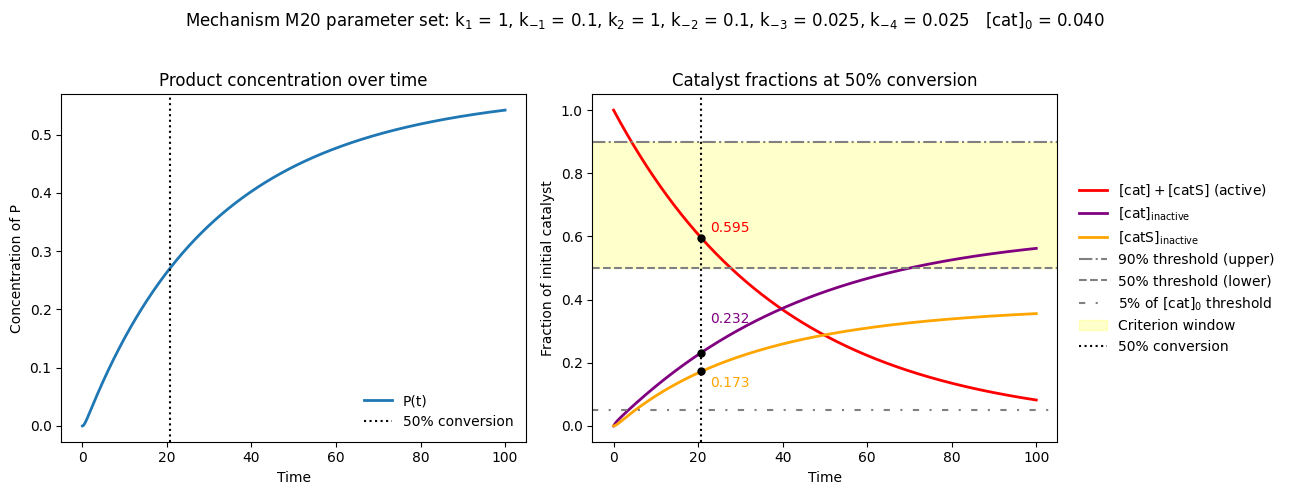

Filter result: Pass (active_cat in [50%, 90%] and both inact > 5% cat₀ at 50% conversion.)


Testing M20 with k₋3 = 0.030, k₋4 = 0.030
Initial cat = 0.030 → Fail (max yield = 0.384 < 50%)
Initial cat = 0.040 → Fail (max yield = 0.484 < 50%)
Initial cat = 0.050, Max P = 0.570, Time at 50% P_max = 17.83, Active cat fraction = 0.586, Inact_cat = 0.2398, Inact_catS = 0.1745


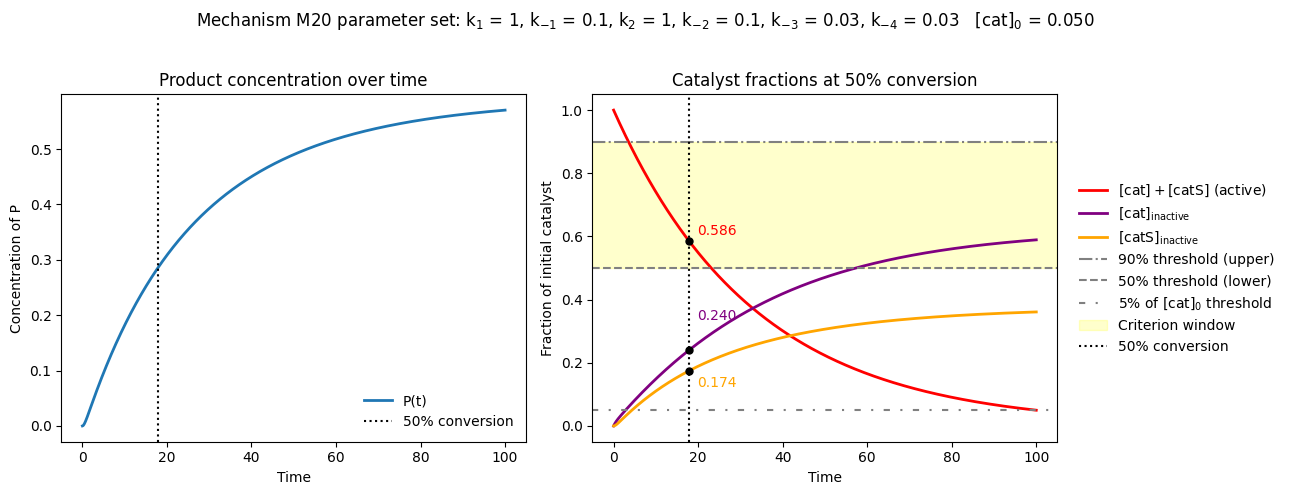

Filter result: Pass (active_cat in [50%, 90%] and both inact > 5% cat₀ at 50% conversion.)


Testing M20 with k₋3 = 0.035, k₋4 = 0.035
Initial cat = 0.030 → Fail (max yield = 0.342 < 50%)
Initial cat = 0.040 → Fail (max yield = 0.434 < 50%)
Initial cat = 0.050, Max P = 0.516, Time at 50% P_max = 16.28, Active cat fraction = 0.566, Inact_cat = 0.2505, Inact_catS = 0.1838


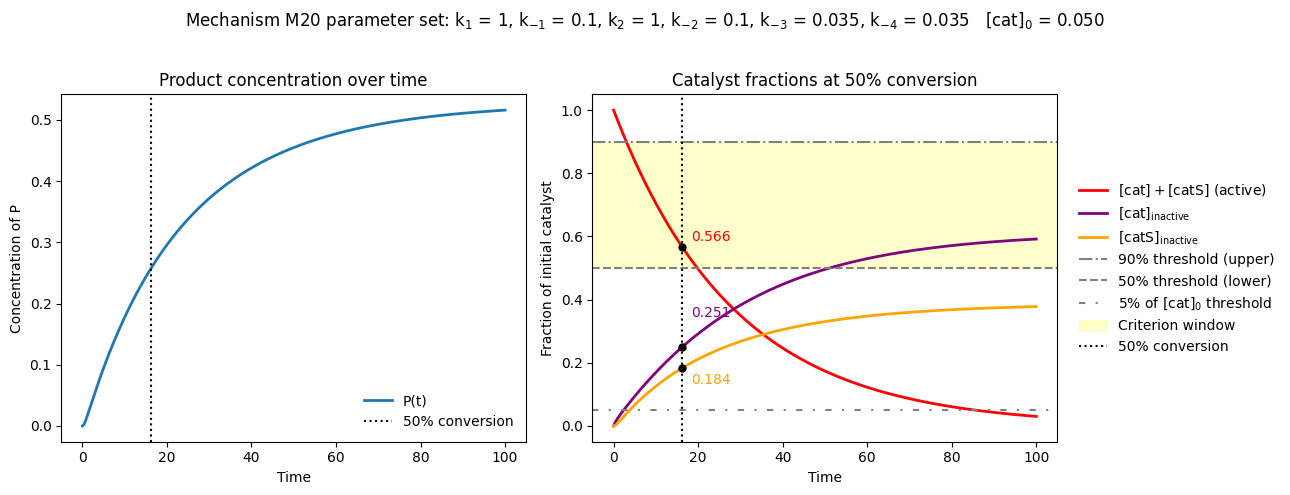

Filter result: Pass (active_cat in [50%, 90%] and both inact > 5% cat₀ at 50% conversion.)



In [81]:
def M20_dimerization_criterion(theta, verbose=True):
    S0 = 1.0
    P0 = 0.0
    cat0_list = np.linspace(0.03, 0.07, 5)
    passed_any = False

    for cat0 in cat0_list:
        y0 = [S0, P0, cat0, 0.0, 0.0, 0.0]
        try:
            sol = solve_ivp(lambda t, y: ode_M20(t, y, theta),
                            t_span=(0, 100),
                            y0=y0,
                            method='LSODA',
                            t_eval=np.linspace(0, 100, 1500),
                            rtol=1e-6,
                            atol=1e-9)
        except Exception as e:
            if verbose:
                print(f"ODE integration failed for Initial cat = {cat0:.3f}: {e}")
            continue

        if not sol.success or np.any(np.isnan(sol.y)):
            if verbose:
                print(f"ODE integration unsuccessful or NaN for Initial cat = {cat0:.3f}")
            continue

        t = sol.t
        S, P, cat, catS, inact_cat, inact_catS = sol.y
        P_max = np.max(P)

        if P_max < 0.5 * S0:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Fail (max yield = {P_max:.3f} < 50%)")
            continue

        P_interp        = interp1d(t, P, kind='linear', fill_value='extrapolate')
        cat_interp      = interp1d(t, cat, kind='linear', fill_value='extrapolate')
        catS_interp     = interp1d(t, catS, kind='linear', fill_value='extrapolate')
        inact_cat_interp   = interp1d(t, inact_cat, kind='linear', fill_value='extrapolate')
        inact_catS_interp  = interp1d(t, inact_catS, kind='linear', fill_value='extrapolate')

        try:
            sol_root = root_scalar(lambda ti: P_interp(ti) - 0.5 * P_max,
                                   bracket=[t[0], t[-1]], method='brentq')
            if not sol_root.converged:
                if verbose:
                    print(f"Root finding did not converge for Initial cat = {cat0:.3f}")
                continue
            t_half = sol_root.root
        except Exception as e:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → Root finding failed: {e}")
            continue

        if abs(P_interp(t_half) / (P_max + 1e-10) - 0.5) > 0.01:
            if verbose:
                print(f"Initial cat = {cat0:.3f} → No time point sufficiently close to 50% of P_max.")
            continue

        cat_val = cat_interp(t_half)
        catS_val = catS_interp(t_half)
        inact1 = inact_cat_interp(t_half)
        inact2 = inact_catS_interp(t_half)

        active_ratio = (cat_val + catS_val) / (cat0 + 1e-10)
        inact1_ratio = inact1 / (cat0 + 1e-10)
        inact2_ratio = inact2 / (cat0 + 1e-10)
        passed = (0.5 <= active_ratio <= 0.9) and (inact1_ratio > 0.05) and (inact2_ratio > 0.05)
        passed_any = passed_any or passed

        if verbose:
            print(
                f"Initial cat = {cat0:.3f}, Max P = {P_max:.3f}, Time at 50% P_max = {t_half:.2f}, "
                f"Active cat fraction = {active_ratio:.3f}, Inact_cat = {inact1_ratio:.4f}, Inact_catS = {inact2_ratio:.4f}"
            )

            fig, axs = plt.subplots(1, 2, figsize=(13, 5))

            axs[0].plot(t, P, label='P(t)', linewidth=2)
            axs[0].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[0].set_title("Product concentration over time")
            axs[0].set_xlabel("Time")
            axs[0].set_ylabel("Concentration of P")
            axs[0].legend(frameon=False)

            axs[1].plot(t, (cat + catS) / (cat0 + 1e-10), label=r'$[\mathrm{cat}] + [\mathrm{catS}]$ (active)', color='red', linewidth=2)
            axs[1].plot(t, inact_cat / (cat0 + 1e-10), label=r'$[\mathrm{cat}]_{\mathrm{inactive}}$', color='purple', linewidth=2)
            axs[1].plot(t, inact_catS / (cat0 + 1e-10), label=r'$[\mathrm{catS}]_{\mathrm{inactive}}$', color='orange',linewidth=2)
            
            axs[1].axhline(0.9, linestyle='-.', color='gray', label='90% threshold (upper)')
            axs[1].axhline(0.5, linestyle='--', color='gray', label='50% threshold (lower)')
            axs[1].axhline(0.05,  linestyle=(0, (3, 5, 1, 5)), color='gray', label='5% of [cat]$_0$ threshold')

            axs[1].axhspan(0.5, 0.9, color='yellow', alpha=0.2, label='Criterion window')
            axs[1].plot(t_half, active_ratio, 'ko', markersize=5)
            axs[1].text(t_half + 2, active_ratio + 0.02, f'{active_ratio:.3f}', color='red')

            axs[1].plot(t_half, inact1_ratio, 'ko', markersize=5)
            axs[1].text(t_half + 2, inact1_ratio + 0.095, f'{inact1_ratio:.3f}', color='purple')

            axs[1].plot(t_half, inact2_ratio, 'ko', markersize=5)
            axs[1].text(t_half + 2, inact2_ratio - 0.05, f'{inact2_ratio:.3f}', color='orange')

            axs[1].axvline(t_half, linestyle=':', color='black', label='50% conversion')
            axs[1].set_title("Catalyst fractions at 50% conversion")
            axs[1].set_xlabel("Time")
            axs[1].set_ylabel("Fraction of initial catalyst")
            axs[1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

            param_labels = ['k$_1$', 'k$_{-1}$', 'k$_2$', 'k$_{-2}$', 'k$_{-3}$', 'k$_{-4}$']
            param_str = ", ".join([f"{name} = {val:g}" for name, val in zip(param_labels, theta)])
            plt.suptitle(f"Mechanism M20 parameter set: {param_str}   [cat]$_0$ = {cat0:.3f}")
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

            if passed:
                print("Filter result: Pass (active_cat in [50%, 90%] and both inact > 5% cat₀ at 50% conversion.)\n")
            else:
                print("Filter result: Fail (active_cat or inact fraction not satisfied at 50% conversion.)\n")

        if passed:
            return True

    if verbose:
        print("Filter result: Fail (no Initial cat in [0.03, 0.07] satisfied the criterion,)\n")
    return False

base_theta = [1.0, 0.1, 1.0, 0.1]
k_3_list = [0.025, 0.03, 0.035]
k_4_list = [0.025, 0.03, 0.035]

for k3, k4 in zip(k_3_list, k_4_list):
    theta = np.array(base_theta + [k3, k4])
    print(f"\nTesting M20 with k₋3 = {k3:.3f}, k₋4 = {k4:.3f}")
    M20_dimerization_criterion(theta, verbose=True)

In [119]:
def generate_simulation_dataset(output_dir='simulation_data'):

    global seen_theta
    seen_theta = set()

    os.makedirs(output_dir, exist_ok=True)
    cache_dir = os.path.join(output_dir, "mechanism_cache")
    os.makedirs(cache_dir, exist_ok=True)

    N_MECH = len(MECHANISMS)
    THETA_PER_MECH_TRAINVAL = THETA_TRAIN_VAL // N_MECH
    THETA_PER_MECH_TEST = THETA_TEST // N_MECH
    N_TRAIN_PER_MECH = N_TRAIN // N_MECH
    N_VAL_PER_MECH = N_VAL // N_MECH
    N_TEST_PER_MECH = N_TEST // N_MECH

    max_dim = max(THETA_DIM.values())
    pad_theta = lambda th: list(th) + [np.nan]*(max_dim-len(th))

    all_theta = []
    for mech in tqdm(MECHANISMS, desc="Generating mechanisms", ncols=80, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
        param_dim = THETA_DIM[mech]
        filter_func = POST_FILTER_FUNCS.get(mech)
        thetas = filter_theta_pool(
            THETA_PER_MECH_TRAINVAL + THETA_PER_MECH_TEST,
            filter_func,
            ODE_FUNCS[mech],
            param_dim,
            max_round=500,
            batch_factor=200,
            verbose=False
        )
        all_theta.append(thetas)

    x1_train_all, x1_val_all, x1_test_all = [], [], []
    x2_train_all, x2_val_all, x2_test_all = [], [], []
    t_train_all, t_val_all, t_test_all = [], [], []
    y_train_all, y_val_all, y_test_all = [], [], []
    theta_train_all, theta_val_all, theta_test_all = [], [], []
    success_mechs = []
    failed_mechs = []

    for label, mech in enumerate(MECHANISMS):
        cache_file = os.path.join(cache_dir, f"{mech}_cache.pkl")
        if os.path.exists(cache_file):
            with open(cache_file, "rb") as f:
                mech_data = pickle.load(f)
            (x1_train, x2_train, t_train, x1_val, x2_val, t_val,
             x1_test, x2_test, t_test, y_train, y_val, y_test,
             theta_train_list, theta_val_list, theta_test_list) = mech_data
            theta_train_all.extend(theta_train_list)
            theta_val_all.extend(theta_val_list)
            theta_test_all.extend(theta_test_list)
            for th in theta_train_list + theta_val_list + theta_test_list:
                seen_theta.add(tuple(np.round(th, 6)))
            success_mechs.append(mech)
        else:
            try:
                ode_func = ODE_FUNCS[mech]
                dim = MECH_DIM[mech]
                thetas = all_theta[label]
                perm = np.random.permutation(thetas.shape[0])
                theta_trainval = thetas[perm[:THETA_PER_MECH_TRAINVAL]]
                theta_test = thetas[perm[THETA_PER_MECH_TRAINVAL:THETA_PER_MECH_TRAINVAL + THETA_PER_MECH_TEST]]

                train_samples = []
                theta_train_list = []
                n_train_collected = 0
                with tqdm(total=N_TRAIN_PER_MECH, desc=f"Train set ({mech})", ncols=70, leave=False) as pbar_train:
                    while n_train_collected < N_TRAIN_PER_MECH:
                        for theta in theta_trainval:
                            cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
                            profiles_30, t_30 = [], []
                            for cat0 in cat0s:
                                y0 = [1.0, 0.0, cat0] + [0.0] * (dim - 3)
                                res = simulate_trajectory(ode_func, theta, y0)
                                if res is not None:
                                    t_full, traj = res
                                    profiles_30.append(traj)
                                    t_30.append(t_full)
                            for _ in range(30):
                                if len(profiles_30) < 3:
                                    break
                                idxs = sorted(np.random.choice(len(profiles_30), 3, replace=False))
                                inits = [profiles_30[i] for i in idxs]
                                ts = [t_30[i] for i in idxs]
                                pick4 = np.random.choice(idxs)
                                cat0_4 = cat0s[pick4]
                                S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
                                P0_4 = 1.0 - S0_4
                                y0_4 = [S0_4, P0_4, cat0_4] + [0.0] * (dim - 3)
                                res4 = simulate_trajectory(ode_func, theta, y0_4)
                                if res4 is None:
                                    continue
                                t4, traj4 = res4
                                inits.append(traj4)
                                ts.append(t4)
                                profiles = []
                                t_all = []
                                for k in range(4):
                                    sub, t_sub = subsample_points(inits[k], ts[k], TRAIN_SAMPLE_POINTS)
                                    profiles.append(extract_SPcat(sub).T)
                                    t_all.append(t_sub)
                                sample_matrix = np.vstack(profiles)
                                t_concat = np.concatenate(t_all)
                                x1_row = [cat0s[idx] for idx in idxs] + [cat0_4]
                                train_samples.append((x1_row, sample_matrix, t_concat))
                                theta_train_list.append(pad_theta(theta))
                                n_train_collected += 1
                                pbar_train.update(1)
                                if n_train_collected >= N_TRAIN_PER_MECH:
                                    break
                            if n_train_collected >= N_TRAIN_PER_MECH:
                                break
                        if n_train_collected >= N_TRAIN_PER_MECH:
                            break

                val_samples = []
                theta_val_list = []
                n_val_collected = 0
                with tqdm(total=N_VAL_PER_MECH, desc=f"Validation set ({mech})", ncols=70, leave=False) as pbar_val:
                    while n_val_collected < N_VAL_PER_MECH:
                        for theta in theta_trainval:
                            cat0s = np.sort(np.random.uniform(0.01, 0.10, 30))
                            profiles_30, t_30 = [], []
                            for cat0 in cat0s:
                                y0 = [1.0, 0.0, cat0] + [0.0] * (dim - 3)
                                res = simulate_trajectory(ode_func, theta, y0)
                                if res is not None:
                                    t_full, traj = res
                                    profiles_30.append(traj)
                                    t_30.append(t_full)
                            for _ in range(30):
                                if len(profiles_30) < 3:
                                    break
                                idxs = sorted(np.random.choice(len(profiles_30), 3, replace=False))
                                inits = [profiles_30[i] for i in idxs]
                                ts = [t_30[i] for i in idxs]
                                pick4 = np.random.choice(idxs)
                                cat0_4 = cat0s[pick4]
                                S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
                                P0_4 = 1.0 - S0_4
                                y0_4 = [S0_4, P0_4, cat0_4] + [0.0] * (dim - 3)
                                res4 = simulate_trajectory(ode_func, theta, y0_4)
                                if res4 is None:
                                    continue
                                t4, traj4 = res4
                                inits.append(traj4)
                                ts.append(t4)
                                profiles = []
                                t_all = []
                                for k in range(4):
                                    sub, t_sub = subsample_points(inits[k], ts[k], TRAIN_SAMPLE_POINTS)
                                    profiles.append(extract_SPcat(sub).T)
                                    t_all.append(t_sub)
                                sample_matrix = np.vstack(profiles)
                                t_concat = np.concatenate(t_all)
                                x1_row = [cat0s[idx] for idx in idxs] + [cat0_4]
                                val_samples.append((x1_row, sample_matrix, t_concat))
                                theta_val_list.append(pad_theta(theta))
                                n_val_collected += 1
                                pbar_val.update(1)
                                if n_val_collected >= N_VAL_PER_MECH:
                                    break
                            if n_val_collected >= N_VAL_PER_MECH:
                                break
                        if n_val_collected >= N_VAL_PER_MECH:
                            break

                test_samples = []
                theta_test_list = []
                n_test_collected = 0
                with tqdm(total=N_TEST_PER_MECH, desc=f"Test set ({mech})", ncols=70, leave=False) as pbar_test:
                    while n_test_collected < N_TEST_PER_MECH:
                        for theta in theta_test:
                            cat0s = [np.random.uniform(0.01, 0.02), np.random.uniform(0.045, 0.055), np.random.uniform(0.09, 0.10)]
                            inits, ts = [], []
                            for cat0 in cat0s:
                                y0 = [1.0, 0.0, cat0] + [0.0] * (dim - 3)
                                res = simulate_trajectory(ode_func, theta, y0, n_points=TEST_SAMPLE_POINTS)
                                if res is not None:
                                    t_short, traj_short = res
                                    inits.append(traj_short)
                                    ts.append(t_short)
                            pick4 = np.random.randint(0, 3)
                            cat0_4 = cat0s[pick4]
                            S0_4 = np.round(np.random.uniform(0.4, 0.8), 4)
                            P0_4 = 1.0 - S0_4
                            y0_4 = [S0_4, P0_4, cat0_4] + [0.0] * (dim - 3)
                            res4 = simulate_trajectory(ode_func, theta, y0_4, n_points=TEST_SAMPLE_POINTS)
                            if res4 is not None:
                                t4, traj4 = res4
                                inits.append(traj4)
                                ts.append(t4)
                                profiles = []
                                t_all = []
                                for k in range(4):
                                    sub, t_sub = subsample_points(inits[k], ts[k], TEST_SAMPLE_POINTS)
                                    profiles.append(extract_SPcat(sub).T)
                                    t_all.append(t_sub)
                                sample_matrix = np.vstack(profiles)
                                t_concat = np.concatenate(t_all)
                                x1_row = [cat0 for cat0 in cat0s] + [cat0_4]
                                test_samples.append((x1_row, sample_matrix, t_concat))
                                theta_test_list.append(pad_theta(theta))
                                n_test_collected += 1
                                pbar_test.update(1)
                                if n_test_collected >= N_TEST_PER_MECH:
                                    break
                        if n_test_collected >= N_TEST_PER_MECH:
                            break

                x1_train, x2_train, t_train = zip(*train_samples)
                x1_val, x2_val, t_val = zip(*val_samples)
                x1_test, x2_test, t_test = zip(*test_samples)

                x1_train = np.stack(x1_train)
                x1_val = np.stack(x1_val)
                x1_test = np.stack(x1_test)
                x2_train = np.stack(x2_train)
                x2_val = np.stack(x2_val)
                x2_test = np.stack(x2_test)
                t_train = list(t_train)
                t_val = list(t_val)
                t_test = list(t_test)

                y_train = np.full(len(x1_train), label)
                y_val = np.full(len(x1_val), label)
                y_test = np.full(len(x1_test), label)
                mech_data = (x1_train, x2_train, t_train, x1_val, x2_val, t_val, x1_test, x2_test, t_test, y_train, y_val, y_test, theta_train_list, theta_val_list, theta_test_list)
                with open(cache_file, "wb") as f:
                    pickle.dump(mech_data, f)
                theta_train_all.extend(theta_train_list)
                theta_val_all.extend(theta_val_list)
                theta_test_all.extend(theta_test_list)
                for th in theta_train_list + theta_val_list + theta_test_list:
                    seen_theta.add(tuple(np.round(th, 6)))
                success_mechs.append(mech)
            except Exception as e:
                print(f"Skipping {mech} due to error: {e}")
                failed_mechs.append(mech)
                continue

        x1_train_all.append(x1_train)
        x2_train_all.append(x2_train)
        t_train_all.extend(t_train)
        y_train_all.append(y_train)
        x1_val_all.append(x1_val)
        x2_val_all.append(x2_val)
        t_val_all.extend(t_val)
        y_val_all.append(y_val)
        x1_test_all.append(x1_test)
        x2_test_all.append(x2_test)
        t_test_all.extend(t_test)
        y_test_all.append(y_test)

    x1_train = np.concatenate(x1_train_all)
    x2_train = np.concatenate(x2_train_all)
    y_train = np.concatenate(y_train_all).reshape(-1, 1)
    x1_val = np.concatenate(x1_val_all)
    x2_val = np.concatenate(x2_val_all)
    y_val = np.concatenate(y_val_all).reshape(-1, 1)
    x1_test = np.concatenate(x1_test_all)
    x2_test = np.concatenate(x2_test_all)
    y_test = np.concatenate(y_test_all).reshape(-1, 1)

    x2_train = format_x2_blocks(x2_train, t_train_all, n_points=21)
    x2_val = format_x2_blocks(x2_val, t_val_all, n_points=21)
    x2_test = format_test_blocks(x2_test, t_test_all, n_points=7)

    y_train_onehot = np.eye(20)[y_train.squeeze()]
    y_val_onehot = np.eye(20)[y_val.squeeze()]
    y_test_onehot = np.eye(20)[y_test.squeeze()]

    theta_train = np.array(theta_train_all)
    theta_val = np.array(theta_val_all)
    theta_test = np.array(theta_test_all)
    
    assert x1_train.shape == (4950000, 4)
    assert x2_train.shape == (4950000, 21, 12)
    assert x1_val.shape == (50000, 4)
    assert x2_val.shape == (50000, 21, 12)
    assert x1_test.shape == (100000, 4)

    n_test_samples = x2_test.shape[0]
    x2_test_dict = {}
    for n_pts in range(TEST_SAMPLE_POINTS, 1, -1):
        x2_test_dict[str(n_pts)] = {}
        for noise_pct in [0.5, 1, 2, 3, 4, 5]:
            test_profiles = []
            for i in range(n_test_samples):
                profiles = []
                for j in range(4):
                    idx_full = np.arange(TEST_SAMPLE_POINTS)
                    t0_idx = idx_full[0]
                    rest_idx = idx_full[1:]
                    if n_pts == 1:
                        idx = np.array([t0_idx])
                    else:
                        sampled = np.sort(np.random.choice(rest_idx, n_pts - 1, replace=False))
                        idx = np.insert(sampled, 0, t0_idx)
                    t_this = np.array(t_test_all[i])[j * TEST_SAMPLE_POINTS : (j + 1) * TEST_SAMPLE_POINTS]
                    start_col = j * 3
                    time = t_this[idx].reshape(-1, 1)
                    SP = x2_test[i][idx, start_col + 1 : start_col + 3]
                    if noise_pct > 0:
                        std = noise_pct / 100 * np.max(SP)
                        SP = SP + np.random.normal(0, std, size=SP.shape)
                    block = np.hstack([time, SP])
                    profiles.append(block)
                block_cat = np.hstack(profiles)
                
                block_min = block_cat.min(axis=0, keepdims=True)
                block_max = block_cat.max(axis=0, keepdims=True)
                s_cols = [1, 4, 7, 10]
                p_cols = [2, 5, 8, 11]

                s_vals = block_cat[:, s_cols].flatten()
                s_min, s_max = s_vals.min(), s_vals.max()
                block_min[:, s_cols] = s_min
                block_max[:, s_cols] = s_max

                p_vals = block_cat[:, p_cols].flatten()
                p_min, p_max = p_vals.min(), p_vals.max()
                block_min[:, p_cols] = p_min
                block_max[:, p_cols] = p_max
                
                denom = block_max - block_min
                denom[denom == 0] = 1
                block_cat_norm = (block_cat - block_min) / denom
                
                test_profiles.append(block_cat_norm)
            x2_test_dict[str(n_pts)][str(noise_pct)] = np.stack(test_profiles)

    assert x2_test_dict['7']['1'].shape == (100000, 7, 12)

    with open(os.path.join(output_dir, 'x2_train_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x2_train, f)
    with open(os.path.join(output_dir, 'x2_val_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x2_val, f)
    with open(os.path.join(output_dir, 'x2_test_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x2_test_dict['7']['1'], f)

    with open(os.path.join(output_dir, 'x1_train_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x1_train, f)
    with open(os.path.join(output_dir, 'x1_val_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x1_val, f)
    with open(os.path.join(output_dir, 'x1_test_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(x1_test, f)

    with open(os.path.join(output_dir, 'y_train_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(y_train_onehot, f)
    with open(os.path.join(output_dir, 'y_val_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(y_val_onehot, f)
    with open(os.path.join(output_dir, 'y_test_M1_M20_train_val_test_set.pkl'), 'wb') as f:
        pickle.dump(y_test_onehot, f)

    with open(os.path.join(output_dir, 'theta_train_M1_M20.pkl'), 'wb') as f:
        pickle.dump(theta_train, f)
    with open(os.path.join(output_dir, 'theta_val_M1_M20.pkl'), 'wb') as f:
        pickle.dump(theta_val, f)
    with open(os.path.join(output_dir, 'theta_test_M1_M20.pkl'), 'wb') as f:
        pickle.dump(theta_test, f)

    try:
        import multiprocessing
        multiprocessing.set_start_method('spawn')
    except RuntimeError:
        pass

    print("\nSuccessfully generated data for:", success_mechs)
    print("Skipped due to failure:", failed_mechs)

if __name__ == '__main__':
    try:
        generate_simulation_dataset()
    except Exception as e:
        print("Dataset generation failed:", e)
        import sys
        sys.exit(1)

Generating mechanisms: 100%|███████████████████████████████| 20/20 [13:10<00:00]



Successfully generated data for: ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M19', 'M20']
Skipped due to failure: []


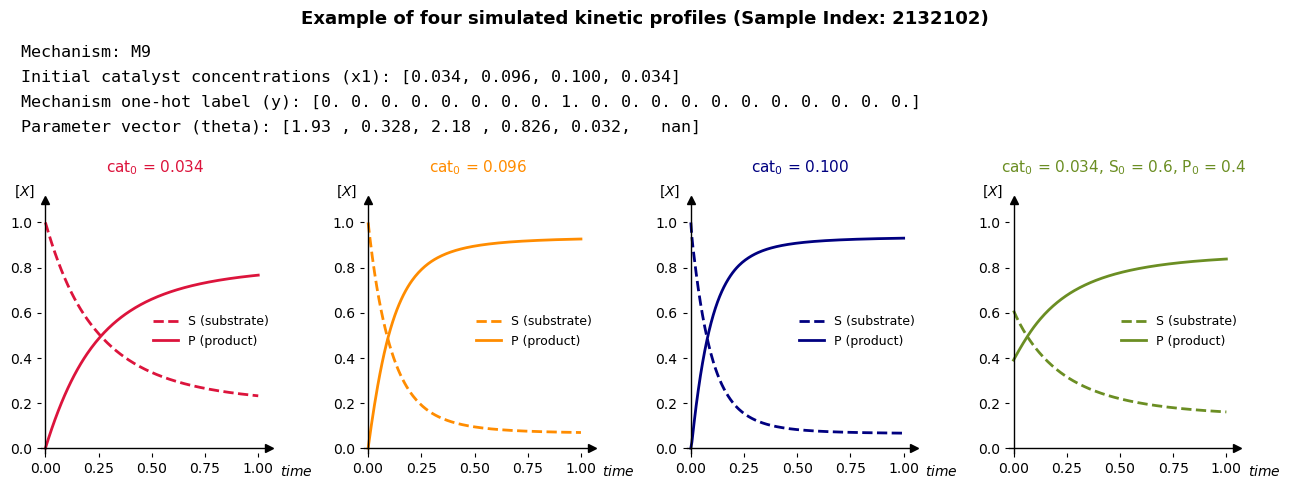

In [41]:
def plot_sample(
    x1, x2, y, idx=None,
    colors=['crimson', 'darkorange', 'navy', 'olivedrab']
):
    np.random.seed(726)
    if idx is None:
        idx = np.random.choice(x1.shape[0], 1)[0]
    fig, axes = plt.subplots(1, 4, figsize=(13, 5))

    x1_row = x1[idx]
    cat0s = x1_row[:3]
    if len(x1_row) >= 6:
        cat0_4, S0_4, P0_4 = x1_row[3], x1_row[4], x1_row[5]
    else:
        cat0_4 = x1_row[3]
        S0_4 = 1.0
        P0_4 = 0.0

    for j, ax in enumerate(axes):
        t = x2[idx, :, j*3 + 0]
        S = x2[idx, :, j*3 + 1]
        P = x2[idx, :, j*3 + 2]
        t_dense = np.linspace(t[0], t[-1], 200)
        S_smooth = interp1d(t, S, kind='cubic')(t_dense)
        P_smooth = interp1d(t, P, kind='cubic')(t_dense)

        ax.plot(t_dense, S_smooth, '--', color=colors[j], lw=2, label="S (substrate)")
        ax.plot(t_dense, P_smooth, '-', color=colors[j], lw=2, label="P (product)")

        xlim = (-0.02, 1.05)
        ylim = (-0.02, 1.1)
        ax.plot([xlim[0], xlim[1]], [0, 0], color='black', lw=1, clip_on=False)
        ax.plot([0, 0], [ylim[0], ylim[1]], color='black', lw=1, clip_on=False)
        ax.plot([xlim[1]], [0], marker='>', color='black', transform=ax.transData, clip_on=False)
        ax.plot([0], [ylim[1]], marker='^', color='black', transform=ax.transData, clip_on=False)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.text(-0.05, 1.1, r'$\mathit{[X]}$', fontsize=10, color='black', ha='right', va='bottom')
        ax.text(1.1, -0.07, r'$\mathit{time}$', fontsize=10, color='black', ha='left', va='top')

        if j < 3:
            ax.set_title(f"cat$_0$ = {cat0s[j]:.3f}", fontsize=11, color=colors[j], pad=20)
        else:
            ax.set_title(
                f"cat$_0$ = {cat0_4:.3f}, S$_0$ = 0.6, P$_0$ = 0.4",
                fontsize=11, color=colors[j], pad=20
            )

        ax.tick_params(axis='both', labelsize=10, colors='black', direction='out', length=3)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.legend(
            loc="center right",
            bbox_to_anchor=(1.05, 0.48),
            fontsize=9,
            frameon=False
        )

    plt.tight_layout(w_pad=1.5)
    plt.subplots_adjust(top=0.6)

    if y.ndim == 2 and y.shape[1] == 1:
        mech = int(y[idx, 0]) + 1
    elif y.ndim == 2 and y.shape[1] == 20:
        mech = int(np.argmax(y[idx])) + 1
    else:
        mech = int(y[idx]) + 1
        
    x1_vals = x1[idx]
    x1_str = "[" + ", ".join([f"{v:.3f}" for v in x1_vals]) + "]"

    y_str = np.array2string(y[idx], max_line_width=160)
    theta_str = np.array2string(theta[idx], precision=3, separator=', ', suppress_small=True)
    
    plt.suptitle(
        f'Example of four simulated kinetic profiles (Sample Index: {idx})',
        fontsize=13,
        fontweight='bold'
    )
    
    plt.figtext(
        0.02, 0.91, f"Mechanism: M{mech}",
        fontsize=12, ha='left', va='top', family='monospace'
    )
    plt.figtext(
        0.02, 0.86, f"Initial catalyst concentrations (x1): {x1_str}",
        fontsize=12, ha='left', va='top', family='monospace'
    )
    plt.figtext(
        0.02, 0.81, f"Mechanism one-hot label (y): {y_str}",
        fontsize=12, ha='left', va='top', family='monospace'
    )
    plt.figtext(
        0.02, 0.76, f"Parameter vector (theta): {theta_str}",
        fontsize=12, ha='left', va='top', family='monospace'
    )
    
    plt.savefig(f"kinetic_profile_sample.pdf", dpi=1000, bbox_inches='tight')
    plt.show()

data_dir = 'simulation_data'
x1 = pickle.load(open(f"{data_dir}/x1_train_M1_M20_train_val_test_set.pkl", 'rb'))
x2 = pickle.load(open(f"{data_dir}/x2_train_M1_M20_train_val_test_set.pkl", 'rb'))
y = pickle.load(open(f"{data_dir}/y_train_M1_M20_train_val_test_set.pkl", 'rb'))
theta = pickle.load(open(f"{data_dir}/theta_train_M1_M20.pkl", 'rb'))

plot_sample(x1, x2, y, idx=None)